# Panel Data Homework: Joel Thomas and Lukas Grahl

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import chardet

%matplotlib inline
%config IPCompleter.greedy = False
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import matplotlib.patches as patches
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

In [146]:
def add_stars(params, pvals):
    ret = []
    for param, pval in zip(params.values, pvals.values):
        if pval < 0.01:
            ret.append(str(f'{param:0.3f}***'))
        elif pval < 0.05:
            ret.append(str(f'{param:0.3f}**'))
        elif pval < 0.10:
            ret.append(str(f'{param:0.3f}*'))
        else:
            ret.append(str(f'{param:0.3f}'))
    return pd.Series(ret)

def save_results(model, name):
    out = model.params
    out[:] = add_stars(model.params, model.pvalues)
    out['r2'] = model.rsquared
    out.name = name
    return out

In [147]:
df = pd.read_excel('/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Panel Data/Homework/burnside2.xls')

In [148]:
df.drop(columns=df.columns[0], inplace=True)

In [149]:
#dropping the observations not used by B&D2000.
df = df[df['YEAR1'] != '1966-69']
Countries = ['DZA', 'ARG', 'BOL', 'BWA', 'BRA', 'CMR', 'CHL', 'COL', 'CRI', 'CIV', 'DOM', 'ECU', 'EGY', 'SLV','ETH',
            'GAB', 'GMB', 'GHA', 'GTM', 'GUY', 'HTI', 'HND', 'IND', 'IDN', 'JAM', 'KEN', 'KOR', 'MDG', 'MWI', 'MYS',
            'MLI', 'MEX', 'MAR', 'NIC', 'NER', 'NGA', 'PAK', 'PRY', 'PER', 'PHL', 'SEN', 'SLE', 'SOM', 'LKA', 'SYR',
            'TZA', 'THA', 'TGO', 'TTO', 'TUN', 'TUR', 'URY', 'VEN', 'ZAR', 'ZMB', 'ZWE']

df = df[df['Country3'].apply(lambda x: True if x in Countries else False)]
df.drop(columns=['CountryYear', 'Country3','Ident','Year'], inplace=True)

years = df['YEAR1'].unique()
start = [x.split('-')[0] for x in years]
end = ['19'+x.split('-')[1] for x in years]
years = [i + '-' + j for i,j in zip(start, end)]
replace_map = {}
for old_year, new_year in zip(df['YEAR1'].unique(), years):
    replace_map[old_year] = new_year

df['YEAR1'] = df['YEAR1'].apply(lambda x: replace_map[x])

df['Country'] = df['Country'].str.title()
df = df.set_index(['Country', 'YEAR1'])

In [150]:
#yearly dummies
df['INFL'] = df['INFL'].apply(np.float64)

#Drop NAs from GDP and BB columns, creating the 275 row dataframe used by Burnside and Dollar
df.dropna(axis=0, how='any', subset=['GDPG', 'GDP', 'BB', 'INFL', 'M2-1'], inplace=True)
print(f'Rows in data set: {df.shape[0]}')

Rows in data set: 275


In [151]:
line = ''
print(('Country' + ' '*16 + 'N Obs' + ' '*8) * 3)
print('='*100)
for country, count in zip(df.groupby('Country').size().index, df.groupby('Country').size()):
    text = country + ' '*(25-len(country)) + str(count) + ' '*10
    if len(line) < 100:
        line += text
    else:
        print(line)
        line = ''

Country                N Obs        Country                N Obs        Country                N Obs        
Algeria                  2          Argentina                6          Bolivia                  6          
Brazil                   6          Cameroon                 5          Chile                    6          
Costa Rica               6          Cote D'Ivoire            1          Dominican Republic       6          
Egypt                    5          El Salvador              6          Ethiopia                 2          
Gambia, The              6          Ghana                    6          Guatemala                6          
Haiti                    5          Honduras                 6          India                    6          
Jamaica                  3          Kenya                    6          Korea, Republic Of       6          
Malawi                   4          Malaysia                 6          Mali                     1          
Morocco            

Burnside and Dollar (2000) though it useful to use a policy index rather than three separate variables. Their model suggests that it is the distortions that affect growth that will determine the effectiveness of aid. Hence, they weight the policies according to their impact on growth. This allows them to discuss the effectiveness of aid in 'good' and 'bad' policy environments. They use the OLS regression of the growth equation with no aid terms: 
$$
g_{it} = y_{it}\beta_{y} + p'_{it}\beta_p + z'_{it}\beta_z + g_t + \epsilon_{it}^g 
$$
This fixes the values of the coefficients on the variables that determine the policy index. So, $p_{it} = p'_{it}b_p$ where $b_p$ is the OLS estimate of $\beta_p$.

In [152]:
df.head()

year      GDPG     GDP        BB       INFL  SACW  \
Country   YEAR1                                                          
Algeria   1970-1973     2  2.386265  1826.0 -6.833652   4.641260   0.0   
          1974-1977     3  3.236684  2256.0  3.660488   8.209326   0.0   
Argentina 1970-1973     2  1.700300  5637.0 -2.114630  34.088607   0.0   
          1974-1977     3  1.077615  6168.0 -6.911749  98.995955   0.0   
          1978-1981     4 -1.115285  5849.0 -3.395044  84.483147   0.0   

                          GOVC  ETHNF  ASSAS     ICRGE       M2-1  SSA  EASIA  \
Country   YEAR1                                                                 
Algeria   1970-1973  15.471668   43.0   0.00  4.364583  49.102671    0      0   
          1974-1977  12.345353   43.0   0.00  4.364583  61.462472    0      0   
Argentina 1970-1973  10.194982   31.0   2.75  4.281250  24.824762    0      0   
          1974-1977  11.044480   31.0   9.75  4.281250  28.793040    0      0   
          1978-1981  11.086979   31.0   1.00  4.281250  30.234517    0      0   

                          LPOP  EGYPT  CENTAM  FRZ  ARMS-1  DN1900       EDA  \
Country   YEAR1                                                                
Algeria   1970-1973  16.482732    0.0     0.0  0.0   2.967       0  1.032286   
          1974-1977  16.605724    0.0     0.0  0.0   1.950       0  0.500887   
Argentina 1970-1973  17.017208    0.0     0.0  0.0   2.033       1  0.018239   
          1974-1977  17.082911    0.0     0.0  0.0   1.725       1  0.017155   
          1978-1981  17.144003    0.0     0.0  0.0   1.075       1  0.023994   

                         BEDA      MEDA     WBEDA      POPDEP  
Country   YEAR1                                                
Algeria   1970-1973  0.842784  0.189503  0.000000  110.482000  
          1974-1977  0.433937  0.066950  0.001251  107.439000  
Argentina 1970-1973  0.016755  0.001484 -0.000961   57.374800  
          1974-1977  0.016532  0.000623 -0.002459   58.844350  
          1978-1981  0.019493  0.004501 -0.002057   61.571267

Yearly dummies are also created to allow for time fixed effects. It is at this point that the interaction term of Ethnic Fractionalisation and Assassinations is made as in Burnside and Dollar (2000). Furthermore, GDP is logged to create the variable lGDP.

In [153]:
df = pd.get_dummies(df, columns=['year'], drop_first=True)

df['ETHNF'] = df['ETHNF'] / 100
df['INFL'] = df['INFL'] / 100
df['BB'] = df['BB'] / 100


#interaction term
df['ETHNF*ASSAS'] = df['ETHNF'] * df['ASSAS']
df['lGDP'] = np.log(df['GDP'])
#constant for the regressions
df['Constant'] = 1

#yearly columns were created as boolians (true or false) not integers or floats, so we convert them to integers here.
bool_columns = ['year_3', 'year_4', 'year_5', 'year_6', 'year_7']
for column in bool_columns:
    df[column] = df[column].astype(int)


The regression for the policy index is run and the constant term: $\bar{GDPG} - \bar{\beta_1} - \bar{\beta_2} - \bar{\beta_3}$.

In [154]:
y = df['GDPG']
X = df[['Constant', 'lGDP', 'ETHNF', 'ASSAS', 'ETHNF*ASSAS', 'ICRGE',
        'M2-1', 'SSA', 'EASIA', 'BB', 'INFL', 'SACW',
       'year_3', 'year_4', 'year_5', 'year_6', 'year_7']]

ols = sm.OLS(y, X, has_const=True).fit(cov_type='HC0')
policy_β = ols.params[['BB', 'INFL', 'SACW']]
policy_β

BB      6.845003
INFL   -1.398082
SACW    2.156602
dtype: float64

In [155]:
p_const = df['GDPG'].mean() - (df[['BB', 'INFL', 'SACW']].values @ policy_β).mean()
p_const

1.277888957859385

The policy index is of the form:
$$
Policy_{it} = \alpha + \beta_1BB_{it} + \beta_2INFL_{it} + \beta_3SACW_{it} + \epsilon_{it}
$$

with the regression implemented in the cells above.

In [156]:
df['Policy'] = p_const + df[['BB', 'INFL', 'SACW']].values @ policy_β

# 1. In your data set, which are the variables which are varying with respect to two indices (or more if you consider inflows and outflows from one individual or country to another individual or countries? Which are the variables which are varying only with respect to time? Which are the variables which are varying only with respect to individuals?

The indices are country and time. Each country has observations for multiple variables across multiple dates. The variables are GDP Growth (GDPG), GDP (GDP), Budget surplus (BB), Inflation (INFL), Sachs-Warner openness (SACW), Government consumption  (GOVC), ethnic fractionalisation (ETHNF), Assasinations (ASSAS), international country risk guide (higher is better) (ICRGE), money supply lagged (M2-1), Sub-Saharan Africa indicator (SSA), East-Asia indicator (EASIA), log population (LPOP), indicator dummy for Egypt (EGYPT), central America indicator (CENTAM), franc zone indicator (FRZ), lagged arms imports (ARMS-1), indicator for countries not dominated by Europeans by 1900 (DN1900), Effective Development assistance (EDA), bilateral effective development assistance (BEDA), multilateral effective development assistance (MEDA), World Bank effective development assistance (WBEDA), population dependency (POPDEP). 

#### Varying with respect to two (or more) indices.
We are looking for variables that vary both across countries and across time. Most of the variables in this dataset varying across two (or more) indices: GDPG (GDP Growth), GDP (Gross Domestic Product), BB (Budget surplus), INFL (Inflation), SACW (Sachs-Warner openness), GOVC (Government Consumption), ETHNF (Ethnic Fractionalisation), ASSAS (Assassinations), ICRGE (International Country Risk Guide), M2-1 (lagged money supply), ARMS-1 (Lagged arms imports), EDA (Economic Development Assistance), BEDA (Bilateral Economic Development Assistance), MEDA (Multilateral Economic Development Assistance), WBEDA (World Bank Economic Development Assistance), POPDEP (Population Dependency), LPOP (log of population).

#### Varying with respect to time only.
Variables that vary only with respect to time and are constant across all countries would be global variables. This could be like 'total World Bank EDA'. These variables are not country specific and therefore vary only across time. However, we have none of these variables in the data-set in absolute terms. We will perform a statistical analysis using to identify variables that have little to no individual variance but variables across time.

#### Varying with respect to country only.
These are time-invariant variables that are country specific. Many of these variables are indicator dummies: SSA (Sub-Saharan Africa indicator), EASIA (East Asia indicator), EGYPT (Indicator for Egypt), CENTAM (Central America indicator), FRZ (Indicator for Franc Zone), DN1900 (Indicator for countries not dominated by Europeans by 1900). None of these variables will change across time because they are geographic variables and geography is generally understood to be constant over time (certainly over the time period we are looking at).

### Country Variation

We construct a list of all of the variables of interest and those employed in the Burnside and Dollar (2000) paper and some extra to analyse their variation across countries, time or both. We include the log of GDP; GDP growth; Budget surplus; Sachs and Warner openness; Government Consumption; ethnic fractionalisation; assassinations; (lack of) country risk; lagged money supply; lagged arms imports; effective development assistance; bilateral, multilateral and World bank effective development assistance; population dependency; log of population; the ethnical fractionalisation and assassination interaction term; the policy index.

In [157]:
X_vars = ['lGDP', 'GDPG', 'BB', 'INFL', 'SACW', 'GOVC', 'ETHNF', 'ASSAS', 'ICRGE', 'M2-1', 'ARMS-1', 'EDA', 'BEDA', 'MEDA',
          'WBEDA', 'POPDEP', 'LPOP', 'ETHNF*ASSAS', 'Policy']

#X_vars = ['BB', 'INFL', 'SACW', 'GDPG', 'lGDP', 'ETHNF*ASSAS',
#          'ETHNF', 'ASSAS','ICRGE', 'M2-1', 'EDA', 'Policy']

In [158]:
df[X_vars].groupby('Country').agg(np.nanmean).apply(np.nanvar).sort_values(ascending=False)

ARMS-1         256.986871
POPDEP         154.274298
M2-1           115.735744
GOVC            17.877465
GDPG             5.584410
EDA              3.873594
LPOP             1.976283
BEDA             1.610940
ICRGE            1.475768
Policy           0.836098
ASSAS            0.645803
MEDA             0.619969
lGDP             0.517923
ETHNF*ASSAS      0.137880
SACW             0.102723
ETHNF            0.090667
INFL             0.061593
WBEDA            0.053044
BB               0.002168
dtype: float64

Across the countries, the lagged arms imports has the greatest variance, followed by population dependency and lagged money supply. The variation in lagged arms imports is the most variable by a country mile, perhaps indicative of some of the countries in the sample being at war, such as Sierra Leone. Interestingly, the least variable across countries is the budget surplus. The graphs below illustrate the variations in more detail.

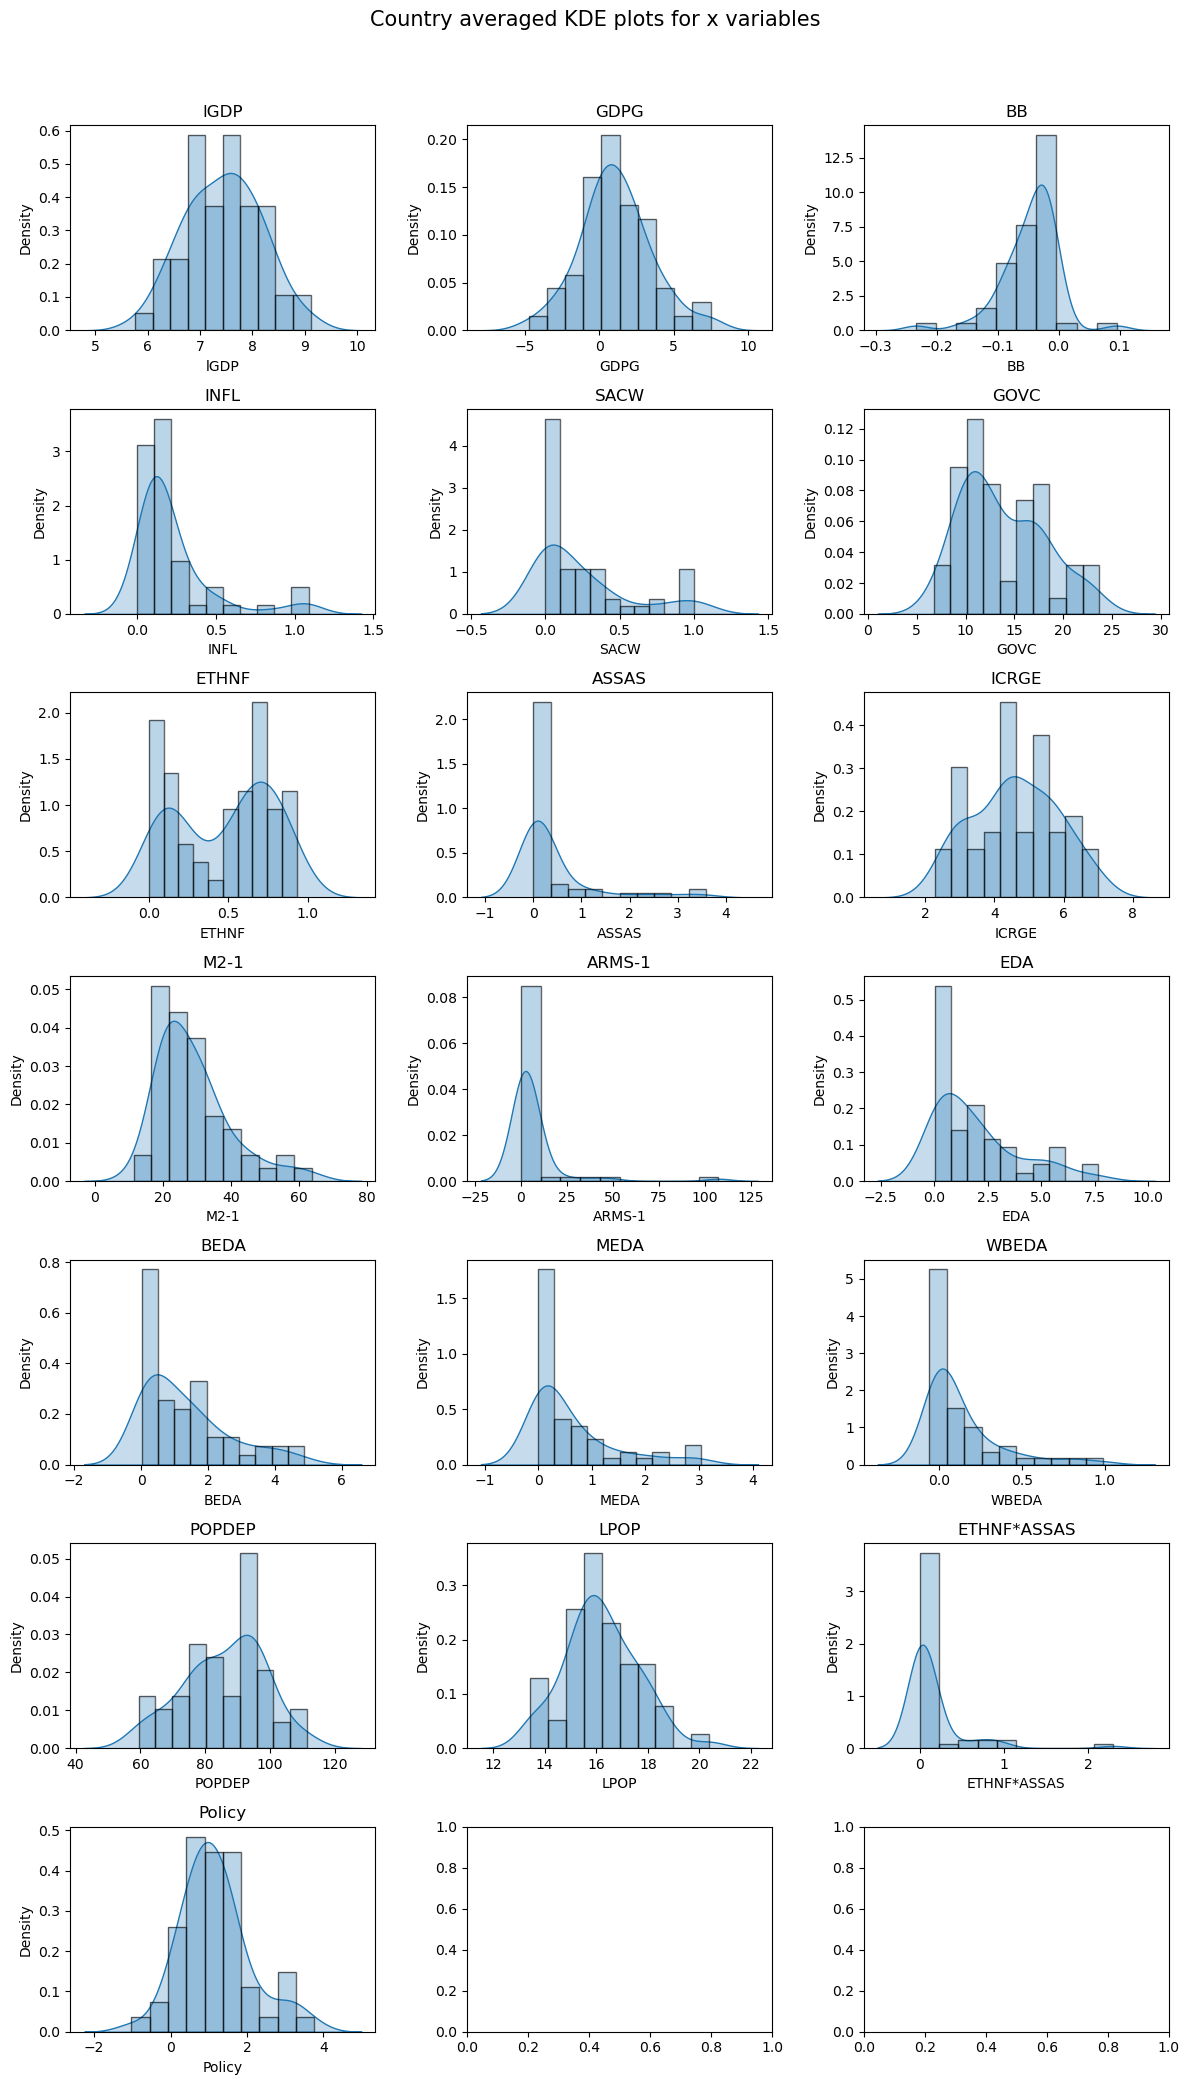

In [159]:
fig, ax = plt.subplots(7,3, figsize=(12,20), dpi=100)
for var, axis in zip(X_vars, fig.axes):
    g = sns.kdeplot(df[var].groupby('Country').agg(np.nanmean), ax=axis, legend=False, shade=True)
    axis.hist(df[var].groupby('Country').agg(np.nanmean), density=True, facecolor='Tab:Blue', edgecolor=None, 
             alpha=0.3)
    axis.hist(df[var].groupby('Country').agg(np.nanmean), density=True, facecolor='None', edgecolor='black',
             alpha=0.6)
    axis.set_title(var)
fig.tight_layout()
fig.suptitle('Country averaged KDE plots for x variables', size=15, y=1.04)
plt.show()

Observation of the KDE plots for the variables yields more information. Many of the variables are strongly centred to 0, such as the foreign aid variables, for which most countries receive none or very little. Futhermore, the assassination and ETHNF*assassination variables are very storngly centred to zero with high kurtosis. Ethnic fractionalisation is a very bimodal variable, the distribution dips towards the centre (0.5) and peaks at either side, suggesting countries either have a very high or very low degree of ethnic fractionalisation. Overall the variation across countries does not hold many surprises, with many variables hugging 0 and only ethnic fractionalisation having the interesting bimodal distribution.

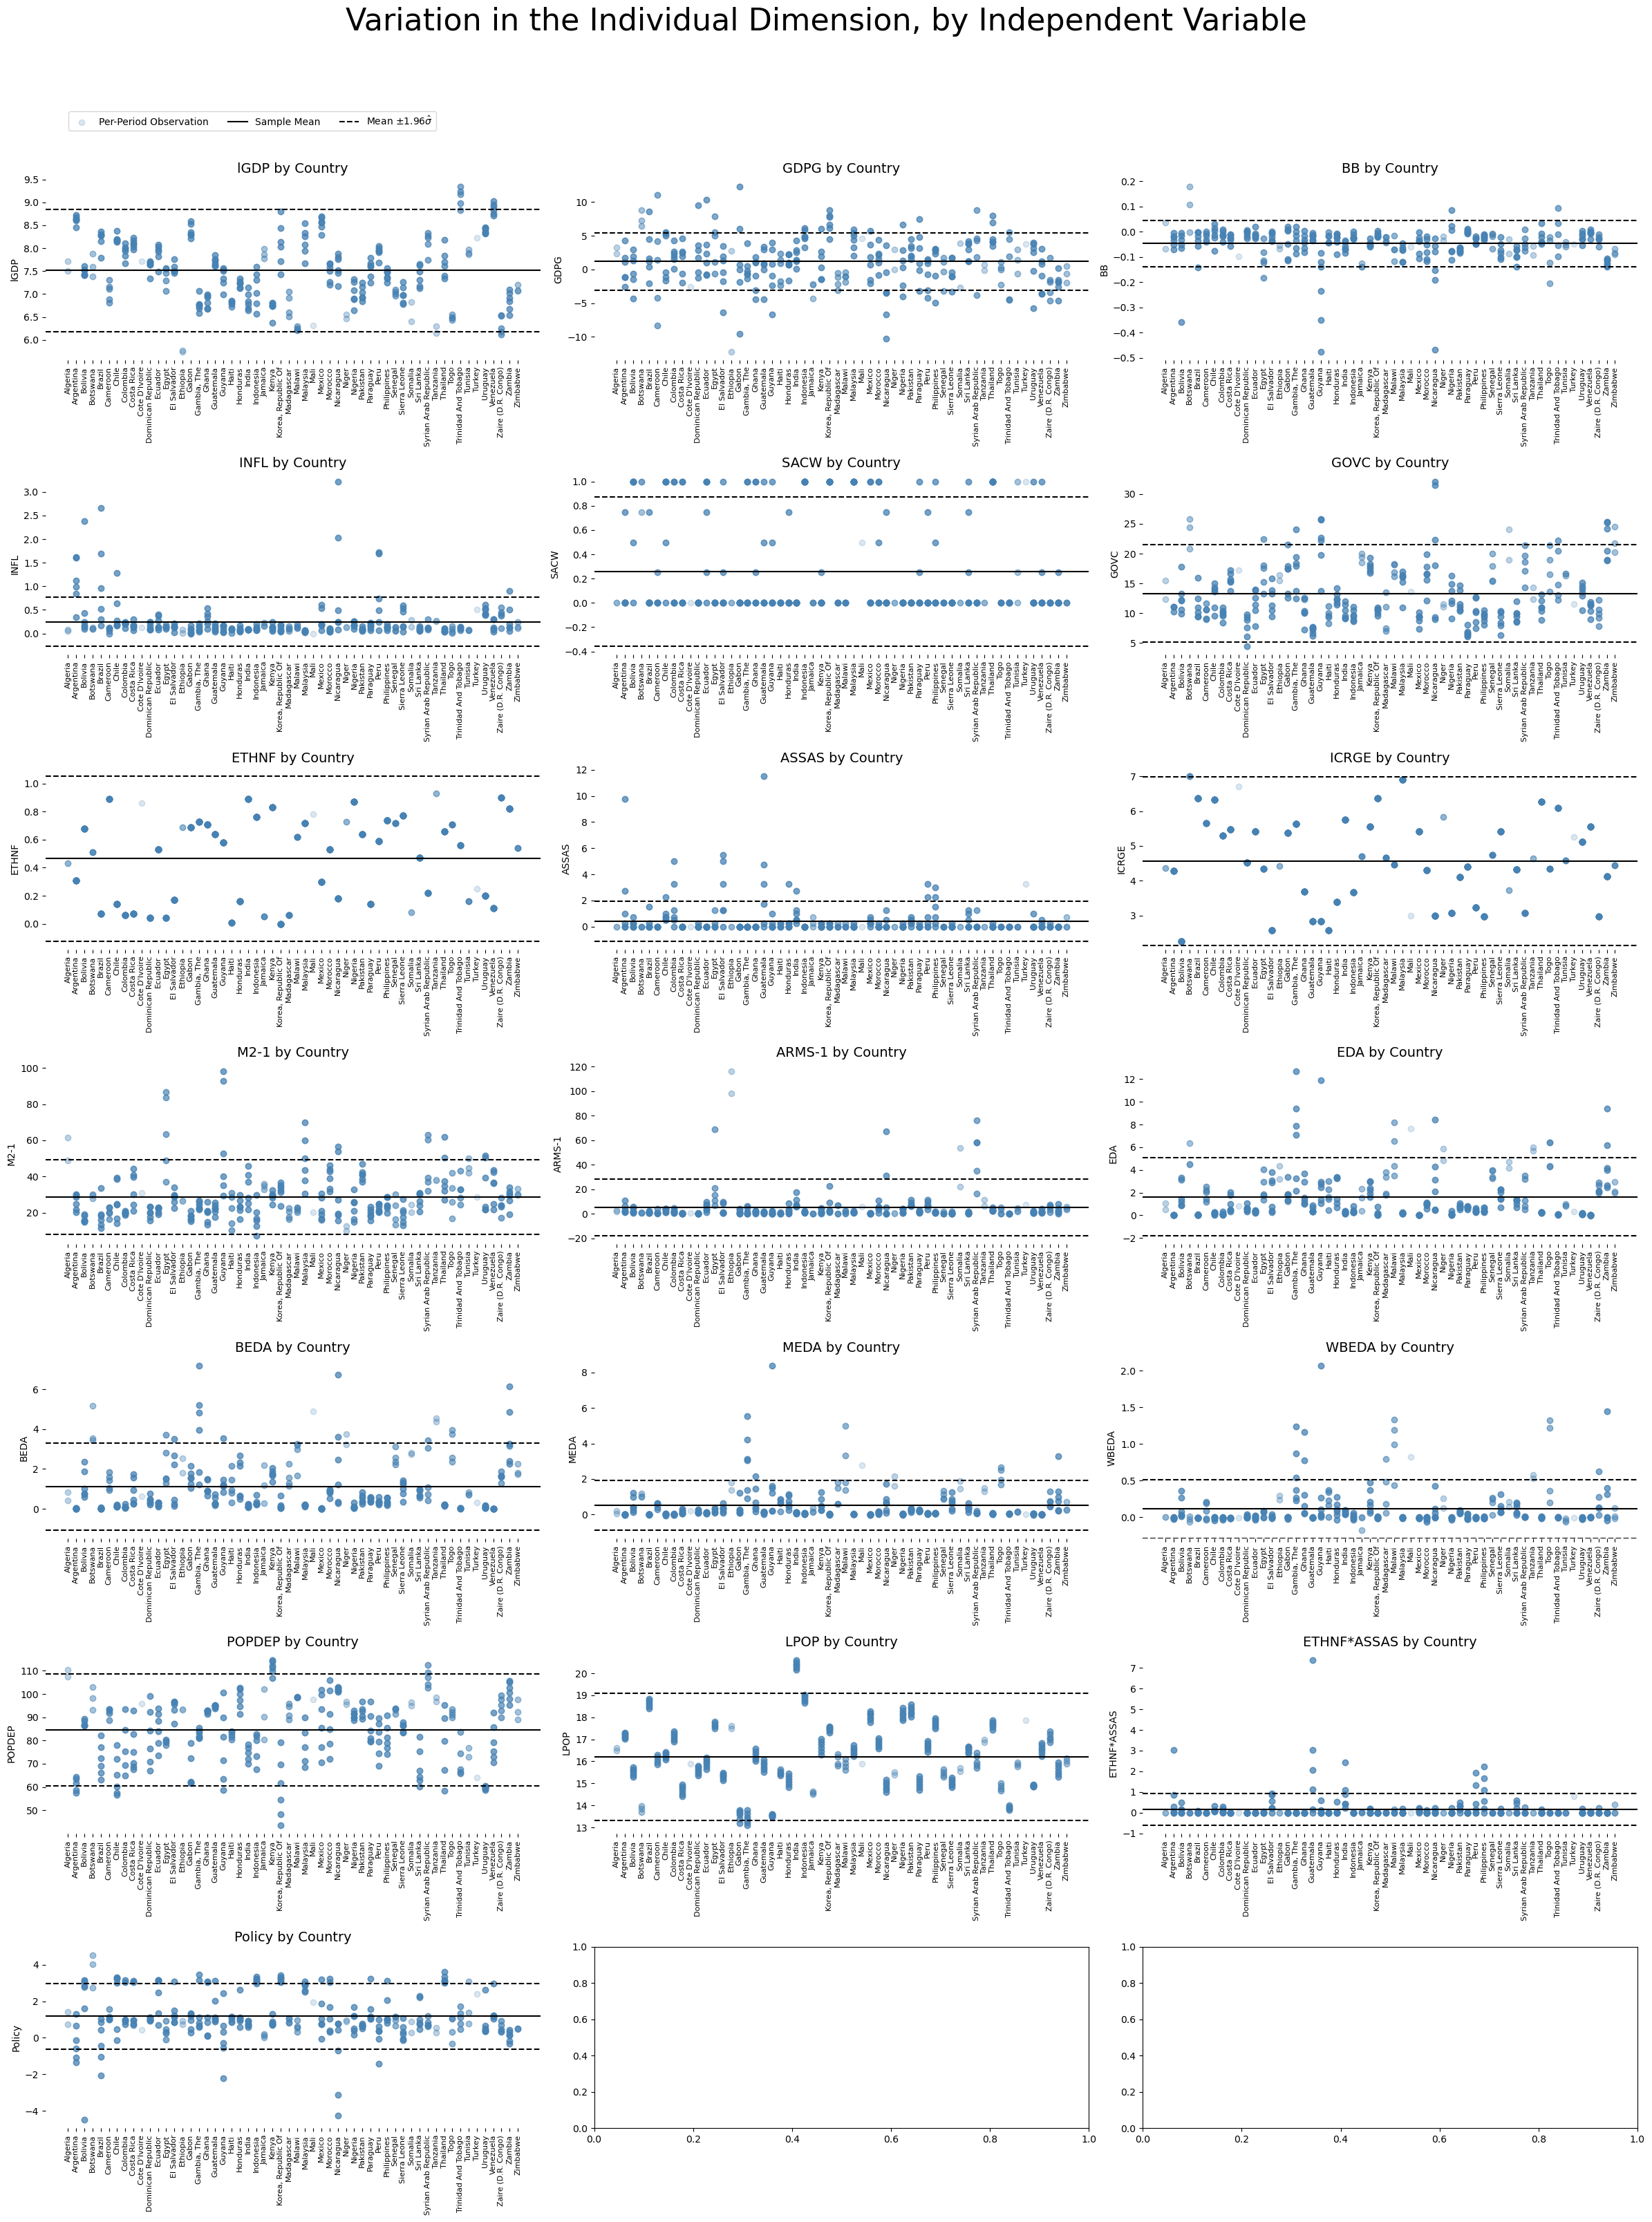

In [160]:
_df = df[X_vars].groupby('Country')
fig, axes = plt.subplots(7, 3, figsize=(8*3,30), dpi=100)

for var, axis in zip(X_vars, fig.axes):
    means = []
    
    for i, country in enumerate(df.index.get_level_values(0)):
        y = _df.get_group(country)[var]
        x = [country] * len(y)
        means.append(np.mean(y))
        if i == 0:
            axis.scatter(x, y, c='steelblue', alpha=0.2, label='Per-Period Observation')
        else:
            axis.scatter(x, y, c='steelblue', alpha=0.2)
        axis.tick_params(axis='x',
                      rotation=90,
                      labelsize=8)
    axis.set_ylabel(var)
    axis.set_title(f'{var} by Country', size=14)
    #axis.plot(df.index.get_level_values(0), means, color='red', lw=1, label='Per-Country Mean')
    axis.axhline(np.mean(means), ls='-', color='black', label='Sample Mean')
    axis.axhline(np.mean(means) + 1.96 * np.std(means), ls='--', color='black', label='Mean $\pm 1.96\hat{\sigma}$')
    axis.axhline(np.mean(means) - 1.96 * np.std(means), ls='--', color='black')
    for spine in axis.spines.values():
        spine.set_visible(False)
        
fig.tight_layout()
axis.legend(bbox_to_anchor=(0.8,11.15), ncol=3)
fig.suptitle('Variation in the Individual Dimension, by Independent Variable', y=1.07, fontsize=32)
plt.show()

This plot is useful to illustrate the bimodality of the distributions. We can see for the variables like assassinations and the aid variables the closeness of the datapoints to the x-axis. The bimodal distribution of ETHNF is visible, but it is more pronounced for the Sachs and Warner economic openess index. The bimodality did not appear too pronounced in the KDE plots, but here there is clear bimodality with the datapoints either being at 1 or 0 with a spatter in between.

### Time Variation

We now turn consideration to the time dimension. We average the values across the countries and examine the distribution over time.

In [161]:
df[X_vars].groupby('YEAR1').agg(np.nanmean).apply(np.nanvar).sort_values(ascending=False)

M2-1           23.364163
POPDEP         15.499967
ARMS-1          2.873560
GDPG            1.580609
GOVC            0.798574
EDA             0.225337
Policy          0.131846
BEDA            0.073519
MEDA            0.045440
LPOP            0.039729
SACW            0.033054
ASSAS           0.029814
INFL            0.008001
WBEDA           0.004742
lGDP            0.003576
ICRGE           0.002024
ETHNF*ASSAS     0.001992
ETHNF           0.000215
BB              0.000147
dtype: float64

The most variable is clearly the lag of money supply. This is a key component of monetary policy so we would expect this variable to vary with the business cycles. It would be very surprising if it had low variation. Population dependency's variation is more surprising. High population dependency is indicative of demographic change. We would expect this to be the case across countries, but across time is more surprising. The least variable is again the budget surplus. Ethnic fractionalisation is also very invariable over time, which to me seems at odds with the high variability of the population dependency.

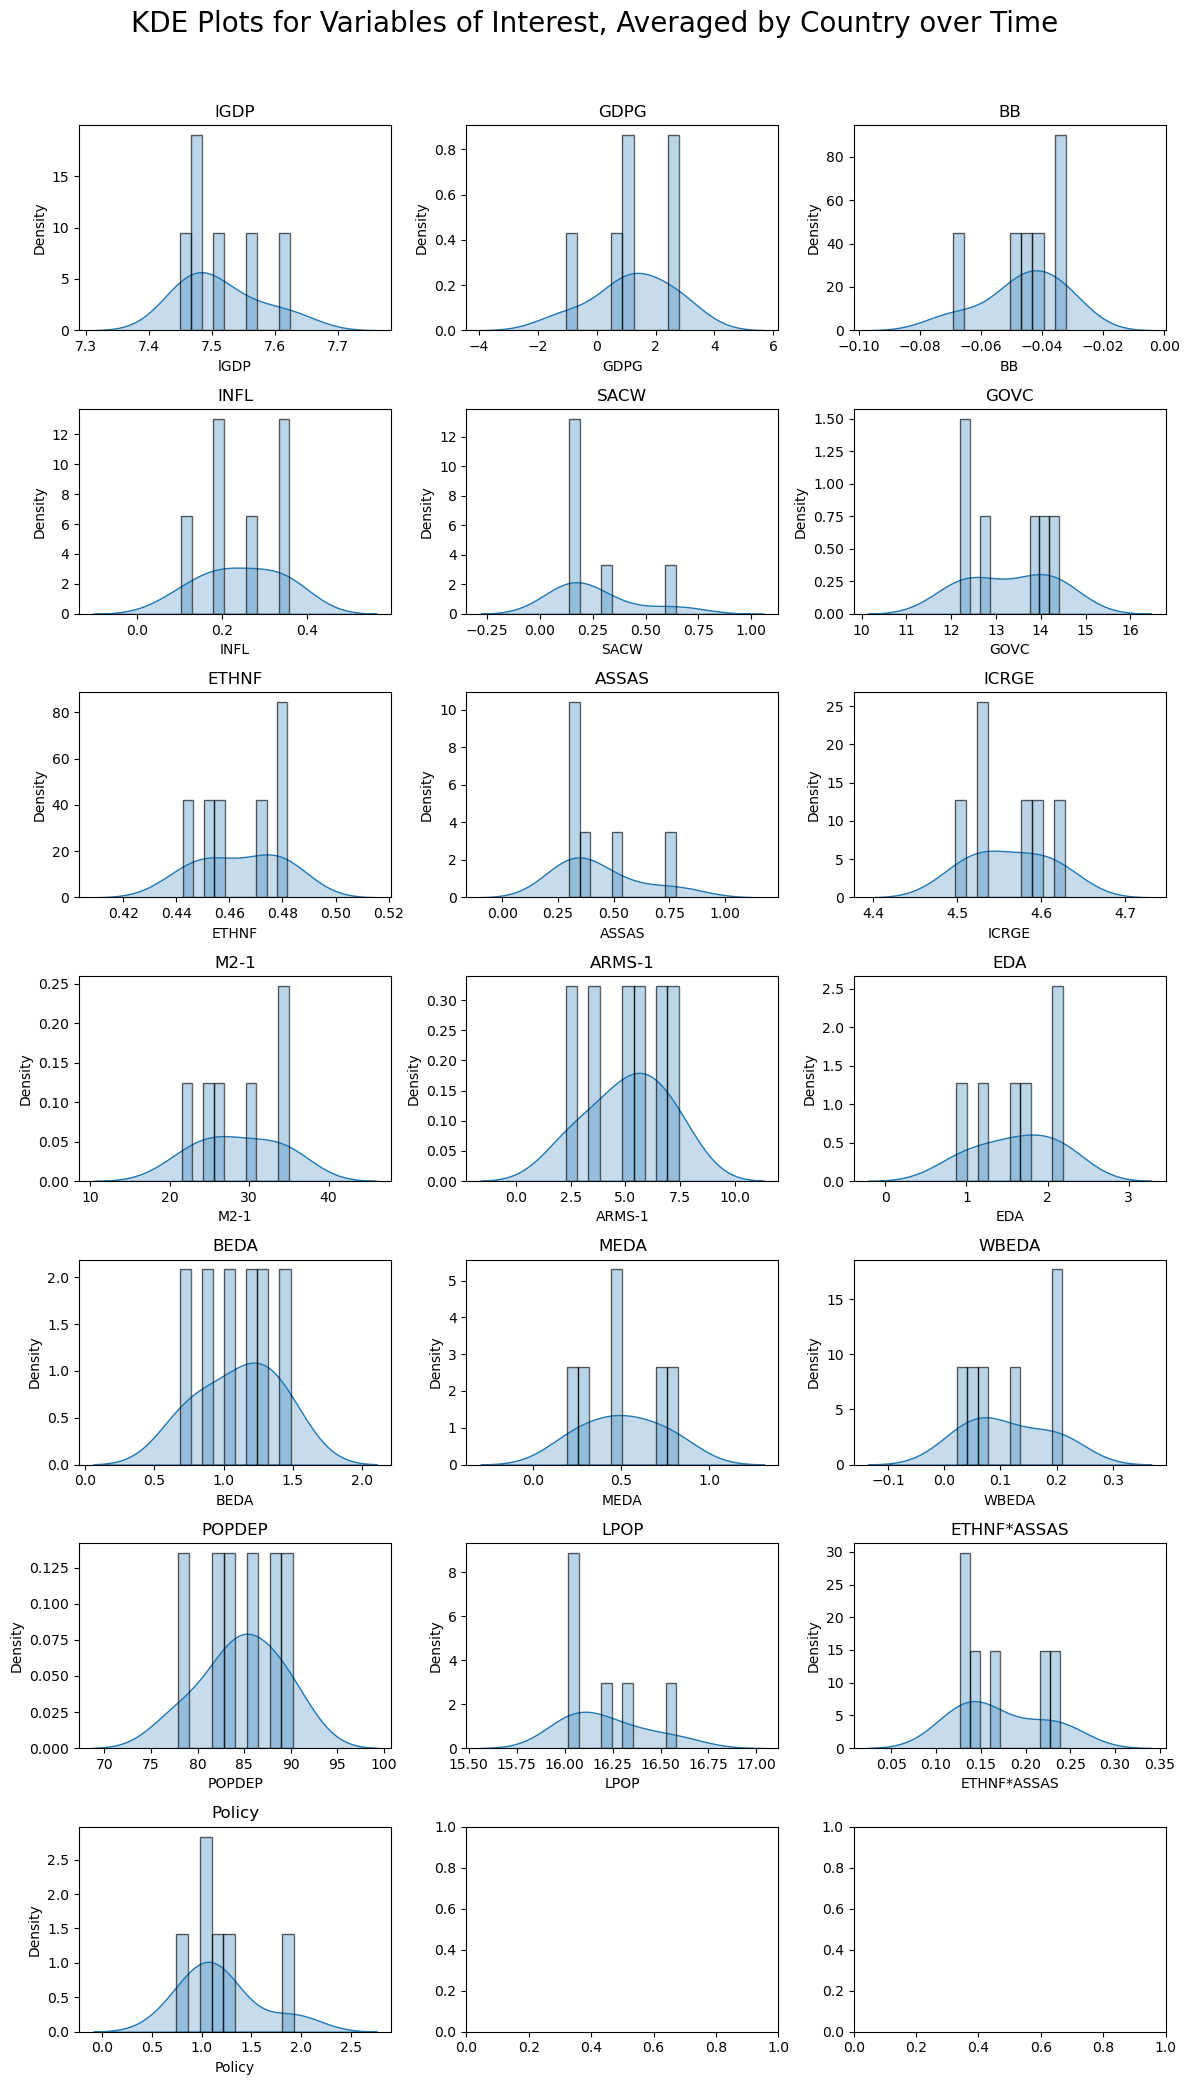

In [162]:

fig, ax = plt.subplots(7,3, figsize=(12,20), dpi=100)

for var, axis in zip(X_vars, fig.axes):
    data = df[var].groupby('YEAR1').agg(np.nanmean)
    g = sns.kdeplot(df[var].groupby('YEAR1').agg(np.nanmean), ax=axis, shade=True, legend=False)
    axis.hist(df[var].groupby('YEAR1').agg(np.nanmean), density=True, facecolor='Tab:Blue', edgecolor=None, 
             alpha=0.3)
    axis.hist(df[var].groupby('YEAR1').agg(np.nanmean), density=True, facecolor='None', edgecolor='black',
             alpha=0.6)
    axis.set_title(var)
fig.tight_layout()
fig.suptitle('KDE Plots for Variables of Interest, Averaged by Country over Time', size=20, y=1.04)
plt.show()

Turning our attention to the KDE plots there is clearly a lot of clustering taking place with the variables likely fuelled by discontinuity in the panel data structure. The Ethnic fractionalisation * assassinations term now appears bimodal, and none of the variables are normally distributed over time.

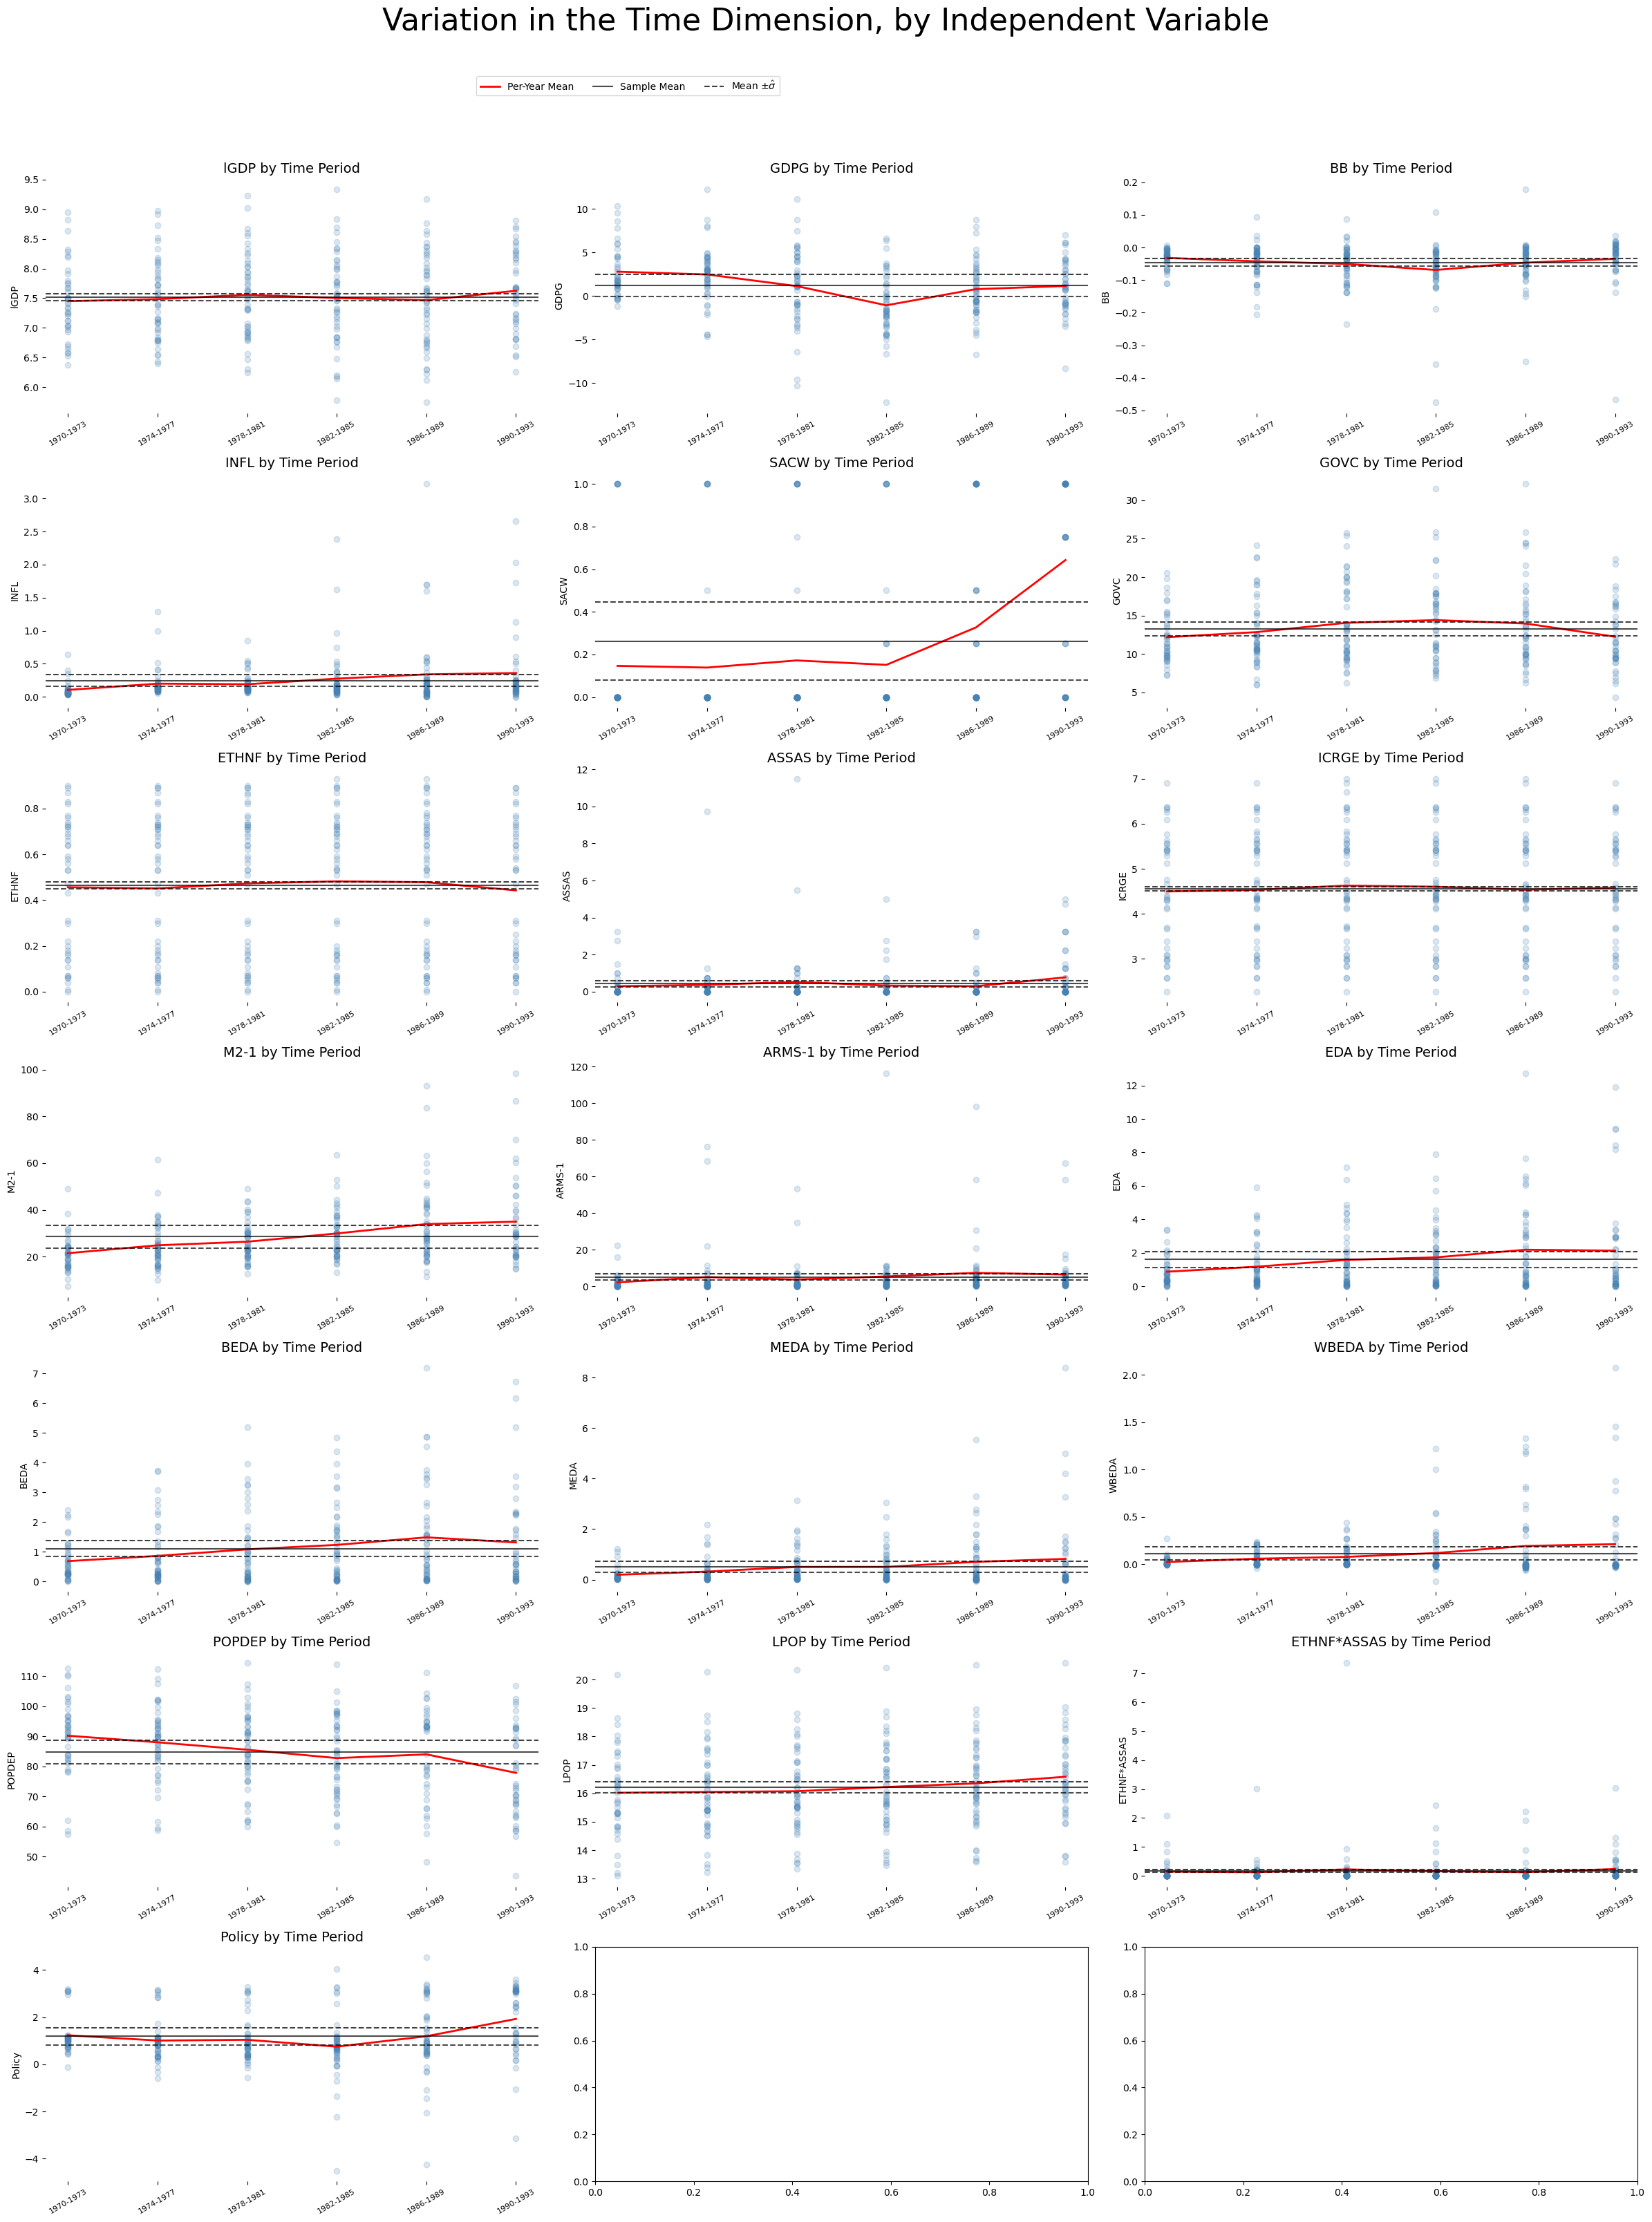

In [163]:
_df = df.groupby('YEAR1')

fig, axes = plt.subplots(7, 3, figsize=(8*3,30), dpi=100)
years = df.index.get_level_values(1).unique()

for i, (var, axis) in enumerate(zip(X_vars, fig.axes)):
    means = []
    for year in years:
        y = _df.get_group(year)[var]
        x = [year] * len(y)
        means.append(np.mean(y))
        if i == 0:
            axis.scatter(x, y, c='steelblue', alpha=0.2, label='Per-Country Observation')
        else:
            axis.scatter(x, y, c='steelblue', alpha=0.2)
        axis.tick_params(axis='x',
                      rotation=30,
                      labelsize=8)
    axis.set_ylabel(var)
    axis.set_title(f'{var} by Time Period', size=14)
    axis.plot(years, means, color='red', lw=2, label='Per-Year Mean')
    axis.axhline(np.mean(means), ls='-', color='black', label='Sample Mean', alpha=0.7)
    axis.axhline(np.mean(means) + np.std(means), ls='--', color='black', label='Mean $\pm \hat{\sigma}$', alpha=0.75)
    axis.axhline(np.mean(means) - np.std(means), ls='--', color='black', alpha=0.7)
    for spine in axis.spines.values():
        spine.set_visible(False)

for ax in axes[len(X_vars):]:
    ax.set_visible(False)
fig.tight_layout()
axis.legend(bbox_to_anchor=(1.5,9), ncol=3)
fig.suptitle('Variation in the Time Dimension, by Independent Variable', y=1.07, fontsize=32)

plt.show()

Here we can see the general trends of the variables. The variation in time for most of the variables is very flat, but the policy index shows a must higher variation in the 1982-1985 time period. 

# 2. What is the largest number of period T for individuals? What is the number of individuals?

In [164]:
line = ''
print(('Country' + ' '*16 + 'N Obs' + ' '*8) * 3)
print('='*100)
for country, count in zip(df.groupby('Country').size().index, df.groupby('Country').size()):
    text = country + ' '*(25-len(country)) + str(count) + ' '*10
    if len(line) < 100:
        line += text
    else:
        print(line)
        line = ''

Country                N Obs        Country                N Obs        Country                N Obs        
Algeria                  2          Argentina                6          Bolivia                  6          
Brazil                   6          Cameroon                 5          Chile                    6          
Costa Rica               6          Cote D'Ivoire            1          Dominican Republic       6          
Egypt                    5          El Salvador              6          Ethiopia                 2          
Gambia, The              6          Ghana                    6          Guatemala                6          
Haiti                    5          Honduras                 6          India                    6          
Jamaica                  3          Kenya                    6          Korea, Republic Of       6          
Malawi                   4          Malaysia                 6          Mali                     1          
Morocco            

In [165]:
grouped = df.groupby('Country').size()
largest_T = grouped.max()
number_of_individuals = grouped.count()

print("Largest number of periods (T) for any country:", largest_T)
print("Total number of countries (individuals):", number_of_individuals)

Largest number of periods (T) for any country: 6
Total number of countries (individuals): 56


The largest number of time periods for the countries is 6. There are a fair few countries that do have observations across the panel. Only three countries have only one observation: Cote D'Ivoire, Mali and Turkey.

# 3. Comment on the structure of the unbalanced panel (how many (and which) countries have a single observation, discontinuities between observations, how many have at least 2 consecutive observations (which is useful to compute lags, autocorrelations, first difference and within estimators)?

Examination of the top of the dataset indicates that Algeria has only two observations: 1970-1973 and 1974-1977. We will use Algeria as a reference to make sure that the panel data plots are correct.

In [166]:
df.head()

GDPG     GDP        BB      INFL  SACW       GOVC  \
Country   YEAR1                                                              
Algeria   1970-1973  2.386265  1826.0 -0.068337  0.046413   0.0  15.471668   
          1974-1977  3.236684  2256.0  0.036605  0.082093   0.0  12.345353   
Argentina 1970-1973  1.700300  5637.0 -0.021146  0.340886   0.0  10.194982   
          1974-1977  1.077615  6168.0 -0.069117  0.989960   0.0  11.044480   
          1978-1981 -1.115285  5849.0 -0.033950  0.844831   0.0  11.086979   

                     ETHNF  ASSAS     ICRGE       M2-1  SSA  EASIA       LPOP  \
Country   YEAR1                                                                 
Algeria   1970-1973   0.43   0.00  4.364583  49.102671    0      0  16.482732   
          1974-1977   0.43   0.00  4.364583  61.462472    0      0  16.605724   
Argentina 1970-1973   0.31   2.75  4.281250  24.824762    0      0  17.017208   
          1974-1977   0.31   9.75  4.281250  28.793040    0      0  17.082911   
          1978-1981   0.31   1.00  4.281250  30.234517    0      0  17.144003   

                     EGYPT  CENTAM  FRZ  ARMS-1  DN1900       EDA      BEDA  \
Country   YEAR1                                                               
Algeria   1970-1973    0.0     0.0  0.0   2.967       0  1.032286  0.842784   
          1974-1977    0.0     0.0  0.0   1.950       0  0.500887  0.433937   
Argentina 1970-1973    0.0     0.0  0.0   2.033       1  0.018239  0.016755   
          1974-1977    0.0     0.0  0.0   1.725       1  0.017155  0.016532   
          1978-1981    0.0     0.0  0.0   1.075       1  0.023994  0.019493   

                         MEDA     WBEDA      POPDEP  year_3  year_4  year_5  \
Country   YEAR1                                                               
Algeria   1970-1973  0.189503  0.000000  110.482000       0       0       0   
          1974-1977  0.066950  0.001251  107.439000       1       0       0   
Argentina 1970-1973  0.001484 -0.000961   57.374800       0       0       0   
          1974-1977  0.000623 -0.002459   58.844350       1       0       0   
          1978-1981  0.004501 -0.002057   61.571267       0       1       0   

                     year_6  year_7  ETHNF*ASSAS      lGDP  Constant    Policy  
Country   YEAR1                                                                 
Algeria   1970-1973       0       0       0.0000  7.509883         1  0.745237  
          1974-1977       0       0       0.0000  7.721349         1  1.413676  
Argentina 1970-1973       0       0       0.8525  8.637107         1  0.656556  
          1974-1977       0       0       3.0225  8.727130         1 -0.579265  
          1978-1981       0       0       0.3100  8.674026         1 -0.135645

In [167]:
pivot = df.pivot_table(index='Country', columns='YEAR1', aggfunc='size')
panel_data = pd.DataFrame(pivot)


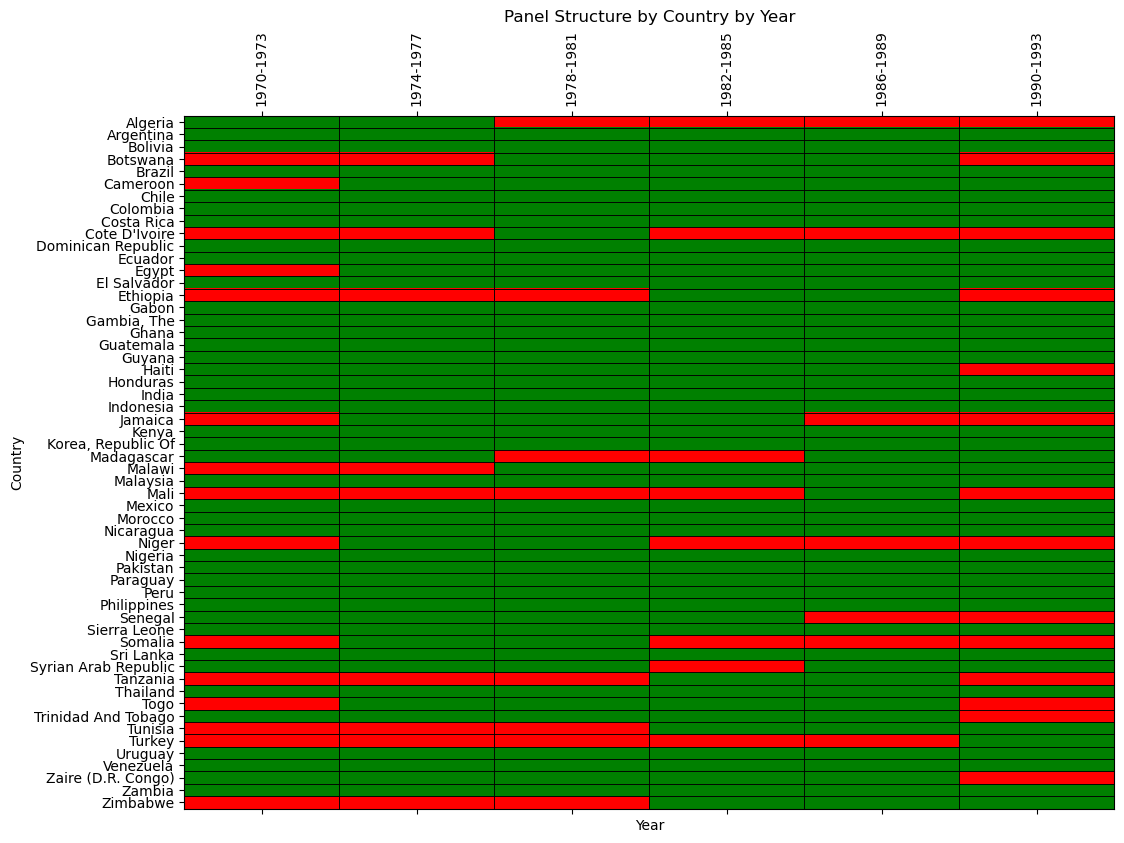

In [168]:
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize=(12, 9))
cax = ax.matshow(panel_data.notnull(), aspect='auto', cmap = ListedColormap(['red', 'green']))

for (i, j), val in np.ndenumerate(panel_data.notnull()):
    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='black', lw=0.5))

ax.set_yticks(np.arange(len(panel_data.index)))
ax.set_yticklabels(panel_data.index)
ax.set_xticks(np.arange(len(panel_data.columns)))
ax.set_xticklabels(panel_data.columns, rotation=90)

ax.set_xlabel('Year')
ax.set_ylabel('Country')
ax.set_title('Panel Structure by Country by Year')

plt.show()


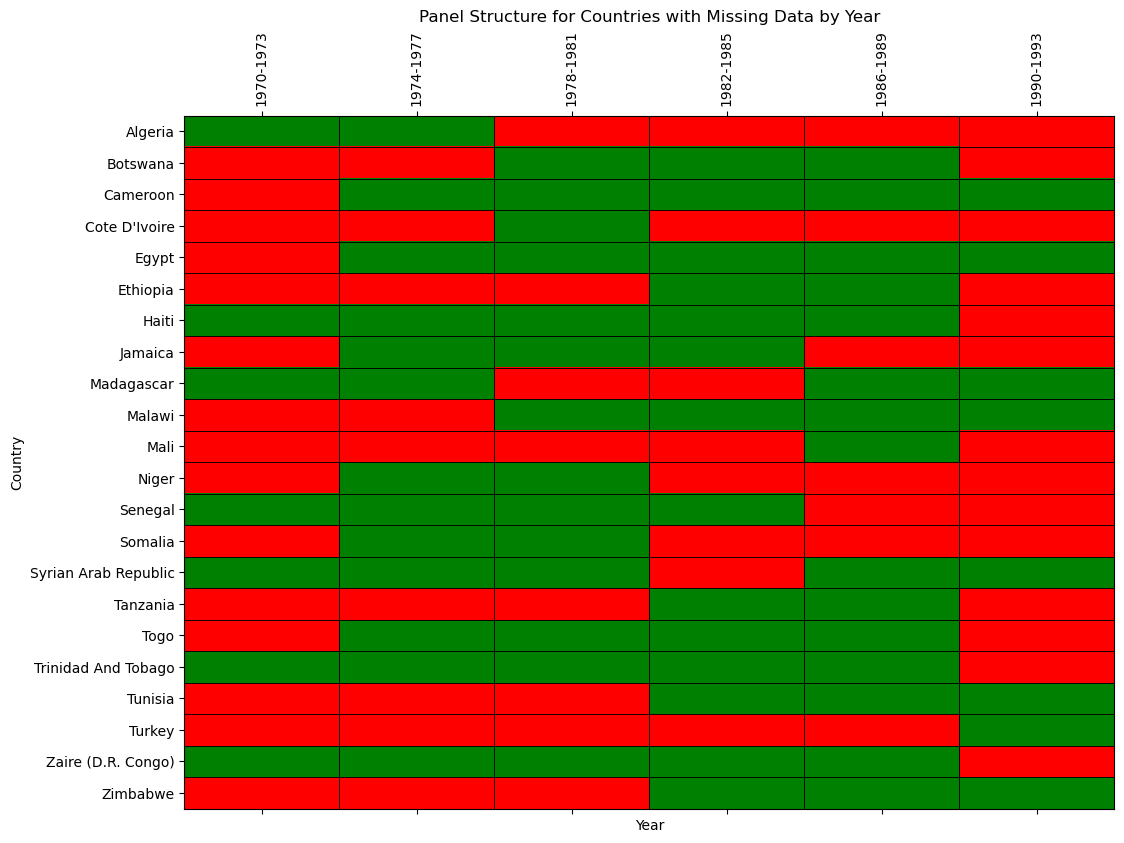

In [169]:
countries_with_missing = panel_data[panel_data.isnull().any(axis=1)]

fig, ax = plt.subplots(figsize=(12, 9))
cmap = ListedColormap(['red', 'green'])  # Red for absence, green for presence
cax = ax.matshow(countries_with_missing.notnull(), aspect='auto', cmap=cmap)

for (i, j), val in np.ndenumerate(countries_with_missing.notnull()):
    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='black', lw=0.5))

ax.set_yticks(np.arange(len(countries_with_missing.index)))
ax.set_yticklabels(countries_with_missing.index)
ax.set_xticks(np.arange(len(countries_with_missing.columns)))
ax.set_xticklabels(countries_with_missing.columns, rotation=90)

ax.set_xlabel('Year')
ax.set_ylabel('Country')
ax.set_title('Panel Structure for Countries with Missing Data by Year')

plt.show()


As mentioned above, Cote D'Ivoire, Mali and Turkey have only one observation and so must be excluded from any investigation involving lags, first differences, within estimators etc.
Aside from these countries, all other countries (53) have at least two consecutive observations. However, some of these have discontinuities in their observations and so will have missing observations should we calculate lags. These countries are Syrian Arab Republic (which has a gap in 1982) and Madagascar (which has a gap between 1978 and 1985 - two time periods). 24 countries have 6 observations.

# 4. Compute between transformed and one-way-within transformed variables for all variables. Present a table with the one-way-within-fixed-effects, between and pooled variance for each variable. Compute the share of between and within variance in the total variance for each variable. Comment these results.

The between transformation subtracts the entity mean from the overall mean for a given variable: 
$$
\bar{x}_i - \bar{x}
$$
The one-way within fixed effects subtracts the value of x for a given entity and time from the entity's average:
$$
x_{i,t} - \bar{x}_i
$$
The overall deviation is similar to the within, but subtracts the value of x for an entity and time period from the overall average of x over both time and countries:
$$
x_{i,t} - \bar{x}
$$

In [170]:
between_transformed = df.groupby(level=0)[X_vars].mean()
df_with_index = df.reset_index(level=1, drop=True)
within_transformed = df[X_vars] - df.groupby(level=0)[X_vars].transform('mean')

pooled_variance = df[X_vars].var()
variance_table = pd.DataFrame(index=X_vars, columns=['Between', 'Within', 'Pooled', 'Share of Between', 'Share of Within'])

for var in X_vars:
    between_var = between_transformed[var].var()
    within_var = within_transformed[var].var()
    total_var = pooled_variance[var]
    
    variance_table.loc[var, 'Between'] = between_var
    variance_table.loc[var, 'Within'] = within_var
    variance_table.loc[var, 'Pooled'] = total_var
    variance_table.loc[var, 'Share of Between'] = between_var / total_var
    variance_table.loc[var, 'Share of Within'] = within_var / total_var

variance_table


Between     Within      Pooled Share of Between  \
lGDP            0.52734   0.030688    0.492226         1.071337   
GDPG           5.685945   8.132692   12.952067         0.438999   
BB             0.002207   0.002098    0.004307         0.512478   
INFL           0.062713    0.08588    0.156152         0.401613   
SACW           0.104591   0.074354    0.173519         0.602765   
GOVC           18.20251   5.649455   23.167835          0.78568   
ETHNF          0.092315        0.0    0.090386         1.021343   
ASSAS          0.657545    0.91069    1.526128         0.430858   
ICRGE            1.5026        0.0    1.529139         0.982645   
M2-1          117.84003   63.59052  176.295853         0.668422   
ARMS-1        261.65936  37.510476  177.105877         1.477418   
EDA            3.944023   1.202634    4.281359         0.921208   
BEDA            1.64023   0.438084    1.701804         0.963819   
MEDA           0.631242   0.328614    0.848606         0.743857   
WBEDA          0.054008   0.034838    0.076714         0.704023   
POPDEP       157.079285  41.415367  194.851677         0.806148   
LPOP           2.012215   0.025969    2.203456         0.913209   
ETHNF*ASSAS    0.140386   0.208909    0.365449         0.384148   
Policy           0.8513    0.73587     1.59162         0.534864   

            Share of Within  
lGDP               0.062346  
GDPG               0.627907  
BB                 0.487097  
INFL                0.54998  
SACW               0.428506  
GOVC               0.243849  
ETHNF                   0.0  
ASSAS              0.596733  
ICRGE                   0.0  
M2-1               0.360703  
ARMS-1             0.211797  
EDA                  0.2809  
BEDA               0.257423  
MEDA               0.387239  
WBEDA              0.454124  
POPDEP             0.212548  
LPOP               0.011785  
ETHNF*ASSAS         0.57165  
Policy              0.46234

The share of between variance is higher than the share of within variance in all cases. We can see that some variables like ETHNF and ICRGE have 0 variance 'within'. This is because they do not vary over time and have remained constant for each country. There are a few variables where there is a greater within share than between share: GDPG, INFL, ASSAS, ETHNF*ASSAS. This means that the overall variance in these variables is more because of country specific factors. On the contrary, the remaining variable where there is a greater between variation than within suggests that the variance of these variable is fuelled mainly by factors shared by all countries.

# 5. Plot the distribution of the one-way-fixed-effects-within (x(it)-x(i.)) and between (x(i.)) transformed dependent variable and of you key (preferred) explanatory variable (not all the explanatory variable) [in Burnside and Dollar: GDP growth and foreign aid EDA/GDP], using on the same graph an histogram, a normal law with same empirical mean and standard error and a kernel continuous approximation. Comment the between and within difference for each variable, and compare within/within for dependent and explanatory variable, and between/between for dependent and explanatory variable: kurtosis, skewness, non-normality, high leverage observation (far from the mean), several modes (mixture of distribution)?

Here we plot only for the Burnside and Dollar explanatory variables of GDPG (GDP growth) and EDA (which is effective aid).

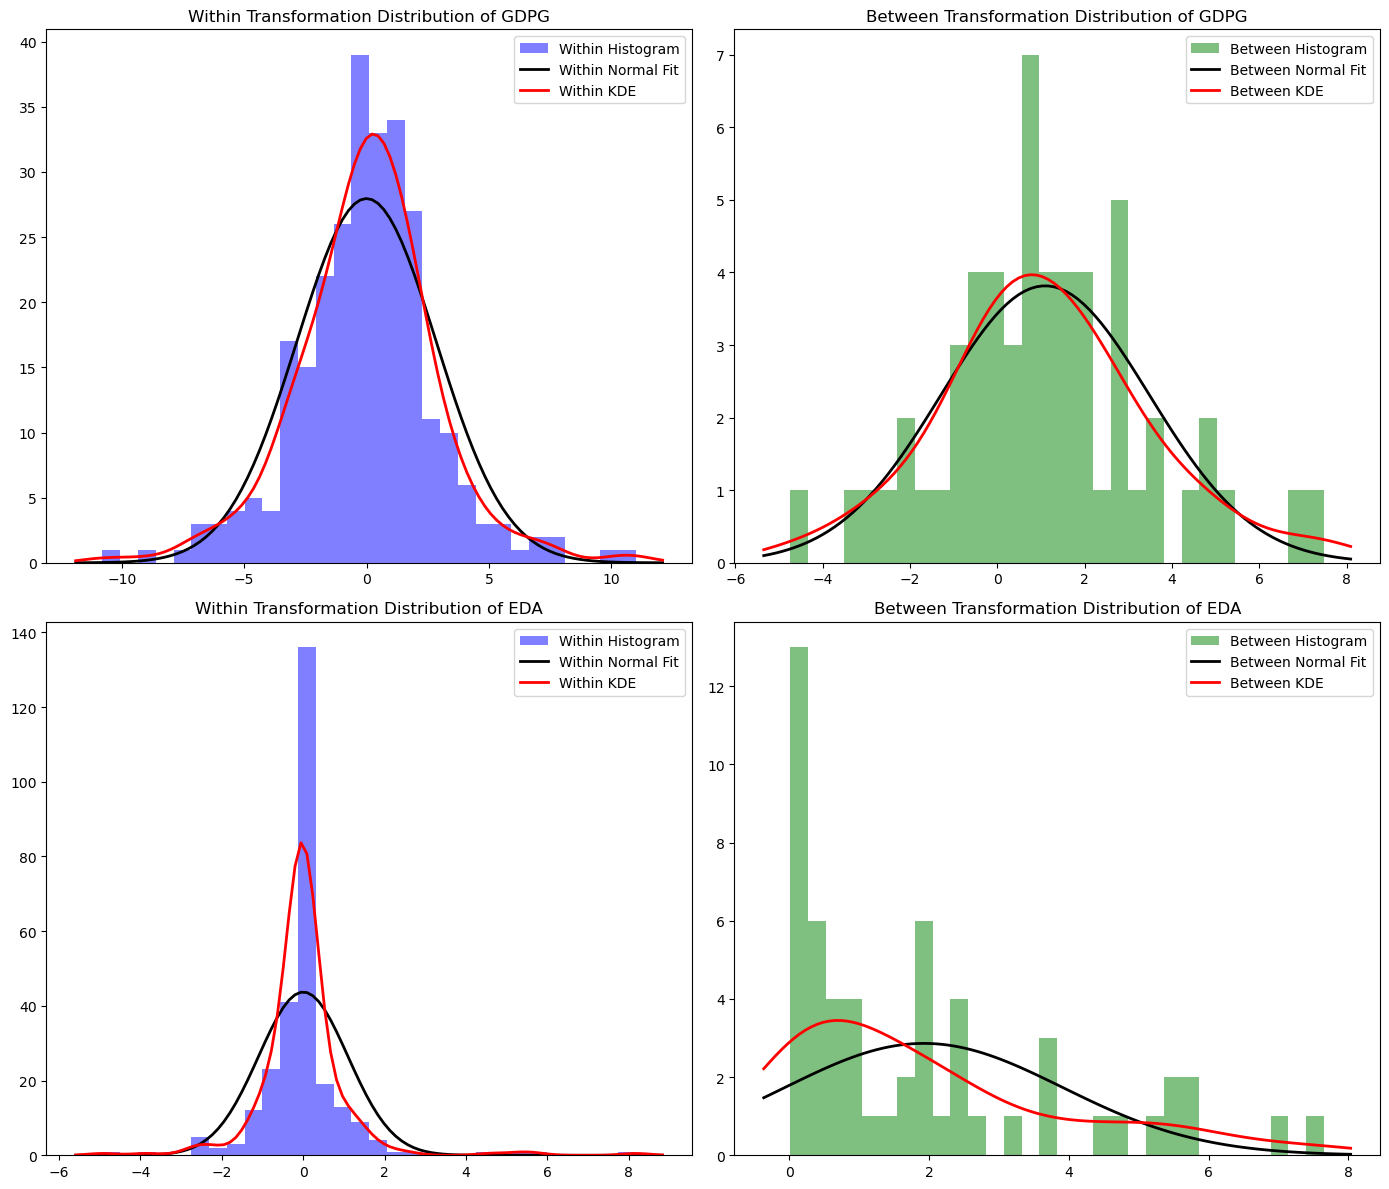

In [171]:
from scipy.stats import norm, gaussian_kde
from matplotlib.colors import ListedColormap

variables = ['GDPG', 'EDA']

within_transform = df.groupby('Country')[variables].transform(lambda x: x - x.mean())

between_transform = df.groupby('Country')[variables].mean()

fig, axs = plt.subplots(len(variables), 2, figsize=(14, 6 * len(variables)))

for i, var in enumerate(variables):
    x_within = within_transform[var].dropna()
    x_within_mean, x_within_std = x_within.mean(), x_within.std()
    x_between = between_transform[var].dropna()
    x_between_mean, x_between_std = x_between.mean(), x_between.std()
    n, bins, patches = axs[i, 0].hist(x_within, bins=30, alpha=0.5, color='blue', label='Within Histogram')
    bin_width = np.diff(bins)[0]
    scale_factor = len(x_within) * bin_width
    xmin, xmax = axs[i, 0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, x_within_mean, x_within_std) * scale_factor
    axs[i, 0].plot(x, p, 'k', linewidth=2, label='Within Normal Fit')
    kde = gaussian_kde(x_within)
    axs[i, 0].plot(x, kde(x) * scale_factor, 'r', linewidth=2, label='Within KDE')
    n, bins, patches = axs[i, 1].hist(x_between, bins=30, alpha=0.5, color='green', label='Between Histogram')
    bin_width = np.diff(bins)[0]
    scale_factor = len(x_between) * bin_width
    xmin, xmax = axs[i, 1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, x_between_mean, x_between_std) * scale_factor
    axs[i, 1].plot(x, p, 'k', linewidth=2, label='Between Normal Fit')
    kde = gaussian_kde(x_between)
    axs[i, 1].plot(x, kde(x) * scale_factor, 'r', linewidth=2, label='Between KDE')
    axs[i, 0].set_title(f'Within Transformation Distribution of {var}')
    axs[i, 1].set_title(f'Between Transformation Distribution of {var}')
    axs[i, 0].legend()
    axs[i, 1].legend()
plt.tight_layout()
plt.show()


In [172]:
from scipy.stats import skew, kurtosis
def print_statistics(df, variable_name):
    mean = df[variable_name].mean()
    std = df[variable_name].std()
    skewness = stats.skew(df[variable_name])
    kurtosis_value = kurtosis(df[variable_name], fisher=False)

    print(f"Variable {variable_name}:")
    print(f"Mean: {mean}")
    print(f"Standard Deviation: {std}")
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurtosis_value}")


print("Within Transformation Statistics:")
print_statistics(within_transform, 'EDA')
print("\n")
print_statistics(within_transform, 'GDPG')
print("=" * 50)
print("\nBetween Transformation Statistics:")
print_statistics(between_transform, 'EDA')
print("\n")
print_statistics(between_transform, 'GDPG')


Within Transformation Statistics:
Variable EDA:
Mean: -2.7452787518003872e-17
Standard Deviation: 1.0966467346246704
Skewness: 2.0457148086017103
Kurtosis: 20.2533913547509


Variable GDPG:
Mean: 2.9875092299004214e-17
Standard Deviation: 2.851787542504866
Skewness: 0.01404539049353257
Kurtosis: 4.999790868953414

Between Transformation Statistics:
Variable EDA:
Mean: 1.9230614717070895
Standard Deviation: 1.9859564317367242
Skewness: 1.175804853896304
Kurtosis: 3.4855824664761066


Variable GDPG:
Mean: 1.0975418292953496
Standard Deviation: 2.384521999302136
Skewness: 0.2740550298256311
Kurtosis: 3.5246544618962994


The distribution that appears to be the closest to normal is the between transformation of GDP growth. The mean is close to 1 and the skewness is almost 0. All variables with both transformations are leptokurtic. The within EDA is the most leptokuritc with a kurtosis of 20.25. The rule of thumb for kurtosis of 3 and indeed GDPG between is 3.52 so very close to the normal. The least skewed variable is the within transformation of GDPG with a snewness of 0.014.

The between transformation of EDA reminds us of many of the patterns we observed in question 1 with most the distribution heavily concentrated around 0, making the distribution positively skewed (1.17). Interestingly, the mean of within transformed EDA is very close to 0 which suggests that while countries' equilibrium levels of growth differ, they tend to be close to their average over time. 

## High Leverage

High leverage points are observations multiple standard deviations different from the mean ($\mu ± i\sigma$).

In [173]:
import re
import itertools
overall = df[X_vars] - df[X_vars].mean()
between = df[X_vars].groupby('Country').agg(np.nanmean)
within = df[X_vars].groupby('Country').transform(lambda x: x - x.mean())
vars_to_plot = ['GDPG', 'EDA']
estimators = [('Within', within), ('Between', between)]
within = df[X_vars].groupby('Country').transform(lambda x: x - x.mean())

print('*'*100)
print(f'Number of σ from the mean for selected varaibles, for all x > μ +/- σ')
print('*'*100)

combos = itertools.product(vars_to_plot, estimators)
for v, (name, estimator) in combos:
    μ = estimator[v].mean()
    σ = estimator[v].std()
    print(v + ' - ' + name)
    print('='*110)
    if name == 'Within':
        header = ('Country' + ' '*(15) + 'Year' + ' '*13 + '(x - μ) / σ' + ' '*7) * 2
    else:
        header = ('Country' + ' '*(13) + '(x - μ) / σ' + ' '*7) * 3
    print(header)
    print('='*110)
    line = ''
    temp = (estimator[v].apply(abs) - abs(μ)) / σ
    temp = temp.sort_values(ascending=False)
    for s in temp[temp > 1.96].index:
        sign = estimator[v][s] / abs(estimator[v][s]) 
        if isinstance(s, tuple):
            to_print = s[0].strip() + ' '*(22-len(s[0])) + s[1]
            to_print += ' ' * (22 - len(to_print)) 
            if sign < 0:
                to_print += ' ' * 9
            else: to_print += ' ' * 10
            to_print += f'{temp[s] * sign:0.4f}' + ' '*10

        elif isinstance(s, str):
            to_print = s + ' ' * (22 - len(s))
            
            if sign > 0:
                to_print += ' ' 
            to_print += f'{temp[s] * sign:0.4f}' + ' '*10

        if len(line + to_print) < 120:
            line = line + to_print
        else:
            print(line)
            line = to_print
    print(line)
    print('\n')

****************************************************************************************************
Number of σ from the mean for selected varaibles, for all x > μ +/- σ
****************************************************************************************************
GDPG - Within
Country               Year             (x - μ) / σ       Country               Year             (x - μ) / σ       
Gabon                 1974-1977          3.8605          Gabon                 1978-1981         -3.7859          
Cameroon              1978-1981          3.5997          Cameroon              1990-1993         -3.2035          
Ecuador               1970-1973          2.6953          Ethiopia              1982-1985         -2.6186          
Ethiopia              1986-1989          2.6186          Nicaragua             1974-1977          2.4571          
Uruguay               1982-1985         -2.4569          Syrian Arab Republic  1986-1989         -2.4519          
Dominican Republic    19

There are a few outliers for the between transformations. There is nothing beyond three standard deviations from the mean and EDA has more observations more than one standard deviation from the mean than GDPG. We also see the within transformations having vastly more observations more than one standard deviation from the mean than between. This is certainly to be expected given that the Kurtosis, particularly for EDA, is much higher than for the between. For GDPG's within, we see Gabon in 1974-1977 having an observation almost 4 standard deviations from the mean. For EDA it is even more severe, with Guyana having an observation in 1990-1993 almost 7 and a half standard deviations from the mean.

# 6. Compute first-differences and two-way-fixed-effects (x(it)-x(i.)-x(.t)+x(..)) transformed variables (these two transformations eliminate deterministic trend, to be checked in correlation matrix). For first-differences for panel data, check that when you change individual, the first observation is missing with a dot, and it is not the difference of the first observation of the second individual minus the last observation of the first individual, for example. Plot the distribution for dependent GDPG and explanatory EDA/GDP for each of these two transformations. Compare with one-way-fixed effects and between distributions.

In [174]:
from scipy.stats import gaussian_kde


X_vars = ['lGDP', 'GDPG', 'BB', 'INFL', 'SACW', 'GOVC', 'ETHNF', 'ASSAS', 'ICRGE', 'M2-1', 'ARMS-1', 'EDA', 'BEDA', 'MEDA',
          'WBEDA', 'POPDEP', 'LPOP', 'ETHNF*ASSAS', 'Policy']
pre_diff_var = []
vars_to_diff = [var for var in X_vars if var not in pre_diff_var]

df_first_diff = df.copy()
for var in vars_to_diff:
    df_first_diff[var] = df.groupby('Country')[var].diff()
df_first_diff.dropna(inplace=True)



In [175]:
df_first_diff.head()

GDPG     GDP        BB      INFL  SACW      GOVC  \
Country   YEAR1                                                             
Algeria   1974-1977  0.850419  2256.0  0.104941  0.035681   0.0 -3.126315   
Argentina 1974-1977 -0.622685  6168.0 -0.047971  0.649073   0.0  0.849498   
          1978-1981 -2.192900  5849.0  0.035167 -0.145128   0.0  0.042500   
Bolivia   1974-1977  1.665759  1838.0 -0.019711  0.068736   0.0  0.679886   
          1978-1981 -4.448338  2015.0 -0.011588  0.064507  -0.5  2.649355   

                     ETHNF  ASSAS  ICRGE       M2-1  SSA  EASIA      LPOP  \
Country   YEAR1                                                             
Algeria   1974-1977    0.0   0.00    0.0  12.359801    0      0  0.122992   
Argentina 1974-1977    0.0   7.00    0.0   3.968278    0      0  0.065703   
          1978-1981    0.0  -8.75    0.0   1.441477    0      0  0.061092   
Bolivia   1974-1977    0.0  -0.75    0.0   0.618742    0      0  0.097047   
          1978-1981    0.0   0.25    0.0   0.072805    0      0  0.094003   

                     EGYPT  CENTAM  FRZ  ARMS-1  DN1900       EDA      BEDA  \
Country   YEAR1                                                               
Algeria   1974-1977    0.0     0.0  0.0  -1.017       0 -0.531399 -0.408847   
Argentina 1974-1977    0.0     0.0  0.0  -0.308       1 -0.001083 -0.000222   
          1978-1981    0.0     0.0  0.0  -0.650       1  0.006839  0.002960   
Bolivia   1974-1977    0.0     0.0  0.0  -2.533       0  0.004669 -0.144777   
          1978-1981    0.0     0.0  0.0  -0.650       0  0.315823  0.179023   

                         MEDA     WBEDA    POPDEP  year_3  year_4  year_5  \
Country   YEAR1                                                             
Algeria   1974-1977 -0.122553  0.001251 -3.043000       1       0       0   
Argentina 1974-1977 -0.000861 -0.001498  1.469550       1       0       0   
          1978-1981  0.003878  0.000402  2.726917       0       1       0   
Bolivia   1974-1977  0.149445  0.067173 -0.034200       1       0       0   
          1978-1981  0.136800 -0.047787 -0.145217       0       1       0   

                     year_6  year_7  ETHNF*ASSAS      lGDP  Constant    Policy  
Country   YEAR1                                                                 
Algeria   1974-1977       0       0       0.0000  0.211466         1  0.668440  
Argentina 1974-1977       0       0       2.1700  0.090023         1 -1.235821  
          1978-1981       0       0      -2.7125 -0.053104         1  0.443619  
Bolivia   1974-1977       0       0      -0.5100  0.101258         1 -0.231017  
          1978-1981       0       0       0.1700  0.091941         1 -1.247810

Indeed the first observation no longer exists because we first-differenced.

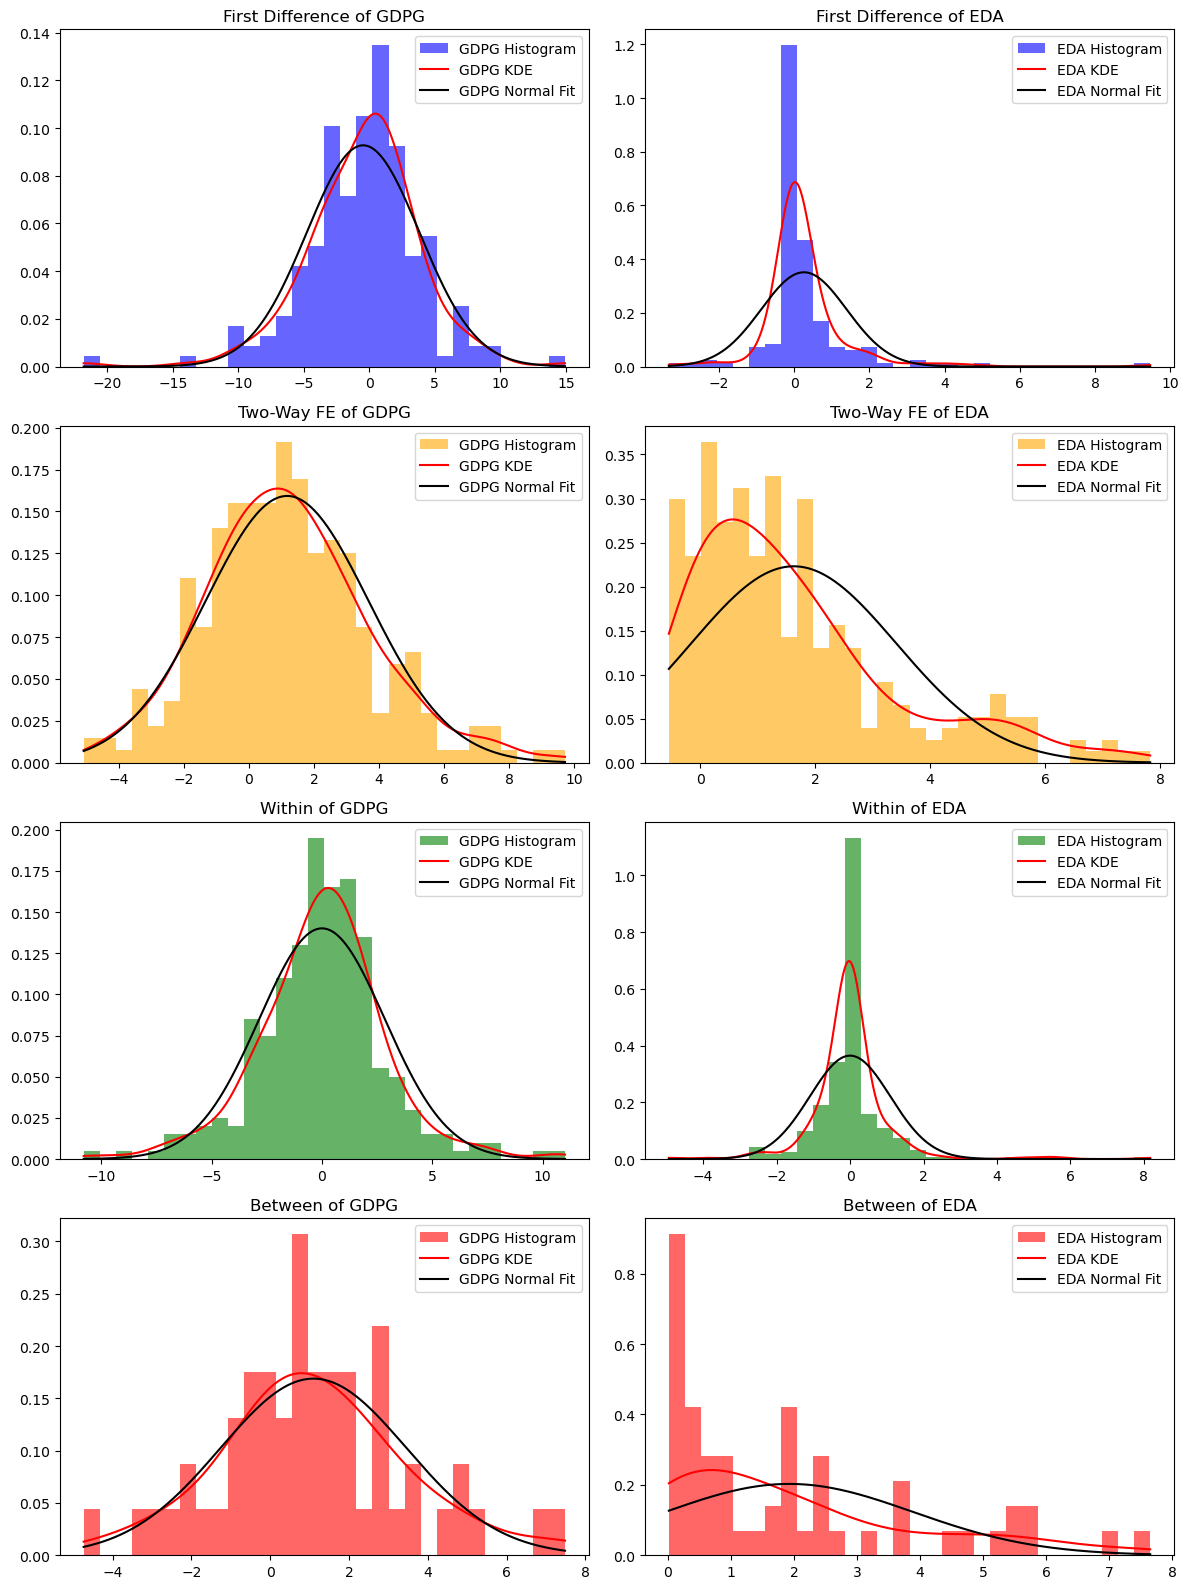

In [176]:
from scipy.stats import norm, gaussian_kde, skew, kurtosis

variables = ['GDPG', 'EDA']
within_transform = df.groupby('Country')[X_vars].transform(lambda x: x - x.mean())
between_transform = df.groupby('Country')[X_vars].mean()

time_means = df.groupby('YEAR1')[X_vars].transform('mean')
overall_mean = df[X_vars].mean()
two_way_fe = df[X_vars] - within_transform - time_means + overall_mean

def plot_distribution(ax, data, title, variable, color):
    data = data.dropna()
    mu, sigma = norm.fit(data)
    ax.hist(data, bins=30, density=True, alpha=0.6, color=color, label=f'{variable} Histogram')
    kde = gaussian_kde(data)
    x_range = np.linspace(min(data), max(data), 500)
    ax.plot(x_range, kde(x_range), color='red', label=f'{variable} KDE')
    ax.plot(x_range, norm.pdf(x_range, mu, sigma), color='black', label=f'{variable} Normal Fit')
    ax.set_title(title)
    ax.legend()

fig, axs = plt.subplots(4, len(variables), figsize=(12, 16))

for i, var in enumerate(variables):
    plot_distribution(axs[0, i], df_first_diff[var], f'First Difference of {var}', var, 'blue')
    plot_distribution(axs[1, i], two_way_fe[var], f'Two-Way FE of {var}', var, 'orange')
    plot_distribution(axs[2, i], within_transform[var], f'Within of {var}', var, 'green')
    plot_distribution(axs[3, i], between_transform[var], f'Between of {var}', var, 'red')

plt.tight_layout()
plt.show()


In [177]:
def print_statistics(df, variable_name):
    mean = df[variable_name].mean()
    std = df[variable_name].std()
    skewness = stats.skew(df[variable_name])
    kurtosis_value = kurtosis(df[variable_name], fisher=False)

    print(f"Variable {variable_name}:")
    print(f"Mean: {mean}")
    print(f"Standard Deviation: {std}")
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurtosis_value}")


print("Within Transformation Statistics:")
print("-" *50)
print_statistics(within_transform, 'EDA')
print("\n")
print_statistics(within_transform, 'GDPG')

print("\n\nBetween Transformation Statistics:")
print("-" *50)
print_statistics(between_transform, 'EDA')
print("\n")
print_statistics(between_transform, 'GDPG')


print("\n\nfirst-diff Transformation Statistics:")
print("-" *50)
print_statistics(df_first_diff, 'EDA')
print("\n")
print_statistics(df_first_diff, 'GDPG')


print("\n\ntwo-way Transformation Statistics:")
print("-" *50)
print_statistics(two_way_fe, 'EDA')
print("\n")
print_statistics(two_way_fe, 'GDPG')

Within Transformation Statistics:
--------------------------------------------------
Variable EDA:
Mean: -2.7452787518003872e-17
Standard Deviation: 1.0966467346246704
Skewness: 2.0457148086017103
Kurtosis: 20.2533913547509


Variable GDPG:
Mean: 2.9875092299004214e-17
Standard Deviation: 2.851787542504866
Skewness: 0.01404539049353257
Kurtosis: 4.999790868953414


Between Transformation Statistics:
--------------------------------------------------
Variable EDA:
Mean: 1.9230614717070895
Standard Deviation: 1.9859564317367242
Skewness: 1.175804853896304
Kurtosis: 3.4855824664761066


Variable GDPG:
Mean: 1.0975418292953496
Standard Deviation: 2.384521999302136
Skewness: 0.2740550298256311
Kurtosis: 3.5246544618962994


first-diff Transformation Statistics:
--------------------------------------------------
Variable EDA:
Mean: 0.259226939939139
Standard Deviation: 1.139122021050225
Skewness: 3.3854416565347747
Kurtosis: 26.603163342652156


Variable GDPG:
Mean: -0.4738150446445106
Stand

The first differenced EDA has a very high kurtosis. The distribution is heavily concentrated around the mean giving it a very sharp peak, hence the highly leptokurtic value. The mean of the first differenced GDPG is negative which is also interesting, suggesting that there is a general decline in economic growth over the time period.  The two-way transformation of EDA also has a slight positive skewness. Of course EDA cannot take a negative value so the distribution is cut off at 0, but there is a spread beyond the normal of observations to the right. Two-way GDPG is very close to the normal, with a skewness of 0.417 and a kurtosis of 3.5 and very closely matches the normal fit. 

The first-difference distribution is fairly similar to the within distribution for EDA. There is a sharp spike at 0, both have very high kurtosis but the within has slightly more positive skew.

The two-way FE distribution of EDA bears little relation to the within or between plots. Indeed, both two-way and between have positive skew and neither are close to a normal distribution. The means are fairly similar, but the two-way transformed distribution has a higher skewness and kurtosis.

For GDPG there is slightly more uniformity of the distributions. If you squint, they appear to reflect a normal distribution. All of the GDPG transformations have little skewness which puts them closer to a normal distribution. The first differenced GDPG has high kurtosis: 6.31 which is reflected by the spike at the mean that can be seen in the plot.

In [178]:
year_map = {'1970-1973':1, '1974-1977':2, '1978-1981':3, '1982-1985':4, '1986-1989':5,'1990-1993':6}
df['Year'] = list(map(lambda x: year_map[x], df.index.get_level_values(1)))

variables_time = ['GDPG', 'EDA', 'Year']
grand_mean = df[variables_time].mean()
time_means = df.groupby('YEAR1')[variables_time].transform('mean')
individual_means = df.groupby('Country')[variables_time].transform('mean')
df_sorted = df.sort_values(by=['Country', 'YEAR1'])
df_first_diff_sub = df_sorted.groupby('Country')[variables_time].diff()
df_first_diff_sub = df_first_diff_sub.dropna(subset=variables_time)
df_two_way_fe_sub = df[variables_time] - individual_means - time_means + grand_mean
correlation_first_diff_sub = df_first_diff_sub.corr()
correlation_two_way_fe_sub = df_two_way_fe_sub.corr()

print("Correlation Matrix for first differences")
correlation_first_diff_sub

Correlation Matrix for first differences


GDPG       EDA      Year
GDPG  1.000000  0.102765 -0.030198
EDA   0.102765  1.000000 -0.006400
Year -0.030198 -0.006400  1.000000

For first differences, we do not observe any correlation that is significantly greater than 0.1. The correlation of GDPG with EDA is barely above 0.1 and with year is nearly 0. It appears as though the deterministic trend has been eliminated.

In [179]:
print("\nCorrelation Matrix two way FE")
correlation_two_way_fe_sub


Correlation Matrix two way FE


GDPG       EDA      Year
GDPG  1.000000  0.097382 -0.090361
EDA   0.097382  1.000000  0.117134
Year -0.090361  0.117134  1.000000

The two-way FE we are controlling for both individual and time specific effects. This transformation also sees correlations not significantly larger than 0.1 in absolute value. EDA has a small correlation with year of 0.117134. The correlation between GDPG and EDA after the two-way FE transformation is 0.097, even smaller than for the first-differences.

# 7. Plot boxplots of between distribution (all countries), then one-way and two-way-fixed effects and first differences distribution BY countries (or 20 individuals if your data set has more than 20 individuals), for the dependent variable and the key explanatory variables. Comment that you find the same insights from question 5. Comment on their differences of standard errors and means for each individuals


## Between

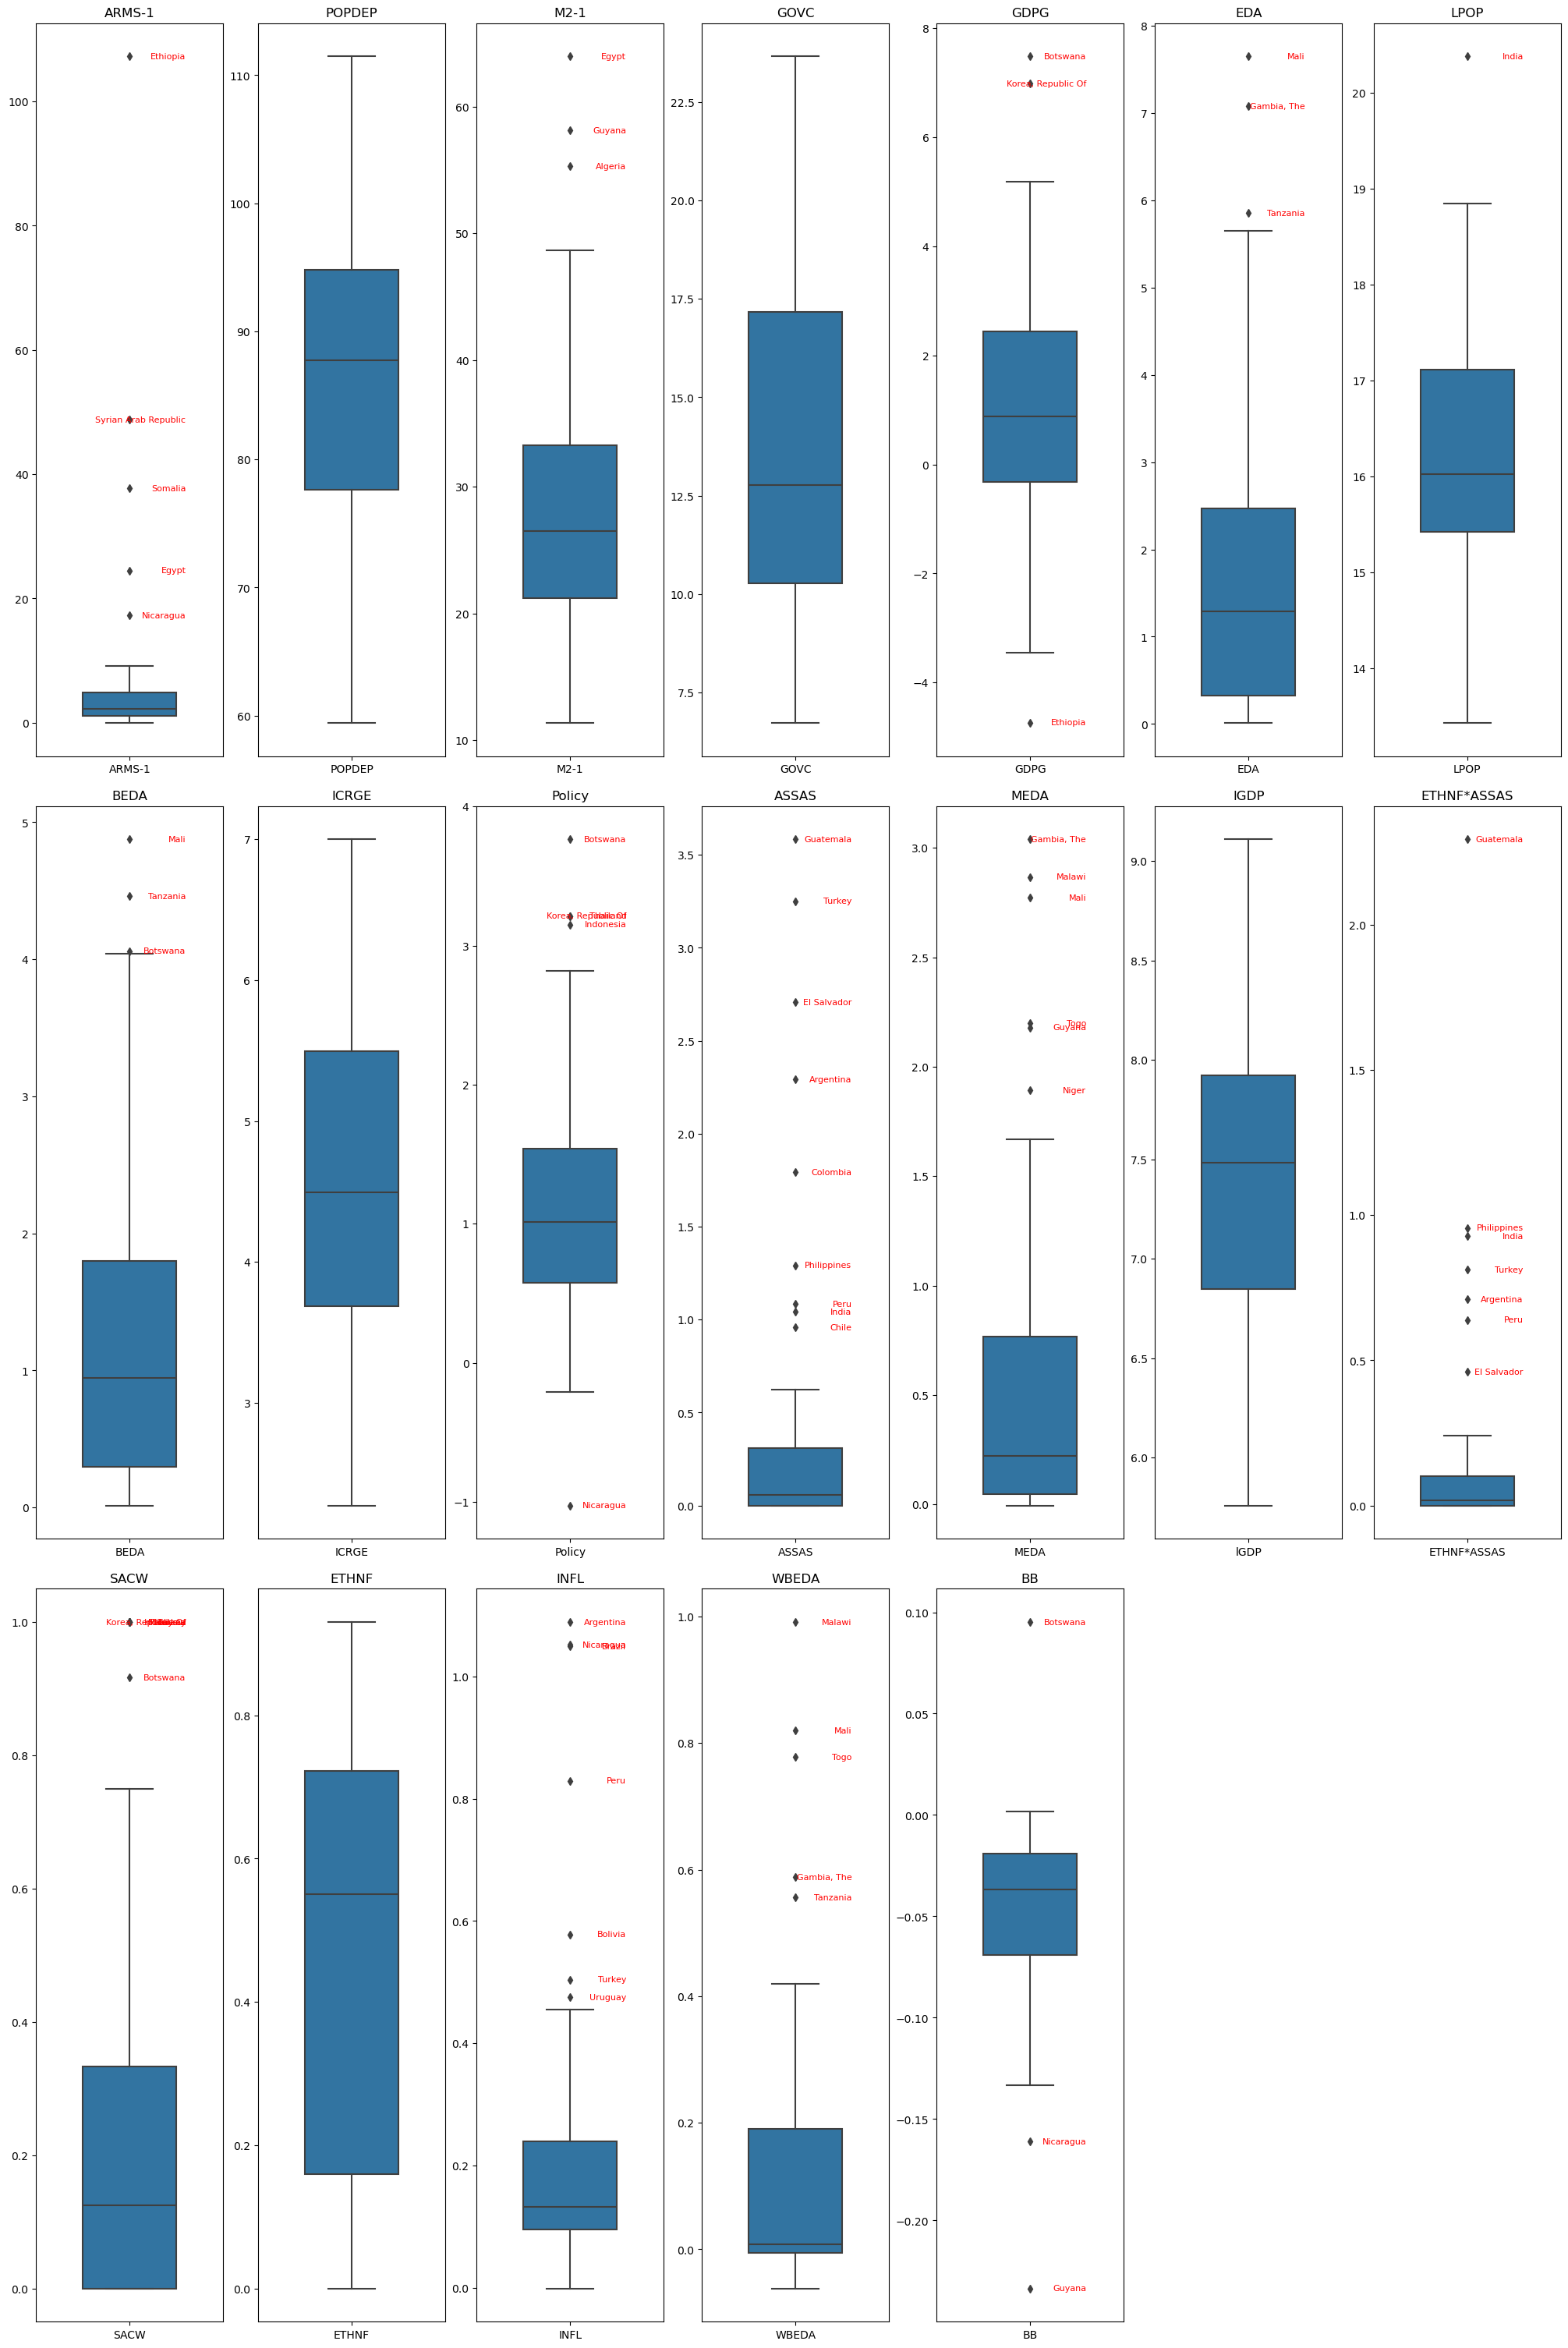

In [180]:
df_between = df.groupby('Country')[X_vars].mean()

df_melted = pd.melt(df_between.reset_index(), id_vars='Country', value_vars=X_vars, var_name='Variable', value_name='Value')

variance_df_between = df_between.var().sort_values(ascending=False).reset_index()
variance_df_between.columns = ['Variable', 'Variance']
n_rows = len(X_vars) // 7 + (len(X_vars) % 7 > 0)

sorted_vars_by_variance = variance_df_between['Variable'].tolist()
df_melted_sorted = df_melted.merge(variance_df_between, on='Variable')
df_melted_sorted = df_melted_sorted.sort_values('Variance', ascending=False)

fig, axs = plt.subplots(n_rows, 7, figsize=(20, 10 * n_rows), constrained_layout=True)
axs = axs.flatten()

for i, var in enumerate(sorted_vars_by_variance):
    if i >= len(axs):
        break
    sns.boxplot(x='Variable', y='Value', data=df_melted_sorted[df_melted_sorted['Variable'] == var], ax=axs[i], width=0.5)
    axs[i].set_title(var)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    
    subset = df_melted_sorted[df_melted_sorted['Variable'] == var]
    q1 = subset['Value'].quantile(0.25)
    q3 = subset['Value'].quantile(0.75)
    iqr = q3 - q1
    outliers = subset[(subset['Value'] < (q1 - 1.5 * iqr)) | (subset['Value'] > (q3 + 1.5 * iqr))]
    
    for out_index, out_row in outliers.iterrows():
        x_offset = 0.3
        y = out_row['Value']
        axs[i].text(x_offset, y, f"{out_row['Country']}", 
                    ha='right', va='center', fontsize=8, color='red', transform=axs[i].transData)

for ax in axs[len(sorted_vars_by_variance):]:
    ax.set_visible(False)

plt.show()


In [181]:
print("\nBetween Transformation Statistics:")
print_statistics(between_transform, 'EDA')
print("\n")
print_statistics(between_transform, 'GDPG')


Between Transformation Statistics:
Variable EDA:
Mean: 1.9230614717070895
Standard Deviation: 1.9859564317367242
Skewness: 1.175804853896304
Kurtosis: 3.4855824664761066


Variable GDPG:
Mean: 1.0975418292953496
Standard Deviation: 2.384521999302136
Skewness: 0.2740550298256311
Kurtosis: 3.5246544618962994


Recall from question 5 that there was posiitve skewness for both transformations for both EDA and GDPG. The Kurtosis for the within EDA was extremely high (20.25) and was above three for all other transformations for both EDA and GDPG. 

We would expect to see this translated in the boxplots. Skewness would be reflected in the boxplots with the boxplot's whiskers stretching out north away from the mean, indicating a spread of higher observations. For between there was mediocre kurtosis close to three for both GDPG and EDA. High kurtosis (leptokurtosis) would be reflected by a tight interquartile range and a short box plot. For both GDPG and EDA, the box-plots are not especially short and we can see the spread of observations like Botswana and Korea (for GDPG) and Mali, The Gambia and Tanzania (for EDA). The existence of these 'outliers' that stretch beyond the whiskers is indicative of positive skewness, which is especially apparent for EDA. Furthermore, both have positive means which is also reflected by the body of the boxplot lying north of the y=0 line.

## Within GDPG and EDA

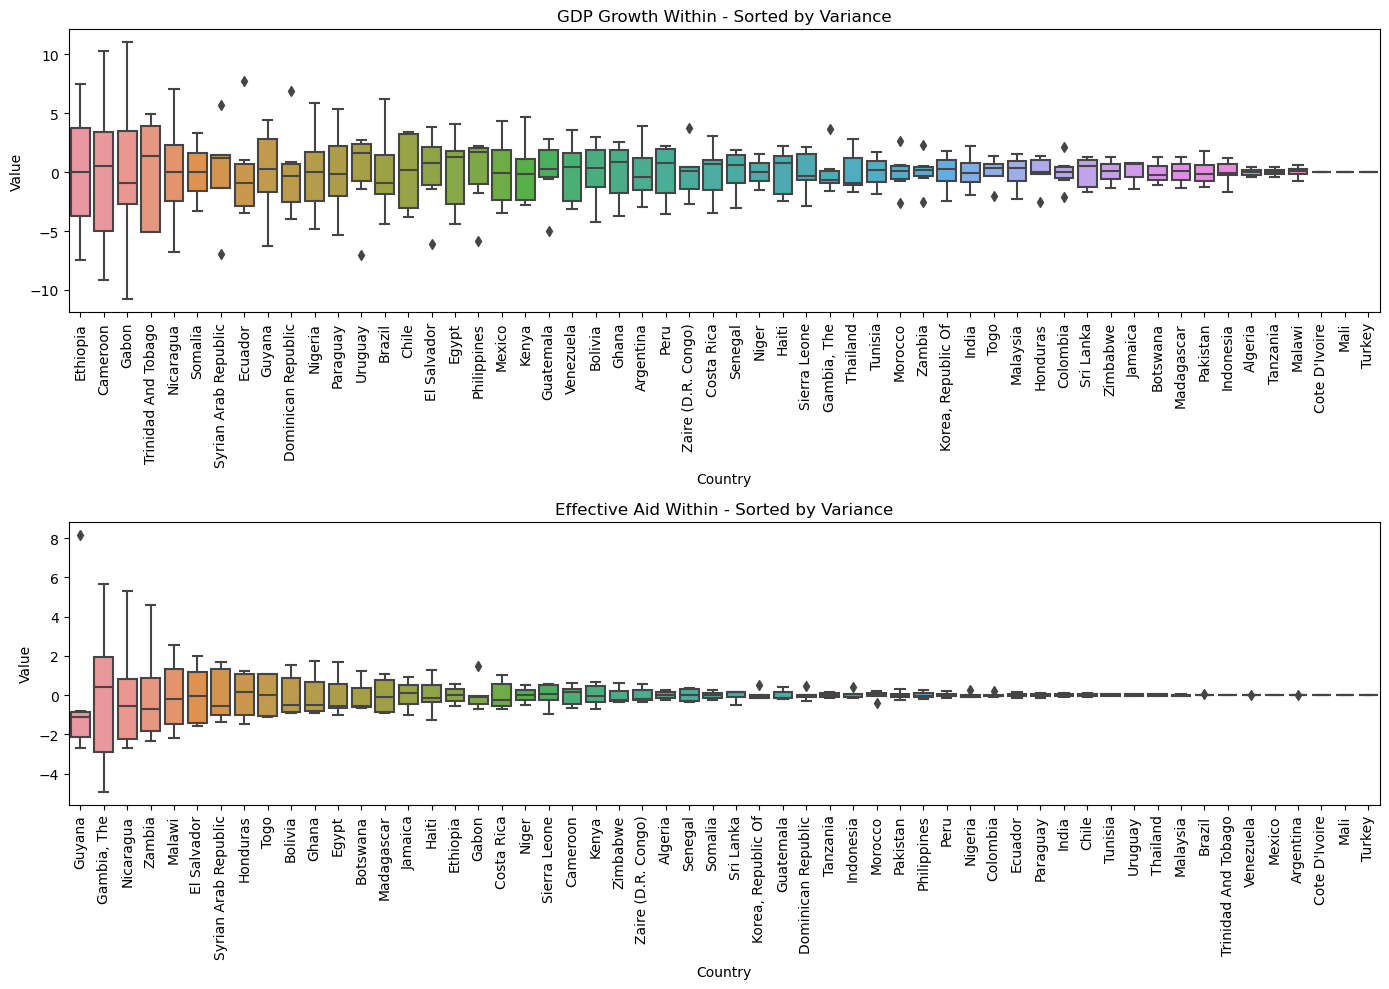

In [182]:
df_within = df.copy()
for var in X_vars:
    df_within[var] = df_within.groupby('Country')[var].transform(lambda x: x - x.mean())

df_within.reset_index(inplace=True)
df_melted_within = pd.melt(df_within, id_vars='Country', value_vars=X_vars, var_name='Variable', value_name='Value')



gdp_variance = df_within.groupby('Country')['GDPG'].var()
eda_variance = df_within.groupby('Country')['EDA'].var()

sorted_countries_gdp = gdp_variance.sort_values(ascending=False).index
sorted_countries_eda = eda_variance.sort_values(ascending=False).index

df_within_melted = df_within.melt(id_vars='Country', value_vars=['GDPG', 'EDA'], var_name='Variable', value_name='Value')

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.boxplot(data=df_within_melted[df_within_melted['Variable'] == 'GDPG'], x='Country', y='Value', order=sorted_countries_gdp)
plt.title('GDP Growth Within - Sorted by Variance')
plt.xticks(rotation=90) 

plt.subplot(2, 1, 2)
sns.boxplot(data=df_within_melted[df_within_melted['Variable'] == 'EDA'], x='Country', y='Value', order=sorted_countries_eda)
plt.title('Effective Aid Within - Sorted by Variance')
plt.xticks(rotation=90) 

plt.tight_layout()
plt.show()

In [183]:
print("\nwithin Transformation Statistics:")
print_statistics(within_transform, 'EDA')
print("\n")
print_statistics(within_transform, 'GDPG')


within Transformation Statistics:
Variable EDA:
Mean: -2.7452787518003872e-17
Standard Deviation: 1.0966467346246704
Skewness: 2.0457148086017103
Kurtosis: 20.2533913547509


Variable GDPG:
Mean: 2.9875092299004214e-17
Standard Deviation: 2.851787542504866
Skewness: 0.01404539049353257
Kurtosis: 4.999790868953414


In question 5 we estimated the Skewness and Kurtosis shown above. The Kurtosis for EDA is especially high and the skewness is positive. For GDPG the kurtosis is also reasonable (5) and the skewness is negligibly positive. Kurtosis would be apparent in these boxplots if many of the boxplots are similar. This would indicate a concentration of observations and would be reflected by a spike in the distribution plots which yields high kurtosis. The boxplots show this. As we move right past Madagascar, the boxplots for each country are almost the same as each other. All are fairly short and have means that are near enough 0. The positive skewness can also be interpreted from the boxplot. There are a number of observations on the left that have positive values and are higher than the mean that can be inferred from the remaining plots. Countries like The Gambia, Nicaragua and Zambia are in this category. All have means larger than 0 (the mean for the rest of the group) and contribute towards the positive skew and the lengthy right tail for the distribution plots.

Turning now to GDPG the skewness and kurtosis is less severe. We can infer the kurtosis from the boxplots because it looks like many of the countries right of Mexico have means and boxplots that are similar to each other, indicating concentration of values. With the mean being almost zero, the slight positive skewness can also be seen with some of the left-side countries having means that are slightly north of the y=0 line, like Cameroon, Trinidad and Tobago and Guyana. This is reflective of the slightly longer right tail of the distribution seen above.

## First Differences

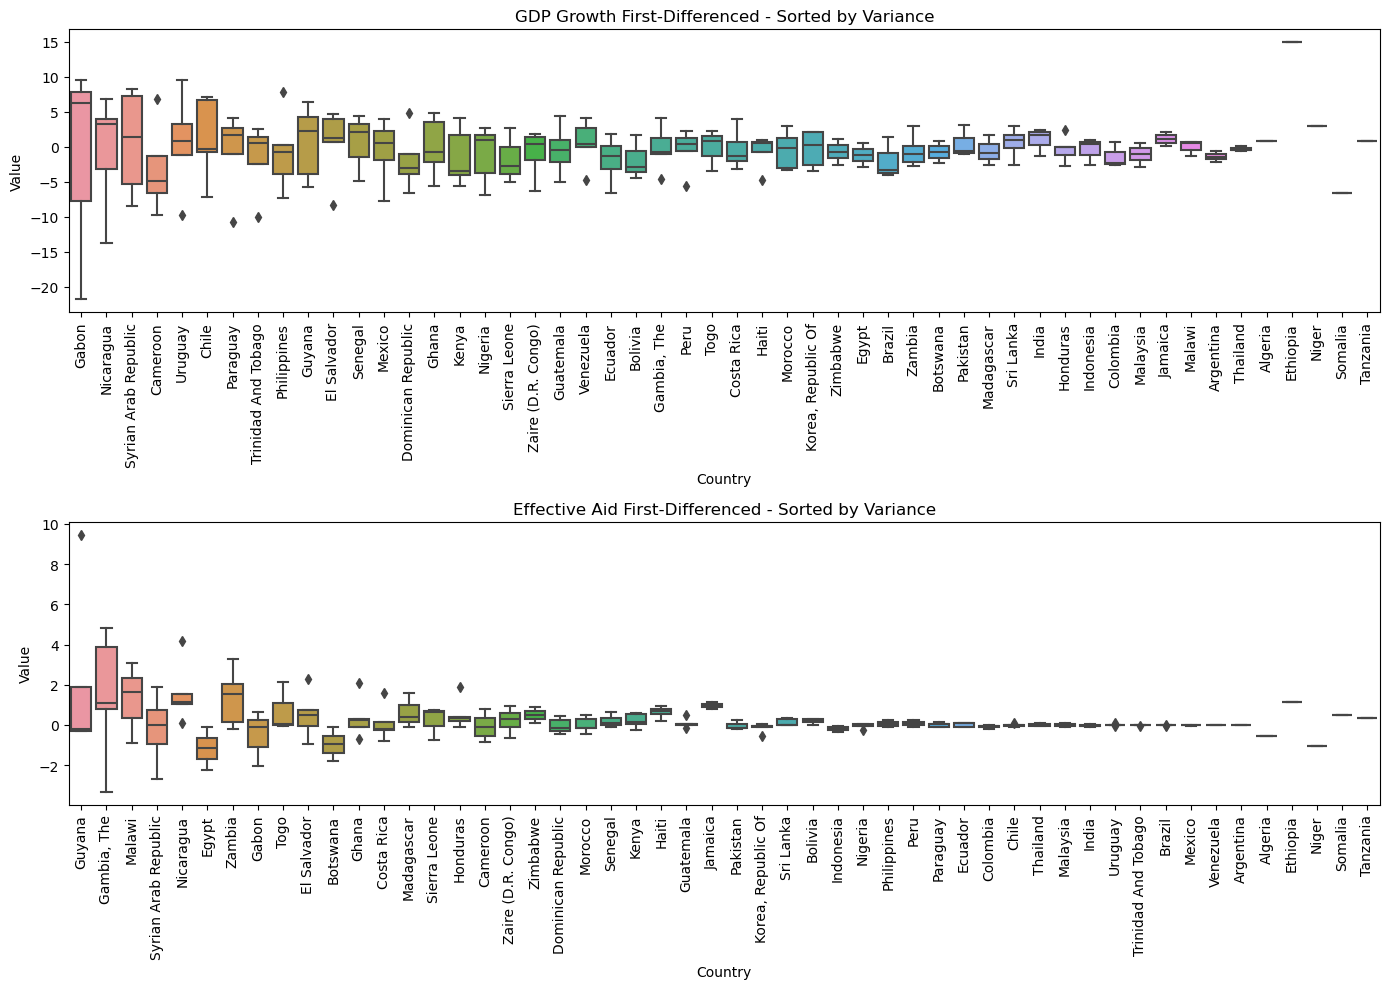

In [184]:
gdp_variance_diff = df_first_diff.groupby('Country')['GDPG'].var()
eda_variance_diff = df_first_diff.groupby('Country')['EDA'].var()

sorted_countries_gdp_diff = gdp_variance_diff.sort_values(ascending=False).index
sorted_countries_eda_diff = eda_variance_diff.sort_values(ascending=False).index
df_first_diff_melted = df_first_diff.reset_index().melt(id_vars='Country', value_vars=['GDPG', 'EDA'], 
                                                        var_name='Variable', value_name='Value')

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.boxplot(data=df_first_diff_melted[df_first_diff_melted['Variable'] == 'GDPG'], 
            x='Country', y='Value', order=sorted_countries_gdp_diff)
plt.title('GDP Growth First-Differenced - Sorted by Variance')
plt.xticks(rotation=90)

plt.subplot(2, 1, 2)
sns.boxplot(data=df_first_diff_melted[df_first_diff_melted['Variable'] == 'EDA'], 
            x='Country', y='Value', order=sorted_countries_eda_diff)
plt.title('Effective Aid First-Differenced - Sorted by Variance')
plt.xticks(rotation=90) 

plt.tight_layout()
plt.show()

In [185]:
print("\n\nfirst-diff Transformation Statistics:")
print("-" *50)
print_statistics(df_first_diff, 'EDA')
print("\n")
print_statistics(df_first_diff, 'GDPG')



first-diff Transformation Statistics:
--------------------------------------------------
Variable EDA:
Mean: 0.259226939939139
Standard Deviation: 1.139122021050225
Skewness: 3.3854416565347747
Kurtosis: 26.603163342652156


Variable GDPG:
Mean: -0.4738150446445106
Standard Deviation: 4.3110466738183675
Skewness: -0.5808764576308053
Kurtosis: 6.312688670841341


Recall from question 5 that EDA first-differenced has a positive skew of 3.39 and a very high kurtosis of 26.6. GDPG first-differenced has a slightly negative skew of -0.58 and a more moderate kurtosis of 6.3. For EDA's boxplots we would expect to see some countries' boxplots above the population mean which can be inferred from the general 'middle-ground' of the other boxplots indicating positive skewness. Indeed, for EDA we see many countries' centred at 0 but with the left-side's countries straying above this population mean which gives rise to positive skew, reflected in the distributions by a lengthy right tail. For GDPG the skewness is nearly 0 but negative, and this is far harder to ascertain from the boxplots.

Kurtosis would be reflected by many boxplots being similar in size and centred along the same line. for GDPG this appears to be the case with the boxplots past the Dominican Republic being fairly similar in height and mean indicating concentration and kurtosis. For EDA it is far more apparent. We saw that the Kurtosis is 26.6 and almost all of the countries' boxplots are along the same line, certaintly past Cameroon. This is indicative of high concentration and a large spike in the distribution function at the mean.

## Two-Way Fixed Effects

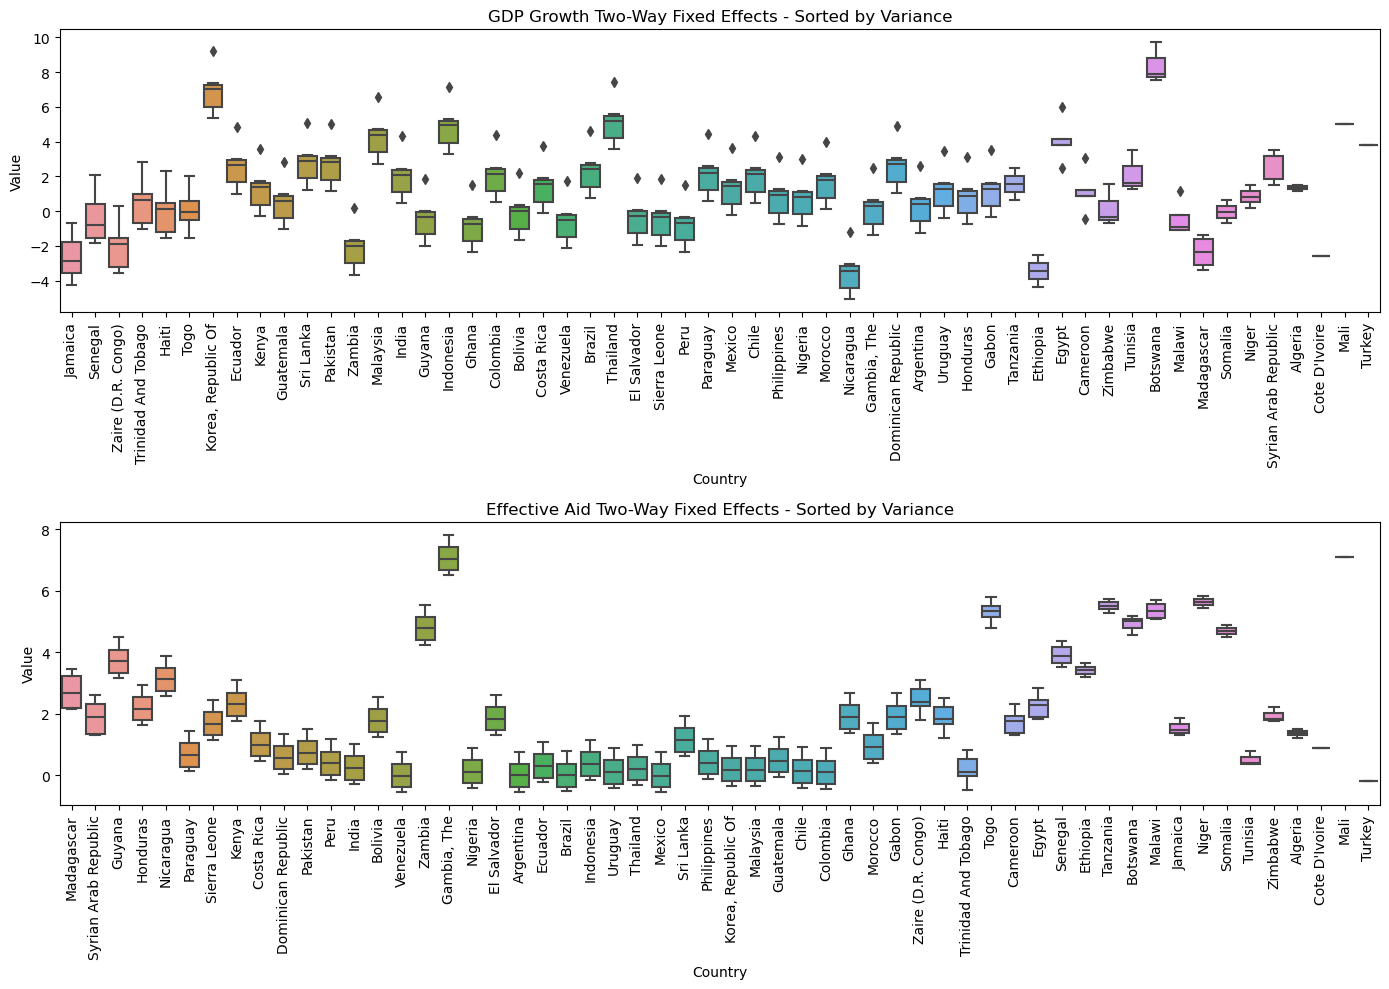

In [186]:
gdp_variance_fe = two_way_fe.groupby('Country')['GDPG'].var()
eda_variance_fe = two_way_fe.groupby('Country')['EDA'].var()

sorted_countries_gdp_fe = gdp_variance_fe.sort_values(ascending=False).index
sorted_countries_eda_fe = eda_variance_fe.sort_values(ascending=False).index

df_two_way_fe_melted = two_way_fe.reset_index().melt(id_vars='Country', value_vars=['GDPG', 'EDA'], var_name='Variable', value_name='Value')

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.boxplot(data=df_two_way_fe_melted[df_two_way_fe_melted['Variable'] == 'GDPG'], x='Country', y='Value', order=sorted_countries_gdp_fe)
plt.title('GDP Growth Two-Way Fixed Effects - Sorted by Variance')
plt.xticks(rotation=90) 

plt.subplot(2, 1, 2)
sns.boxplot(data=df_two_way_fe_melted[df_two_way_fe_melted['Variable'] == 'EDA'], x='Country', y='Value', order=sorted_countries_eda_fe)
plt.title('Effective Aid Two-Way Fixed Effects - Sorted by Variance')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


In [187]:
print("\n\ntwo-way Transformation Statistics:")
print("-" *50)
print_statistics(two_way_fe, 'EDA')
print("\n")
print_statistics(two_way_fe, 'GDPG')



two-way Transformation Statistics:
--------------------------------------------------
Variable EDA:
Mean: 1.6252367402032646
Standard Deviation: 1.791609142270061
Skewness: 1.2391060670414147
Kurtosis: 4.096469912502218


Variable GDPG:
Mean: 1.1733741522327497
Standard Deviation: 2.509949668027602
Skewness: 0.41746006588033296
Kurtosis: 3.511264929727227


Neither skewness nor kurtosis is particularly severe for either of the two-way transformed variables. Two-way transformation is supposed to eliminate entity specific and time specific effects so we would expect greater similarity in the boxplots and a more normal distribution of the plots. 

Kurtosis is perhaps the easiest to observe in the plots. Especially for EDA, many of the boxplots are concentrated to the south of the figure, indicating a spike in the distribution function. We see to the right of the figure the boxplots 'dissolve' and spread out ad upwards, contributing to the positive skew. For GDPG the boxplots are more uniform, there are none that are clearly outliers and it does appear that GDPG two-way transformed has eliminated most of the individual fixed effecs.

# 8. Compute univariate descriptive statistics (min, Q1, median, Q3, max, mean, standard error) for one-way-Within, Between, two-way-fixed-effects and first differences transformed variables. Is the mean different from the median and why? How many standard errors from the mean are the MIN and MAX extremes (report (MAX-average)/standard error and (MIN-average)/standard error in the tables)?

In [188]:
#creating a new list of interesting variables that are used by B and D in their regressions (see table 1 in B and D).
#it is best to slim the variables under interest from this point forward to avoid unnecessary complexity.
interesting_vars = ['GDPG', 'EDA', 'ETHNF', 'ASSAS', 'ICRGE', 'M2-1', 'lGDP', 'ETHNF*ASSAS', 'Policy', 'BB', 'INFL', 'M2-1', 'SACW']

def descriptive_statistics(df, variables):
    descriptives = df[variables].describe()
    descriptives = descriptives.T

    descriptives['SE'] = descriptives['std'] / np.sqrt(descriptives['count'])
    descriptives['mean'] = df[variables].mean()

    descriptives['Skew'] = df[variables].skew()
    descriptives['Kurtosis'] = df[variables].kurt()

    descriptives['(MAX-Mean)/SE'] = (descriptives['max'] - descriptives['mean']) / descriptives['SE']
    descriptives['(MIN-Mean)/SE'] = (descriptives['mean'] - descriptives['min']) / descriptives['SE']

    descriptives['median = mean?'] = np.where(descriptives['50%'].eq(descriptives['mean']), 'Yes', 'No')

    columns_order = ['min', '25%', '50%', '75%', 'max', 'mean', 'median = mean?', 'SE', '(MAX-Mean)/SE', '(MIN-Mean)/SE', 'Skew', 'Kurtosis']
    return descriptives[columns_order]

within_descriptives = descriptive_statistics(df_within, interesting_vars)
between_descriptives = descriptive_statistics(df_between, interesting_vars)
two_way_fe_descriptives = descriptive_statistics(two_way_fe, interesting_vars)
first_diff_descriptives = descriptive_statistics(df_first_diff, interesting_vars)

all_descriptives = pd.concat({
    'Within': within_descriptives,
    'Between': between_descriptives,
    'Two-Way FE': two_way_fe_descriptives,
    'First Difference': first_diff_descriptives
}, axis=1)

all_descriptives.transpose()

GDPG         EDA      ETHNF       ASSAS  \
Within           min            -10.796518   -4.934154       -0.0   -3.583333   
                 25%              -1.48574   -0.250841        0.0   -0.145833   
                 50%              0.078064   -0.014007        0.0   -0.041667   
                 75%              1.486138    0.142121        0.0         0.0   
                 max             11.009405    8.172046        0.0    7.916667   
                 mean                  0.0        -0.0       -0.0        -0.0   
                 median = mean?         No          No         No          No   
                 SE               0.171969     0.06613        0.0    0.057547   
                 (MAX-Mean)/SE   64.019612  123.574943  48.352506  137.569871   
                 (MIN-Mean)/SE   62.781674   74.612623  47.849631   62.268468   
                 Skew             0.014123    2.056952        0.0    3.654754   
                 Kurtosis         2.058772   17.593386        0.0   31.972269   
Between          min             -4.736272    0.014515        0.0         0.0   
                 25%             -0.321708    0.326882       0.16         0.0   
                 50%              0.876755    1.292233       0.55     0.05625   
                 75%              2.445868    2.469534     0.7225    0.308333   
                 max              7.482522    7.649373       0.93    3.583333   
                 mean             1.097542    1.923061   0.473929    0.409821   
                 median = mean?         No          No         No          No   
                 SE               0.318645    0.265385   0.040602     0.10836   
                 (MAX-Mean)/SE     20.0379   21.577409  11.232858   29.286763   
                 (MIN-Mean)/SE   18.308182    7.191626  11.672673    3.782038   
                 Skew             0.281656    1.208417  -0.212272    2.677415   
                 Kurtosis         0.690004    0.647205  -1.502253    6.793025   
Two-Way FE       min             -5.082651    -0.54768  -0.017402   -0.347944   
                 25%             -0.427077    0.296192   0.153003    0.059478   
                 50%              1.033773      1.1892   0.551556    0.159478   
                 75%              2.669558    2.342107   0.721556    0.423584   
                 max              9.718067     7.83018   0.916514    3.716371   
                 mean             1.173374    1.625237   0.464473    0.431818   
                 median = mean?         No          No         No          No   
                 SE               0.151356    0.108038   0.018108    0.047927   
                 (MAX-Mean)/SE   56.454401    57.43292  24.963666   68.532854   
                 (MIN-Mean)/SE   41.333276   20.112507   26.61124   16.269888   
                 Skew             0.419753    1.245912  -0.186179    2.359355   
                 Kurtosis         0.542823     1.13881  -1.503304    5.524556   
First Difference min            -21.805923   -3.330271        0.0       -9.75   
                 25%             -2.845164   -0.082994        0.0         0.0   
                 50%              0.006713    0.011208        0.0         0.0   
                 75%              2.010757    0.334969        0.0         0.0   
                 max             14.935178    9.465112        0.0       11.25   
                 mean            -0.473815    0.259227        0.0    0.060567   
                 median = mean?         No          No        Yes          No   
                 SE               0.309515    0.081784        0.0    0.112749   
                 (MAX-Mean)/SE   49.784298  112.563134        NaN   99.241917   
                 (MIN-Mean)/SE   68.921055   43.889872        NaN   87.012405   
                 Skew            -0.585413    3.411879        0.0    0.320351   
                 Kurtosis         3.431256   24.254555        0.0   27.425496   

                                     ICRGE       M2-1       lGDP ETH

$ skewness, \tilde{\mu}_3 = \frac{\Sigma^N_i (X_i - \bar{X})^3}{(N-1)*\sigma^3} $

Let us focus on EDA and GDPG. None of the transformations yield a median that is equal to the mean. This is because non of the distributions are normal. If there is skew, be that positive there is a stretch of observations to the side of the mean. As can be seen with the negative skew of -0.58 for first differenced GDPG the mean does not equal the median, it is less than.

For the other three transformations for GDPG and for all of the transformations for EDA, the skewness is positive. In all of these cases the mean exceeds the median except for the within transformation for GDPG. This could be because of a few large negative outliers preventing the median from going negative given the small skew. This is supported by the minimum value being 62 standard errors from the mean.

The results here support the plots in question 5. We saw, especially with two-way EDA a large cluster of values spreading to the right and with the maximum value being 57* the standard error this is consistent.

Considering also the First-differenced GDPG, we saw in the distribution that there was an observation way to the left of the majority of the distributions, past the negative 20 mark. This negative cluster is reflected in the above table with the minimum being almost 70 standard errors from the mean.

The most notable outlier is the maximum value of EDA within being almost 124 standard errors from the mean. This observation is almost invisible on the distribution plot but contributes to the positive skew.

# 9. Compare and comment the between versus one-way-within transformed bivariate correlation matrix for all variables (include a time trend 1,2,.,T) and with their lag (for time varying variables). Check for simple correlation with the dependent variables and high correlation between explanatory variables.

In [189]:
X_vars = ['BB', 'INFL', 'SACW', 'GDPG', 'lGDP', 'ETHNF*ASSAS',
          'ETHNF', 'ASSAS','ICRGE', 'M2-1', 'EDA', 'Policy']

In [190]:
#Create a time trend
year_map = {'1970-1973':1, '1974-1977':2, '1978-1981':3, '1982-1985':4, '1986-1989':5,'1990-1993':6}
df['Year'] = list(map(lambda x: year_map[x], df.index.get_level_values(1)))

within = pd.merge(within, df['Year'], how='inner', left_index=True, right_index=True)
overall = pd.merge(overall, df['Year'], how='inner', left_index=True, right_index=True)

## Within

### Simple

In [191]:
X_vars_plus =['Year'] + X_vars 
n = len(X_vars_plus)
p_values = np.zeros((n,n))
output = np.zeros((n,n))

for i,var1 in enumerate(X_vars_plus):
    for j,var2 in enumerate(X_vars_plus):
        output[i][j] = stats.pearsonr(within[var1], within[var2])[0]
        p_values[i][j] = stats.pearsonr(within[var1], within[var2])[1]
                
output = pd.DataFrame(output, columns = X_vars_plus, index=X_vars_plus)
p_values = pd.DataFrame(p_values, columns = X_vars_plus, index=X_vars_plus)
new_out = pd.DataFrame()

for col in output.columns:
    temp = add_stars(output[col], p_values[col])
    temp.name = col
    new_out = pd.concat([new_out, temp], axis=1)

new_out.index = [x.replace(' ', '')[:6] for x in output.index]
new_out.columns = [x.replace(' ','')[:6] for x in new_out.columns]
print('Simple Correlation Matrix for within Transformed Variables')
print('='*110)
print(new_out)
print('\n')
print('*** - p < 0.01, ** - p < 0.05, * - p < 0.01')
print('Note: Pearson\'s correlation coefficient assumes normally distributed variables')

Simple Correlation Matrix for within Transformed Variables
             Year         BB       INFL      SACW       GDPG       lGDP  \
Year     1.000***     -0.024   0.292***  0.480***  -0.274***   0.289***   
BB         -0.024   1.000***  -0.380***   0.135**   0.164***    0.122**   
INFL     0.292***  -0.380***   1.000***     0.049  -0.258***     -0.091   
SACW     0.480***    0.135**      0.049  1.000***      0.096     -0.050   
GDPG    -0.274***   0.164***  -0.258***     0.096   1.000***  -0.252***   
lGDP     0.289***    0.122**     -0.091    -0.050  -0.252***   1.000***   
ETHNF*      0.030     -0.040      0.042     0.005     -0.022      0.082   
ETHNF       0.002     -0.000     -0.000    -0.000     -0.000      0.000   
ASSAS       0.076     -0.040      0.046     0.097     -0.059     0.117*   
ICRGE       0.002      0.000     -0.000     0.000      0.000     -0.000   
M2-1     0.559***     -0.095   0.256***  0.255***  -0.182***   0.201***   
EDA      0.360***    -0.109*   0.211***  

Let us remind ourselves of the policy index:
$$
Policy_{it} = \alpha + \beta_1BB_{it} + \beta_2INFL_{it} + \beta_3SACW_{it} + \epsilon_{it}
$$

We see from the correlation matrix that there is high, significant correlation between policy and BB; SACW, INFL. This is naturally to be expected given that policy is a function of these three variables. The same goes for ETHNF*ASSAS and Assassinations. Also interesting is the positive correlation between assassinations and the log of GDP, but the negative correlation between assassinations and GDP growth (although not significant). This suggests that assassinations cannot be curbed with GDP per se, but rather with growth in GDP. ICRGE is positively correlated with ETHNF with a coefficient of 0.216 which is significant with 99% confidence, suggesting that the country's institutional quality increases with ethnic fractionalisation. Effective development aid is negatively correlated with the log of GDP (with 99% confidence) but is positively correlated with GDP growth (not statistically significant). This is because EDA may contribute to growth, but given that it is effective development aid and is scaled by GDP, as GDP in absolute terms increases the effective development aid decreases; hence the negative coefficient with log GDP. Also notable is the correlation between GDP growth and policy. The high statistical significance suggests that good policy contributes to good growth outcomes (or growth = good policy). Regarding the year column, many of the correlations are statistically significant. GDP growth is negatively correlated with year, but inflation and the openness index are positively correlated with time.

In [192]:
# Sort X and Y axes of the scatter matrix by the sum of p-values (x = row-wise, y = col-wise)

n = len(X_vars_plus)
p_values = np.zeros((n,n))
for i,var1 in enumerate(X_vars_plus):
    for j,var2 in enumerate(X_vars_plus):
        p_values[i][j] = stats.pearsonr(within[var1], within[var2])[1]
                
p_values = pd.DataFrame(p_values, columns = X_vars_plus, index=X_vars_plus)

x_vars_sorted = p_values.sum().sort_values().index
y_vars_sorted = p_values.sum(axis=1).sort_values().index

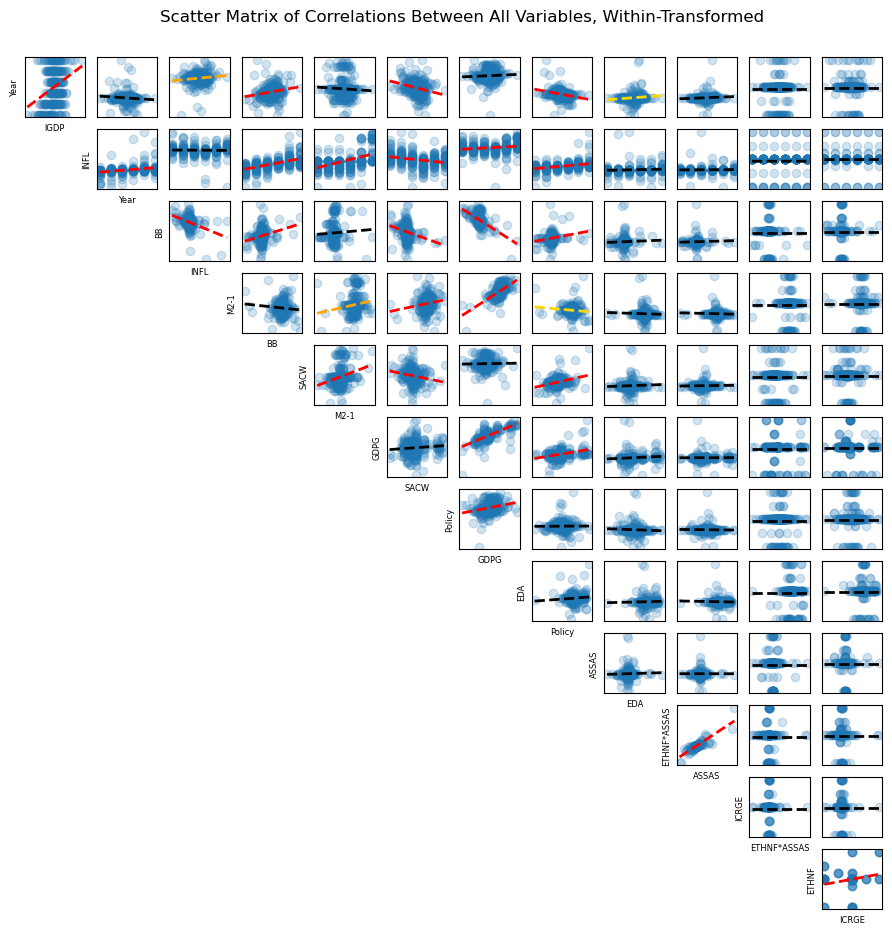

In [193]:
n = len(X_vars_plus)

already_plotted = []

fig, ax = plt.subplots(n, n, figsize=(12,12), dpi=100, sharex=False, sharey=False)

for row, x_var in enumerate(x_vars_sorted):
    already_plotted.append(x_var)
    for col, y_var in enumerate(y_vars_sorted):
        if y_var in already_plotted:
            ax[row][col].set_visible(False)
        else:            
            x = within[x_var].astype(np.float64) 
            y = within[y_var].astype(np.float64)
            
            reg = np.polyfit(x, y, 1, full=False)
            slope, intercept = reg[0], reg[1]

            x_l = [min(x), max(x)]
            y_l = [xx * slope + intercept for xx in x_l]

            pearsons = stats.pearsonr(x, y)[1]
            if pearsons < 0.01: color = 'red'
            elif pearsons < 0.05: color = 'orange'
            elif pearsons < 0.10: color = 'gold'
            else: color = 'black'

            ax[row][col].scatter(x, y, alpha=0.2)
            ax[row][col].plot(x_l, y_l, ls='--',color=color, lw=2, zorder=10)
            
            ax[row][col].set_xticks([])
            ax[row][col].set_yticks([])
            
            if row == col-1:
                ax[row][col].set_xlabel(x_var, size=6)
                ax[row][col].set_ylabel(y_var, size=6)
                
#fig.legend([patches.Patch(facecolor='red', edgecolor='red'),
 #          patches.Patch(facecolor='orange', edgecolor='orange'),
  #         patches.Patch(facecolor='gold', edgecolor='gold')], 
   #        ['P < 0.01', 'P < 0.05', 'P < 0.10'], bbox_to_anchor=(.395,.31), ncol=3)

#fig.text(x=.18, y=.42, s='Read x-axis labels RIGHT and y-axis labels UP', zorder=3)
#fig.add_artist(patches.Rectangle((.14,.39), height=.1, width=.36, facecolor='whitesmoke', edgecolor='black', zorder=0))

fig.suptitle('Scatter Matrix of Correlations Between All Variables, Within-Transformed', size=12, x=0.55, y=.92)
plt.show()

This figure shows the bivariate correlation plots. As we mentioned above, the significant correlations between policy and GDPG or ICRGE and ETHNF are immediately observable with the red in the line indicating statistical significance.

### Within Lag

#### Weight

Inspired by the example code, we also employ a weight to scale the correlations given the unbalanced panel.

In [194]:
df.groupby('YEAR1').size()

YEAR1
1970-1973    41
1974-1977    47
1978-1981    48
1982-1985    48
1986-1989    49
1990-1993    42
dtype: int64

In [195]:
n = df.groupby('YEAR1').size().values
w = n / max(n)
w = w / w.sum()
print(f'Weights: {w}')
print(f'Verify weights sum to 1: {w.sum():0.8f}')

Weights: [0.14909091 0.17090909 0.17454545 0.17454545 0.17818182 0.15272727]
Verify weights sum to 1: 1.00000000


In [196]:
print('Correlation for each variable and it\'s first lag, Within Transformed')
print('='*68)
print(' '*25 + 'Lag 1' + ' '*10 + 'Trend' + ' '*10 + 'N Obs')
print(' '*25 + '=====' + ' '*10 + '=====' + ' '*10 + '=====')

for var in X_vars:
    n_obs = str(within.groupby('YEAR1').agg(np.nanmean)[var].shape[0])
    vals = within.groupby('YEAR1').agg(np.nanmean)[var] * w
    line = ''
    corr, p = stats.pearsonr(vals.iloc[1:], vals.shift(1).dropna(), )
    line = var + ' '*(25 - len(var)) 
    if p < 0.01:
        stat = f'{corr:0.2f}***'
    elif p < 0.05:
        stat = f'{corr:0.2f}**'
    elif p < 0.10:
        stat = f'{corr:0.2f}*'
    else:
        stat = f'{corr:0.2f}'
    line += (stat + ' ' * (16 - len(stat)))

    corr, p = stats.pearsonr(vals, within.groupby('YEAR1').agg(np.nanmean)['Year'])
    if p < 0.01:
        stat = f'{corr:0.2f}***'
    elif p < 0.05:
        stat = f'{corr:0.2f}**'
    elif p < 0.10:
        stat = f'{corr:0.2f}*'
    else:
        stat = f'{corr:0.2f}'    
    
    line += (stat + ' ' * (16 - len(stat)))
    line += n_obs
    print(line)
print('\n')
print('*** - p < 0.01, ** - p < 0.05, * - p < 0.01')
print('Note: Pearson\'s correlation coefficient assumes normally distributed variables')

Correlation for each variable and it's first lag, Within Transformed
                         Lag 1          Trend          N Obs
                         =====          =====          =====
BB                       0.16            -0.09           6
INFL                     0.80            0.95***         6
SACW                     0.87*           0.81**          6
GDPG                     0.40            -0.62           6
lGDP                     0.78            0.78*           6
ETHNF*ASSAS              -0.26           0.33            6
ETHNF                    -0.20           0.25            6
ASSAS                    -0.30           0.53            6
ICRGE                    nan             nan             6
M2-1                     0.94**          0.98***         6
EDA                      0.95**          0.97***         6
Policy                   0.19            0.46            6


*** - p < 0.01, ** - p < 0.05, * - p < 0.01
Note: Pearson's correlation coefficient assumes normall

SACW, EDA and M2-1 have statistically significant autocorrelation (correlation with their lag). This is unsurprising, certaintly for SACW and EDA. Economic openess and effective aid are fairly time invariant variables. Economic openess, for example, is the product of years of governments' policies and is unlikely to change by a significant amount year by year, reflecting the the high trend coefficient and autocorrelation coefficient. Inflation also has a significant trend coefficient which is characteristic of macroeconomic variables. Although not statistically significant, ASSAS is negatively correlated with its lag, meaning that assassinations above the mean in one period is generally associated with assassinations below the mean in the next. Perhaps this reflects regime changes and the stability immediately following a political revolution or change in regime in developing countries.

## Between

In [197]:
n = len(X_vars)
p_values = np.zeros((n,n))
output = np.zeros((n,n))

for i,var1 in enumerate(X_vars):
    for j,var2 in enumerate(X_vars):
        output[i][j] = stats.pearsonr(between[var1], between[var2])[0]
        p_values[i][j] = stats.pearsonr(between[var1], between[var2])[1]

output = pd.DataFrame(output, columns = X_vars, index=X_vars)
p_values = pd.DataFrame(p_values, columns = X_vars, index=X_vars)
new_out = pd.DataFrame()

for col in output.columns:
    temp = add_stars(output[col], p_values[col])
    temp.name = col
    new_out = pd.concat([new_out, temp], axis=1)
new_out.index = [x.replace(' ', '')[:6] for x in output.index]
new_out.columns = [x.replace(' ','')[:6] for x in new_out.columns]

print('Simple Correlation Matrix for Between Transformed Variables')
print('='*110)
print(new_out)
print('\n')
print('*** - p < 0.01, ** - p < 0.05, * - p < 0.01')
print('Note: Pearson\'s correlation coefficient assumes normally distributed variables')

Simple Correlation Matrix for Between Transformed Variables
               BB       INFL      SACW      GDPG       lGDP    ETHNF*  \
BB       1.000***     -0.133    0.237*  0.446***      0.200     0.072   
INFL       -0.133   1.000***    -0.005    -0.215    0.300**     0.140   
SACW       0.237*     -0.005  1.000***  0.636***    0.302**     0.038   
GDPG     0.446***     -0.215  0.636***  1.000***    0.286**    -0.008   
lGDP        0.200    0.300**   0.302**   0.286**   1.000***     0.132   
ETHNF*      0.072      0.140     0.038    -0.008      0.132  1.000***   
ETHNF      -0.123     -0.197    -0.059    -0.134  -0.474***     0.100   
ASSAS       0.105    0.268**     0.139     0.024    0.271**  0.829***   
ICRGE     0.292**     -0.098   0.266**   0.338**    0.327**   -0.258*   
M2-1    -0.386***     -0.187     0.032     0.180      0.199    -0.082   
EDA       -0.223*     -0.199    -0.210    -0.192  -0.690***   -0.262*   
Policy   0.578***  -0.430***  0.840***  0.718***      0.184     

We now consider the between transformation. The between transformation eliminates the year because we are considering the time average for each country and the correlations between the countries. Let us consider first the GDPG column. GDPG is positively and significantly correlated with macroeconomic variables like budget surplus, economic openess, the log of GDP, and policy. Country institutional quality  is positively correlated with GDPG. Furthermore, effective development aid is actually negatively associated with GDPG which suggests countries with higher effective aid tend to underperform in growth. It is impossible to say which precedes the other or if there is a causal relationship. In fact, the coefficient is not even statistically significant.

Another interesting correlation coefficient to do with violence is the positive correlation between assassinations and logged GDP and inflation. Inflation makes sense, because countries with hyperinflation will likely experience social unrest is basic amenities become unaffordable. Also notable is the negative and statistically significant correlation between EDA and Assassinations, it suggests that countries with higher effective aid have fewer assassinations. This could be explained by the conditionalities that are attached to aid: aid is less likely to be given to countries that have despots in power that may be the subject of, or cause, assassinations.

In [198]:
# Sort X and Y axes of the scatter matrix by the sum of p-values (x = row-wise, y = col-wise)

n = len(X_vars)
p_values = np.zeros((n,n))
for i,var1 in enumerate(X_vars):
    for j,var2 in enumerate(X_vars):
        p_values[i][j] = stats.pearsonr(between[var1], between[var2])[1]
                
p_values = pd.DataFrame(p_values, columns = X_vars, index=X_vars)

x_vars_sorted = p_values.sum().sort_values().index
y_vars_sorted = p_values.sum(axis=1).sort_values().index

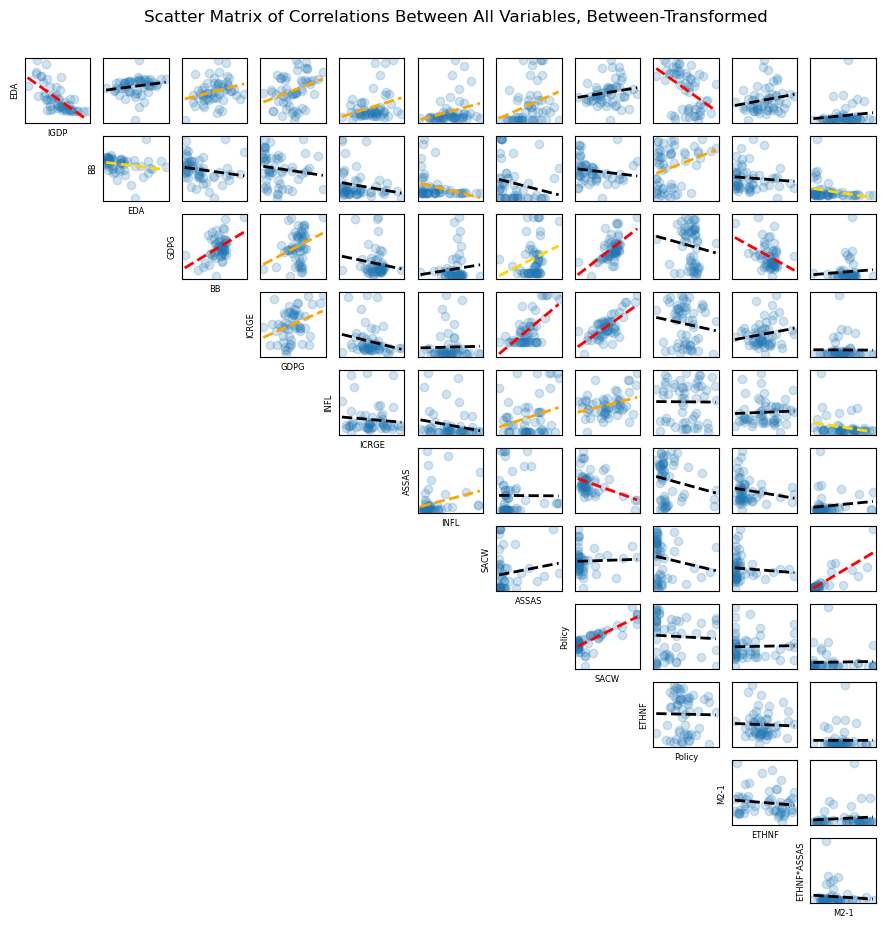

In [199]:
n = len(X_vars)

already_plotted = []

fig, ax = plt.subplots(n, n, figsize=(12,12), dpi=100, sharex=False, sharey=False)

for row, x_var in enumerate(x_vars_sorted):
    already_plotted.append(x_var)
    for col, y_var in enumerate(y_vars_sorted):
        if y_var in already_plotted:
            ax[row][col].set_visible(False)
        else:            
            x = between[x_var] 
            y = between[y_var]
            x_jitter = 0
            y_jitter = 0
            
            reg = np.polyfit(x, y, 1, full=False)
            slope, intercept = reg[0], reg[1]

            x_l = [min(x), max(x)]
            y_l = [xx * slope + intercept for xx in x_l]

            pearsons = stats.pearsonr(x, y)[1]
            if pearsons < 0.01: color = 'red'
            elif pearsons < 0.05: color = 'orange'
            elif pearsons < 0.10: color = 'gold'
            else: color = 'black'

            ax[row][col].scatter(x+x_jitter, y+y_jitter, alpha=0.2)
            ax[row][col].plot(x_l, y_l, ls='--',color=color, lw=2, zorder=10)
            
            ax[row][col].set_xticks([])
            ax[row][col].set_yticks([])
            
            if row == col-1:
                ax[row][col].set_xlabel(x_var, size=6)
                ax[row][col].set_ylabel(y_var, size=6)
                
#fig.legend([patches.Patch(facecolor='red', edgecolor='red'),
 #          patches.Patch(facecolor='orange', edgecolor='orange'),
  #         patches.Patch(facecolor='gold', edgecolor='gold')], 
   #        ['P < 0.01', 'P < 0.05', 'P < 0.10'], bbox_to_anchor=(.395,.31), ncol=3)

#fig.text(x=.18, y=.42, s='Read x-axis labels RIGHT and y-axis labels UP', zorder=3)
#fig.add_artist(patches.Rectangle((.14,.39), height=.1, width=.36, facecolor='whitesmoke', edgecolor='black', zorder=0))

fig.suptitle('Scatter Matrix of Correlations Between All Variables, Between-Transformed', size=12, x=0.55, y=.92)
plt.show()

Again we show the correlation plots. We can immediately see strong statistically significant correlations between GDPG and economic openness and budget balance; ICRGE and assassinations; openness and lagged money supply. we also see a negative correlation between EDA and policy which is equally interesting: countries with higher effective aid have worse policy.

## Untransformed Lag

In [200]:
print('Correlation for each variable and it\'s first lag, untransforrmed')
print('='*68)
print(' '*25 + 'Lag 1' + ' '*10 + 'Trend' + ' '*10 + 'N Obs')
print(' '*25 + '=====' + ' '*10 + '=====' + ' '*10 + '=====')

for var in X_vars:
    n_obs = str(overall.groupby('YEAR1').agg(np.nanmean)[var].shape[0])
    vals = overall.groupby('YEAR1').agg(np.nanmean)[var] * w
    line = ''
    corr, p = stats.pearsonr(vals.iloc[1:], vals.shift(1).dropna(), )
    line = var + ' '*(25 - len(var)) 
    if p < 0.01:
        stat = f'{corr:0.2f}***'
    elif p < 0.05:
        stat = f'{corr:0.2f}**'
    elif p < 0.10:
        stat = f'{corr:0.2f}*'
    else:
        stat = f'{corr:0.2f}'
    line += (stat + ' ' * (16 - len(stat)))

    corr, p = stats.pearsonr(vals, within.groupby('YEAR1').agg(np.nanmean)['Year'])
    if p < 0.01:
        stat = f'{corr:0.2f}***'
    elif p < 0.05:
        stat = f'{corr:0.2f}**'
    elif p < 0.10:
        stat = f'{corr:0.2f}*'
    else:
        stat = f'{corr:0.2f}'    
    
    line += (stat + ' ' * (16 - len(stat)))
    line += n_obs
    print(line)
print('\n')
print('*** - p < 0.01, ** - p < 0.05, * - p < 0.01')
print('Note: Pearson\'s correlation coefficient assumes normally distributed variables')

Correlation for each variable and it's first lag, untransforrmed
                         Lag 1          Trend          N Obs
                         =====          =====          =====
BB                       0.15            -0.18           6
INFL                     0.85*           0.97***         6
SACW                     0.89**          0.81*           6
GDPG                     0.36            -0.58           6
lGDP                     -0.34           0.59            6
ETHNF*ASSAS              -0.48           0.38            6
ETHNF                    0.09            0.10            6
ASSAS                    -0.44           0.52            6
ICRGE                    0.09            0.38            6
M2-1                     0.93**          0.98***         6
EDA                      0.87*           0.96***         6
Policy                   0.22            0.48            6


*** - p < 0.01, ** - p < 0.05, * - p < 0.01
Note: Pearson's correlation coefficient assumes normally di

We have also included the untransformed lag correlation for reference. It tells the same story as the within transformation, with macroeconomic variables like M2-1, EDA, SACW and INFL displaying persistence with high autocorrelation coefficients and trend coefficients. 

# 10. Comment the bivariate auto-correlation and trend-correlations (check the number of observations).

We commented above on the autocorrelation and trend correlations. To summarise, we saw macroeconomic variables like money supply, EDA and economic openess displaying higher degrees of persistence (high coefficients that are statistically significant). Some variables displayed negative autocorrelations like lGDP and ASSSAS, but neither were statistically significant. For all correlations, the number of observations is 6. For the within and untransformed, the number of observations for all variables is 6 which is the highest number of observations for the countries in the panel data which we saw in question 1.

# 11. Compare and comment the two-way within or first differences transformed bivariate correlation matrix for all variables (include a deterministic time trend 1,2,.,T). Check zero correlation with deterministic time trend. Check poor simple correlation with the dependent variables and high correlation between explanatory variables. Check the auto-correlation (with lag correctly computed for panel data).

## Two-Way

In [201]:
two_way = pd.merge(two_way_fe, df['Year'], how='inner', left_index=True, right_index=True).dropna()

In [202]:
n = len(X_vars_plus)
p_values = np.zeros((n,n))
output = np.zeros((n,n))

for i,var1 in enumerate(X_vars_plus):
    for j,var2 in enumerate(X_vars_plus):
        output[i][j] = stats.pearsonr(two_way[var1], two_way[var2])[0]
        p_values[i][j] = stats.pearsonr(two_way[var1], two_way[var2])[1]

output = pd.DataFrame(output, columns = X_vars_plus, index=X_vars_plus)
p_values = pd.DataFrame(p_values, columns = X_vars_plus, index=X_vars_plus)
new_out = pd.DataFrame()

for col in output.columns:
    temp = add_stars(output[col], p_values[col])
    temp.name = col
    new_out = pd.concat([new_out, temp], axis=1)
new_out.index = [x.replace(' ', '')[:6] for x in output.index]
new_out.columns = [x.replace(' ','')[:6] for x in new_out.columns]

print('Simple Correlation Matrix for two-way Transformed Variables')
print('='*110)
print(new_out)
print('\n')
print('*** - p < 0.01, ** - p < 0.05, * - p < 0.01')
print('Note: Pearson\'s correlation coefficient assumes normally distributed variables')

Simple Correlation Matrix for two-way Transformed Variables
             Year         BB       INFL       SACW       GDPG       lGDP  \
Year     1.000***      0.029  -0.336***  -0.391***   0.300***     -0.099   
BB          0.029   1.000***  -0.174***   0.222***   0.448***   0.199***   
INFL    -0.336***  -0.174***   1.000***      0.073  -0.344***   0.265***   
SACW    -0.391***   0.222***      0.073   1.000***   0.447***   0.270***   
GDPG     0.300***   0.448***  -0.344***   0.447***   1.000***   0.213***   
lGDP       -0.099   0.199***   0.265***   0.270***   0.213***   1.000***   
ETHNF*     -0.050      0.071      0.048     -0.021     -0.078      0.061   
ETHNF      -0.004   -0.141**  -0.171***     -0.037   -0.129**  -0.485***   
ASSAS    -0.124**    0.133**    0.155**      0.067     -0.079   0.183***   
ICRGE      -0.009   0.302***     -0.086   0.272***   0.389***   0.344***   
M2-1    -0.401***  -0.417***     -0.034   0.199***      0.038   0.191***   
EDA     -0.191***  -0.301***

Two-way transformed variables should control for both entity and time fixed effects. It should remove the influence of factors that are constant across time within a unit and factors that are constant across units within a time period. We still see a significant correlation for the macroeconomic variables with the year. For Inflation, economic openness, money supply, EDA and policy we see a negative, statistically significant correlation in all cases indicating presence of a negative trend in the variables that remains after the two-way transformation. Moving now to our main variable GDPG, many of the correlations are statistically significant. There is a negative correlation with inflation, ethnic fractionalisation, assassinations and effective development aid. This suggests that after controlling for time specific and entity specific fixed effects, aid and GDP growth are negatively associated.

In [203]:
# Sort X and Y axes of the scatter matrix by the sum of p-values (x = row-wise, y = col-wise)

n = len(X_vars_plus)
p_values = np.zeros((n,n))
for i,var1 in enumerate(X_vars_plus):
    for j,var2 in enumerate(X_vars_plus):
        p_values[i][j] = stats.pearsonr(two_way[var1], two_way[var2])[1]
                
p_values = pd.DataFrame(p_values, columns = X_vars_plus, index=X_vars_plus)

x_vars_sorted = p_values.sum().sort_values().index
y_vars_sorted = p_values.sum(axis=1).sort_values().index

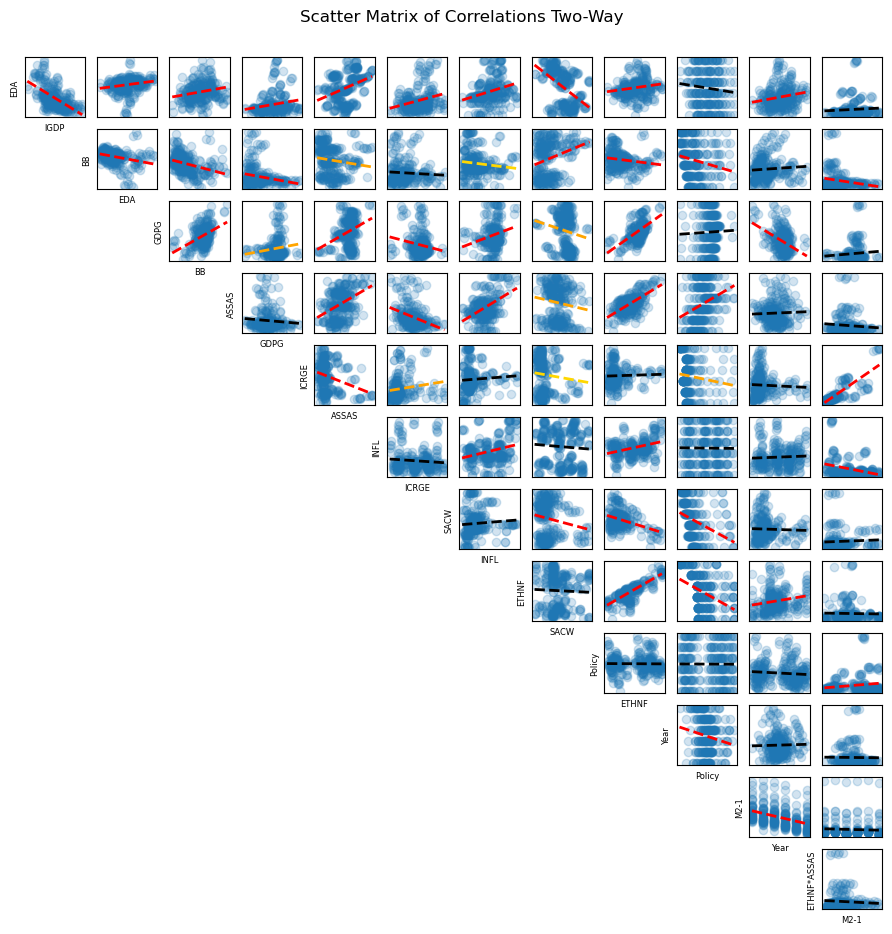

In [204]:
n = len(X_vars_plus)

already_plotted = []

fig, ax = plt.subplots(n, n, figsize=(12,12), dpi=100, sharex=False, sharey=False)

for row, x_var in enumerate(x_vars_sorted):
    already_plotted.append(x_var)
    for col, y_var in enumerate(y_vars_sorted):
        if y_var in already_plotted:
            ax[row][col].set_visible(False)
        else:            
            x = two_way[x_var] 
            y = two_way[y_var]
            x_jitter = 0
            y_jitter = 0
            
            reg = np.polyfit(x, y, 1, full=False)
            slope, intercept = reg[0], reg[1]

            x_l = [min(x), max(x)]
            y_l = [xx * slope + intercept for xx in x_l]

            pearsons = stats.pearsonr(x, y)[1]
            if pearsons < 0.01: color = 'red'
            elif pearsons < 0.05: color = 'orange'
            elif pearsons < 0.10: color = 'gold'
            else: color = 'black'

            ax[row][col].scatter(x+x_jitter, y+y_jitter, alpha=0.2)
            ax[row][col].plot(x_l, y_l, ls='--',color=color, lw=2, zorder=10)
            
            ax[row][col].set_xticks([])
            ax[row][col].set_yticks([])
            
            if row == col-1:
                ax[row][col].set_xlabel(x_var, size=6)
                ax[row][col].set_ylabel(y_var, size=6)
                
#fig.legend([patches.Patch(facecolor='red', edgecolor='red'),
 #          patches.Patch(facecolor='orange', edgecolor='orange'),
  #         patches.Patch(facecolor='gold', edgecolor='gold')], 
   #        ['P < 0.01', 'P < 0.05', 'P < 0.10'], bbox_to_anchor=(.395,.31), ncol=3)

#fig.text(x=.18, y=.42, s='Read x-axis labels RIGHT and y-axis labels UP', zorder=3)
#fig.add_artist(patches.Rectangle((.14,.39), height=.1, width=.36, facecolor='whitesmoke', edgecolor='black', zorder=0))

fig.suptitle('Scatter Matrix of Correlations Two-Way', size=12, x=0.55, y=.92)
plt.show()

The scatter matrix is displayed above. Immediately obvious is the significance of many of the correlations of EDA with the other variables. Notice the negative correlation with economic openness which is surprising. The positive correlation between assassinations and ethnic fractionalisation remains and is statistically significant. It is these observations that motivate the choice of 'interesting estimation' in question 18.

### Two-Way Lag

In [205]:
print('Correlation for each two-way transformed variable and it\'s first lag')
print('='*68)
print(' '*25 + 'Lag 1' + ' '*10 + 'Trend' + ' '*10 + 'N Obs')
print(' '*25 + '=====' + ' '*10 + '=====' + ' '*10 + '=====')

for var in X_vars:
    n_obs = str(two_way.groupby('YEAR1').agg(np.nanmean)[var].shape[0])
    vals = two_way.groupby('YEAR1').agg(np.nanmean)[var]
    line = ''
    corr, p = stats.pearsonr(vals.iloc[1:], vals.shift(1).dropna(), )
    line = var + ' '*(25 - len(var)) 
    if p < 0.01:
        stat = f'{corr:0.2f}***'
    elif p < 0.05:
        stat = f'{corr:0.2f}**'
    elif p < 0.10:
        stat = f'{corr:0.2f}*'
    else:
        stat = f'{corr:0.2f}'
    line += (stat + ' ' * (16 - len(stat)))

    corr, p = stats.pearsonr(vals, two_way.groupby('YEAR1').agg(np.nanmean)['Year'])
    if p < 0.01:
        stat = f'{corr:0.2f}***'
    elif p < 0.05:
        stat = f'{corr:0.2f}**'
    elif p < 0.10:
        stat = f'{corr:0.2f}*'
    else:
        stat = f'{corr:0.2f}'    
    
    line += (stat + ' ' * (16 - len(stat)))
    line += n_obs
    print(line)
print('\n')
print('*** - p < 0.01, ** - p < 0.05, * - p < 0.01')
print('Note: Pearson\'s correlation coefficient assumes normally distributed variables')

Correlation for each two-way transformed variable and it's first lag
                         Lag 1          Trend          N Obs
                         =====          =====          =====
BB                       0.18            0.11            6
INFL                     0.85*           -0.97***        6
SACW                     0.85*           -0.84**         6
GDPG                     0.33            0.61            6
lGDP                     0.96**          -0.87**         6
ETHNF*ASSAS              -0.17           -0.49           6
ETHNF                    -0.51           -0.22           6
ASSAS                    -0.13           -0.68           6
ICRGE                    -0.35           -0.33           6
M2-1                     0.91**          -0.98***        6
EDA                      0.83*           -0.92***        6
Policy                   0.24            -0.49           6


*** - p < 0.01, ** - p < 0.05, * - p < 0.01
Note: Pearson's correlation coefficient assumes normall

The two-way lag shows persistence in the same variables as the other transformations. The macroeconomic variables like money supply, EDA, Inflation and economic openness, which all had high correlations with year, display statistically significant coefficients with respect to their lag, all above 0.8. Notice again the number of observations equalling 6 because this is the maximum length of our panel data.

## First-Difference

In [206]:
year_map = {'1970-1973':1, '1974-1977':2, '1978-1981':3, '1982-1985':4, '1986-1989':5,'1990-1993':6}
df['Year'] = list(map(lambda x: year_map[x], df.index.get_level_values(1)))
first_diff = pd.merge(df_first_diff, df['Year'], how='inner', left_index=True, right_index=True).dropna()

In [207]:
first_diff.head()

GDPG     GDP        BB      INFL  SACW      GOVC  \
Country   YEAR1                                                             
Algeria   1974-1977  0.850419  2256.0  0.104941  0.035681   0.0 -3.126315   
Argentina 1974-1977 -0.622685  6168.0 -0.047971  0.649073   0.0  0.849498   
          1978-1981 -2.192900  5849.0  0.035167 -0.145128   0.0  0.042500   
Bolivia   1974-1977  1.665759  1838.0 -0.019711  0.068736   0.0  0.679886   
          1978-1981 -4.448338  2015.0 -0.011588  0.064507  -0.5  2.649355   

                     ETHNF  ASSAS  ICRGE       M2-1  SSA  EASIA      LPOP  \
Country   YEAR1                                                             
Algeria   1974-1977    0.0   0.00    0.0  12.359801    0      0  0.122992   
Argentina 1974-1977    0.0   7.00    0.0   3.968278    0      0  0.065703   
          1978-1981    0.0  -8.75    0.0   1.441477    0      0  0.061092   
Bolivia   1974-1977    0.0  -0.75    0.0   0.618742    0      0  0.097047   
          1978-1981    0.0   0.25    0.0   0.072805    0      0  0.094003   

                     EGYPT  CENTAM  FRZ  ARMS-1  DN1900       EDA      BEDA  \
Country   YEAR1                                                               
Algeria   1974-1977    0.0     0.0  0.0  -1.017       0 -0.531399 -0.408847   
Argentina 1974-1977    0.0     0.0  0.0  -0.308       1 -0.001083 -0.000222   
          1978-1981    0.0     0.0  0.0  -0.650       1  0.006839  0.002960   
Bolivia   1974-1977    0.0     0.0  0.0  -2.533       0  0.004669 -0.144777   
          1978-1981    0.0     0.0  0.0  -0.650       0  0.315823  0.179023   

                         MEDA     WBEDA    POPDEP  year_3  year_4  year_5  \
Country   YEAR1                                                             
Algeria   1974-1977 -0.122553  0.001251 -3.043000       1       0       0   
Argentina 1974-1977 -0.000861 -0.001498  1.469550       1       0       0   
          1978-1981  0.003878  0.000402  2.726917       0       1       0   
Bolivia   1974-1977  0.149445  0.067173 -0.034200       1       0       0   
          1978-1981  0.136800 -0.047787 -0.145217       0       1       0   

                     year_6  year_7  ETHNF*ASSAS      lGDP  Constant  \
Country   YEAR1                                                        
Algeria   1974-1977       0       0       0.0000  0.211466         1   
Argentina 1974-1977       0       0       2.1700  0.090023         1   
          1978-1981       0       0      -2.7125 -0.053104         1   
Bolivia   1974-1977       0       0      -0.5100  0.101258         1   
          1978-1981       0       0       0.1700  0.091941         1   

                       Policy  Year  
Country   YEAR1                      
Algeria   1974-1977  0.668440     2  
Argentina 1974-1977 -1.235821     2  
          1978-1981  0.443619     3  
Bolivia   1974-1977 -0.231017     2  
          1978-1981 -1.247810     3

In [208]:
n = len(X_vars)
p_values = np.zeros((n,n))
output = np.zeros((n,n))

for i,var1 in enumerate(X_vars):
    for j,var2 in enumerate(X_vars):
        output[i][j] = stats.pearsonr(first_diff[var1], first_diff[var2])[0]
        p_values[i][j] = stats.pearsonr(first_diff[var1], first_diff[var2])[1]

output = pd.DataFrame(output, columns = X_vars, index=X_vars)
p_values = pd.DataFrame(p_values, columns = X_vars, index=X_vars)
new_out = pd.DataFrame()

for col in output.columns:
    temp = add_stars(output[col], p_values[col])
    temp.name = col
    new_out = pd.concat([new_out, temp], axis=1)
new_out.index = [x.replace(' ', '')[:6] for x in output.index]
new_out.columns = [x.replace(' ','')[:6] for x in new_out.columns]

print('Simple Correlation Matrix for first-diff Variables')
print('='*110)
print(new_out)
print('\n')
print('*** - p < 0.01, ** - p < 0.05, * - p < 0.01')
print('Note: Pearson\'s correlation coefficient assumes normally distributed variables')

Simple Correlation Matrix for first-diff Variables
              BB       INFL       SACW       GDPG       lGDP    ETHNF* ETHNF  \
BB      1.000***     -0.098     0.135*      0.065      0.066    -0.041   nan   
INFL      -0.098   1.000***   -0.141**   -0.141**     -0.033     0.050   nan   
SACW      0.135*   -0.141**   1.000***   0.195***  -0.188***    -0.002   nan   
GDPG       0.065   -0.141**   0.195***   1.000***  -0.268***     0.016   nan   
lGDP       0.066     -0.033  -0.188***  -0.268***   1.000***     0.087   nan   
ETHNF*    -0.041      0.050     -0.002      0.016      0.087  1.000***   nan   
ETHNF        nan        nan        nan        nan        nan       nan   nan   
ASSAS     -0.055      0.077      0.038     -0.011      0.105  0.929***   nan   
ICRGE        nan        nan        nan        nan        nan       nan   nan   
M2-1       0.113   0.328***     -0.113     -0.105     -0.004     0.016   nan   
EDA        0.010     -0.041    0.169**      0.107  -0.281***    -0.00

The first differenced bivariate correlations shows not the correlation of one variable with another, but rather the correlation in changes of variables. Hence, the positive correlation coefficient between GDPG and SACW (economic openness) implies that a positive change in economic growth (a positive first difference GDPG) is associated with a positive change in economic openness. Some of the time invariant variables like ethnic fractionalisation and country risk have nan correlations because the first-difference is 0. Examination of the column GDPG yields fewer statistically significant correlations that the previous transformations. Notable is the negative correlations with inflation and the log of GDP. This means that increasing inflation and an increase in log GDP is associated with a fall in the rate of GDP growth. This, at first glance, looks like a bit of a puzzle and I first expected the first difference of GDPG to be positively associated with the first difference of log GDP by virtue of their mathematical definitions. However, what this means is that an increase in log GDP (a percentage increase in GDP) is associated with a fall in the rate of GDPG. GDPG can still be positive, but it may be decreasing. The first difference of GDPG is akin to taking the second derivative of GDP which is decreasing in GDP (because of this coefficient).

GDPG is however positively associated with openness and policy. This suggests that an improvement in economic openness and policy causes an acceleration in the rate of GDP growth. The coefficient of GDPG and EDA is positive, suggesting that an increase in effective aid accelerates GDP growth, but is not statistically significant.

### First-Diff Lag

In [209]:
print('Correlation for each first-diff transformed variable and it\'s first lag')
print('='*68)
print(' '*25 + 'Lag 1' + ' '*10 + 'Trend' + ' '*10 + 'N Obs')
print(' '*25 + '=====' + ' '*10 + '=====' + ' '*10 + '=====')

for var in X_vars:
    n_obs = str(first_diff.groupby('YEAR1').agg(np.nanmean)[var].shape[0])
    vals = first_diff.groupby('YEAR1').agg(np.nanmean)[var]
    line = ''
    corr, p = stats.pearsonr(vals.iloc[1:], vals.shift(1).dropna(), )
    line = var + ' '*(25 - len(var)) 
    if p < 0.01:
        stat = f'{corr:0.2f}***'
    elif p < 0.05:
        stat = f'{corr:0.2f}**'
    elif p < 0.10:
        stat = f'{corr:0.2f}*'
    else:
        stat = f'{corr:0.2f}'
    line += (stat + ' ' * (16 - len(stat)))

    corr, p = stats.pearsonr(vals, first_diff.groupby('YEAR1').agg(np.nanmean)['Year'])
    if p < 0.01:
        stat = f'{corr:0.2f}***'
    elif p < 0.05:
        stat = f'{corr:0.2f}**'
    elif p < 0.10:
        stat = f'{corr:0.2f}*'
    else:
        stat = f'{corr:0.2f}'    
    
    line += (stat + ' ' * (16 - len(stat)))
    line += n_obs
    print(line)
print('\n')
print('*** - p < 0.01, ** - p < 0.05, * - p < 0.01')
print('Note: Pearson\'s correlation coefficient assumes normally distributed variables')

Correlation for each first-diff transformed variable and it's first lag
                         Lag 1          Trend          N Obs
                         =====          =====          =====
BB                       0.08            0.59            5
INFL                     -0.53           -0.14           5
SACW                     0.74            0.84*           5
GDPG                     -0.12           0.42            5
lGDP                     0.72            -0.87*          5
ETHNF*ASSAS              -0.49           0.06            5
ETHNF                    nan             nan             5
ASSAS                    -0.25           0.19            5
ICRGE                    nan             nan             5
M2-1                     -0.75           -0.49           5
EDA                      0.70            0.95**          5
Policy                   0.47            0.78            5


*** - p < 0.01, ** - p < 0.05, * - p < 0.01
Note: Pearson's correlation coefficient assumes norm

The lag is always interesting for first differences. It helps indicate whether a variable could be explosive; where an increase in x is associated with an increase in x in the period before. A negative coefficient is indicative of an equilibrium effect or 'error correction'. This is where an increase in say, inflation, is followed by a decrease in inflation. Variables with a negative correlation coefficient are as follows: INFL, GDPG, ETHNF*ASSAS (and ASSAS of course), M2-1. These are macroeconomic variables for the most part and suggest countries return to an equilibrium level. However, all of these autocorrelation coefficients are statistically insignificant. Macroeconomic variables tend to be integrated of order 1 and become stationary when they are first differenced, and this is shown in this table. Stationary time series does not have covariance with past values and this is the case here. Regarding the trend, there are three statistically significant coefficients, openness, logged GDP and EDA. The negative coefficient for log GDP suggests that the changes in GDP decline over time (perhaps indicating growing economic stability), but the positive coefficients for openness and EDA suggest that aid and openness has been increasing by increasing amounts over time.

# 12. Comment the bivariate graphs with linear, quadratic and Lowess fit for dependent and key explanatory variable (aid/gdp and growth of gdp): Within transformed, Between transformed, First differences, two-way-within transformed.

In [210]:
df.to_csv('/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Panel Data/Homework/df.csv', index=False)

## Untransformed EDA and GDPG

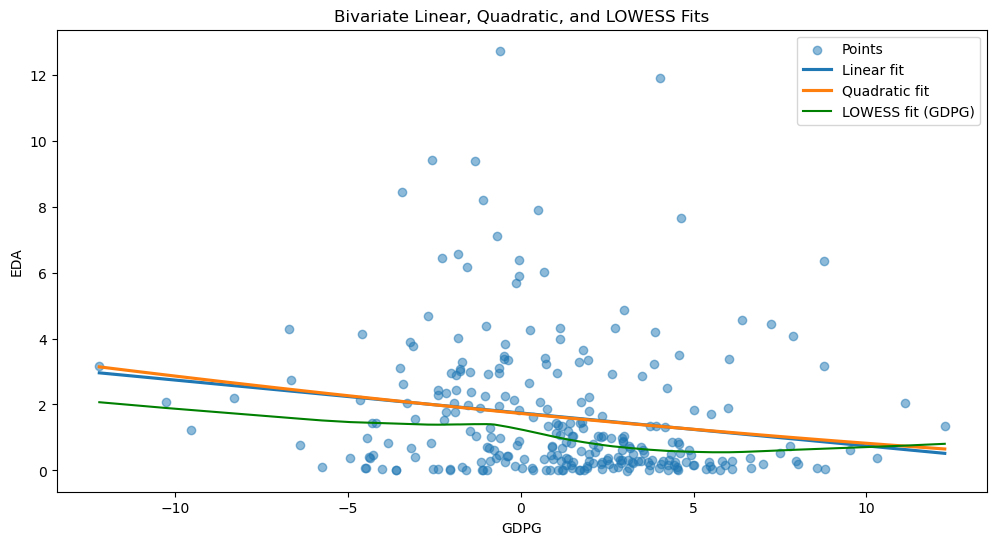

In [211]:
from statsmodels.nonparametric.smoothers_lowess import lowess

frac = 0.7 
lowess_gdpg = lowess(df['EDA'], df['GDPG'], frac=frac)

plt.figure(figsize=(12, 6))
plt.scatter(df['GDPG'], df['EDA'], alpha=0.5, label='Points')
sns.regplot(x='GDPG', y='EDA', data=df, ci=None, label='Linear fit', scatter=False)
sns.regplot(x='GDPG', y='EDA', data=df, ci=None, order=2, label='Quadratic fit', scatter=False)
plt.plot(lowess_gdpg[:, 0], lowess_gdpg[:, 1], 'g-', label='LOWESS fit (GDPG)')


plt.xlabel('GDPG')
plt.ylabel('EDA')
plt.title('Bivariate Linear, Quadratic, and LOWESS Fits')
plt.legend()

# Show plot
plt.show()

LOWESS is locally weighted scatterplot smoothing. It fits a weighted least squares regression to a subset of datapoints that are near to x, with the 'frac' parameter determining the bandwidth. Datapoints closer to x are given more weight and the resulting LOWESS is a smooth curve fit through the datapoints. To increase the bandwidth, and potentially induce underfitting, the frac parameter can be increased. 

For the untransformed data, linear, quadratic and lowess struggle to fit the datapoints. There appears to be no rhyme or reason to the points so the models cannot fit the data.

## Within and Between Transformed

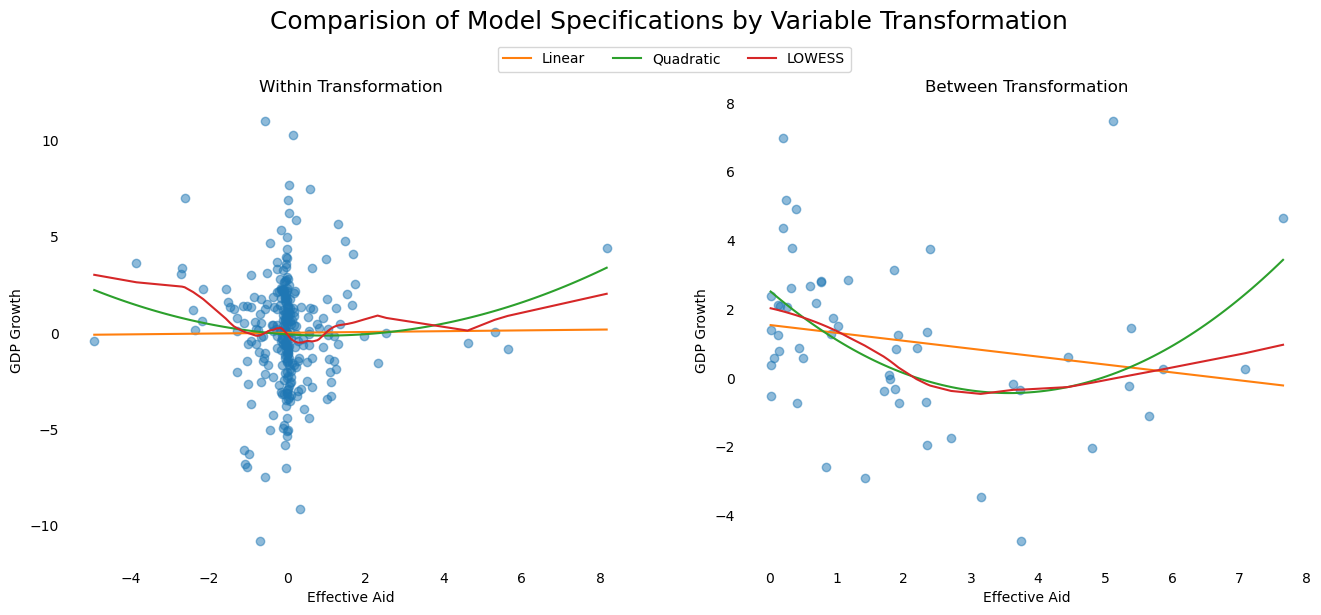

In [212]:
fig, ax = plt.subplots(1,2, figsize=(16,6), dpi=100)
transforms = [within, between]
cmap = cm.get_cmap('tab10')
gradient = cmap(np.linspace(0,1,10))

for axis, transform in zip(fig.axes, transforms):
    if transform is within: title = 'Within Transformation'
    else: title = 'Between Transformation'

    x = transform['EDA']
    y = transform['GDPG']
    
    xl_1, xl_0 = np.polyfit(x, y, 1, full=False)
    xq_2, xq_1, xq_0 = np.polyfit(x, y, 2, full=False)
    
    xl = [min(x), max(x)]
    yl = [xx * xl_1 + xl_0 for xx in xl]
    
    xq = np.linspace(min(x), max(x), 100)
    yq = [xx**2*xq_2 + xx*xq_1 + xq_0 for xx in xq]
    
    lowess = sm.nonparametric.lowess(y, x, frac=0.7)
    
    axis.scatter(x, y, alpha=0.5, color=gradient[0].squeeze().tolist())
    axis.plot(xl, yl, color=gradient[1].squeeze().tolist(), label='Linear')
    axis.plot(xq, yq, color=gradient[2].squeeze().tolist(), label='Quadratic')
    axis.plot(lowess[:,0], lowess[:,1], color=gradient[3].squeeze().tolist(), label='LOWESS')
    
    for spine in axis.spines.values():
        spine.set_visible(False)
    axis.tick_params(which='both',
                    axis='both',
                    left=False,
                    right=False,
                    top=False,
                    bottom=False)
    axis.set_title(title)
    axis.set_xlabel('Effective Aid')
    axis.set_ylabel('GDP Growth')
    
ax[0].legend(ncol=3, bbox_to_anchor=(1.4,1.13))
fig.suptitle('Comparision of Model Specifications by Variable Transformation', fontsize=18, y=1.03)
plt.show()

Considering now the within and between transformed variables. The datapoints for within are concentrated around the EDA = 0 line, with differing levels of GDP growth for this level of EDA. All plots struggle to fit the data and we can see the LOWESS fit wiggling up and down as the bandwidth changes. Should we decrease the frac parameter, this wiggling would become more pronounced as the LOWESS attempts to incorporate all outliers and datapoints.

The fits for the between transformation are slightly more promising. There is a trend with a bow in the datapoints, and the quadratic and LOWESS models get closer to fitting. The linear model does a hopeless job.

## First-Diff and Two-Way Transformed

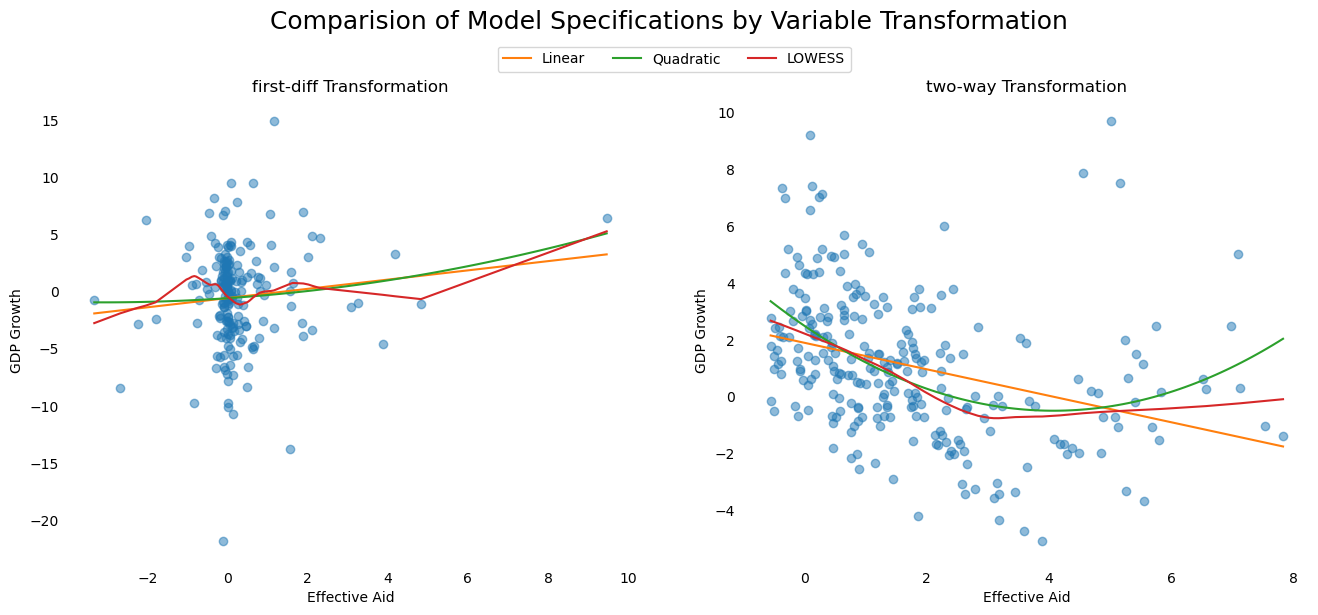

In [213]:
fig, ax = plt.subplots(1,2, figsize=(16,6), dpi=100)
transforms = [first_diff, two_way]
cmap = cm.get_cmap('tab10')
gradient = cmap(np.linspace(0,1,10))

for axis, transform in zip(fig.axes, transforms):
    if transform is first_diff: title = 'first-diff Transformation'
    else: title = 'two-way Transformation'

    x = transform['EDA']
    y = transform['GDPG']
    
    xl_1, xl_0 = np.polyfit(x, y, 1, full=False)
    xq_2, xq_1, xq_0 = np.polyfit(x, y, 2, full=False)
    
    xl = [min(x), max(x)]
    yl = [xx * xl_1 + xl_0 for xx in xl]
    
    xq = np.linspace(min(x), max(x), 100)
    yq = [xx**2*xq_2 + xx*xq_1 + xq_0 for xx in xq]
    
    lowess = sm.nonparametric.lowess(y, x, frac=0.7)
    
    axis.scatter(x, y, alpha=0.5, color=gradient[0].squeeze().tolist())
    axis.plot(xl, yl, color=gradient[1].squeeze().tolist(), label='Linear')
    axis.plot(xq, yq, color=gradient[2].squeeze().tolist(), label='Quadratic')
    axis.plot(lowess[:,0], lowess[:,1], color=gradient[3].squeeze().tolist(), label='LOWESS')
    
    for spine in axis.spines.values():
        spine.set_visible(False)
    axis.tick_params(which='both',
                    axis='both',
                    left=False,
                    right=False,
                    top=False,
                    bottom=False)
    axis.set_title(title)
    axis.set_xlabel('Effective Aid')
    axis.set_ylabel('GDP Growth')
    
ax[0].legend(ncol=3, bbox_to_anchor=(1.4,1.13))
fig.suptitle('Comparision of Model Specifications by Variable Transformation', fontsize=18, y=1.03)
plt.show()

For the first differenced data, we get the same cloud at EDA = 0 as with the within transformation, making the datapoints hard to follow. Lowess does the best job, because it has the slight upward jump after EDA = 0 to follow the trend in the data. The two-way transformation is better, there is a trend identifiable with visual examination and the bow in the data is fit fairly well by the LOWESS and quadratic. The linear trend encompasses the downward trend but cannot then encompass the upward trend or plateau after EDA = 4.

# 13. Comment the results of estimations of Between, Within (one-way fixed effects, (fe)) and Mundlak (random effects (re) including all X(i.) as regressors), two-way fixed effects (add year dummies in fe regression) and First differences, including all explanatory variables except the ones with high near-multicollinearity in their respective between or within space.

In [214]:
Exog_vars = ['lGDP', 'ETHNF', 'ASSAS', 'ETHNF*ASSAS', 'ICRGE',
             'M2-1', 'Policy', 'SSA', 'EASIA', 'EDA']

## Between

In [215]:
import linearmodels as lm

_df = df.reset_index().set_index(['Country', 'Year']) 
_df['Clusters'] = list(map(lambda x: np.sum([ord(xx) for xx in x]), _df.index.get_level_values(0)))

y = _df['GDPG']
x = _df[Exog_vars]

model = lm.BetweenOLS(y, sm.add_constant(x)).fit(cov_type='clustered', clusters= _df['Clusters'])
between_results = save_results(model, 'Between')
model.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                         BetweenOLS Estimation Summary                          
================================================================================
Dep. Variable:                   GDPG   R-squared:                        0.6003
Estimator:                 BetweenOLS   R-squared (Between):              0.6003
No. Observations:                  56   R-squared (Within):              -0.0330
Date:                Sun, Jan 07 2024   R-squared (Overall):              0.2028
Time:                        20:19:28   Log-likelihood                   -101.94
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.7597
Entities:                          56   P-value                           0.0000
Avg Obs:                       4.9107   Distribution:                   F(10,45)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             11.277
                                        P-value                           0.0000
Time periods:                       6   Distribution:                   F(10,45)
Avg Obs:                       45.833                                           
Min Obs:                       41.000                                           
Max Obs:                       49.000                                           
                                                                                
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
const          -3.3229     5.1935    -0.6398     0.5255     -13.783      7.1374
lGDP            0.0947     0.7181     0.1319     0.8956     -1.3516      1.5411
ETHNF          -0.1547     1.1016    -0.1404     0.8890     -2.3734      2.0641
ASSAS          -0.2077     0.4562    -0.4552     0.6511     -1.1266      0.7112
ETHNF*ASSAS     0.3786     0.8984     0.4214     0.6754     -1.4308      2.1880
ICRGE           0.2939     0.2650     1.1093     0.2732     -0.2398      0.8276
M2-1            0.0235     0.0272     0.8657     0.3913     -0.0312      0.0783
Policy          1.6296     0.3834     4.2500     0.0001      0.8573      2.4018
SSA            -1.2923     0.9183    -1.4073     0.1662     -3.1419      0.5572
EASIA           0.2408     0.8094     0.2975     0.7674     -1.3893      1.8710
EDA             0.1826     0.2198     0.8310     0.4104     -0.2600      0.6253
===============================================================================
"""

For the between regression, the $R^2$ is fairly high, with 60% of the variation in the data being explained by our explanatory variables. Only policy has a statistically significant p-value however. Note that linearmodels will automatically absorb variables that are collinear and print a message to notify us.

### Without insignificant VARs

In [216]:
#Run a restricted model without the insignificant variables
restricted = lm.BetweenOLS(y, sm.add_constant(_df['Policy'])).fit(cov_type='clustered', clusters=_df['Clusters'])

q = len(Exog_vars) - 2
n = _df.shape[0]
k = len(Exog_vars)

SSR_R = restricted.resid_ss
SSR_UR = model.resid_ss

F = ((SSR_R - SSR_UR) / q) / ((SSR_UR)/(n-k-1))

print('F-test of equivilant variance')
print('H0: Var(Restricted) = Var(Unrestricted)')
print(f'df1 = {q}, df2={n-k-1}')
print('='*40)
print(f'F-stat = {F:0.03f}')
print(f'p = {stats.f.sf(F, q, n-k-1):0.3f}') #f.sf is the survivor function for f, and tells what % is beyond our value

F-test of equivilant variance
H0: Var(Restricted) = Var(Unrestricted)
df1 = 8, df2=264
F-stat = 7.041
p = 0.000


Removing the insignificant variables, only the policy and constant model is significantly different than the full model and we continue with the model with the statistically insignificant variables.

In [217]:
def resid_plot(x, model, title, transform, resids=None, y_hat=None, labels_x = False, labels_y = False, outlier_x=None, outlier_y=None, color_col=None):
    from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
    
    cmap = cm.get_cmap('tab20')
    gradient = cmap(np.linspace(0,1,10))

    if transform == 'between':
        X = x.groupby('Country').agg(np.mean).values
    else: X = x.values.squeeze()
        
    H = X @ np.linalg.inv(X.T @ X) @ X.T
    
    if isinstance(model, sm.regression.linear_model.RegressionResultsWrapper):
        student_resid = model.resid.values / (model.resid.std() * np.sqrt(1 - np.diag(H)))
    elif model is None:
        student_resid = resids.values / (resids.std() * np.sqrt(1 - np.diag(H)))
    else:
        student_resid = model.resids.values / (model.resids.std() * np.sqrt(1 - np.diag(H)))
    
    if transform == 'between':
        avg_y_hat = model.predict(x).groupby('Country').agg(np.mean)
    elif model is None:
        avg_y_hat = y_hat.to_frame()
        avg_y_hat.columns = ['predictions']
    else:    
        avg_y_hat = model.predict(x)
        
    if isinstance(model, sm.regression.linear_model.RegressionResultsWrapper):
        avg_y_hat = avg_y_hat.to_frame()
        avg_y_hat.columns = ['predictions']
        
    mean_resid = student_resid.mean()
    std_resid = student_resid.std()
    skew_resid = stats.skew(student_resid)
    kur_resid = stats.kurtosis(student_resid, fisher=False)

    mean_yhat = avg_y_hat['predictions'].mean()
    std_yhat = avg_y_hat['predictions'].std()
    skew_yhat = stats.skew(avg_y_hat['predictions'])
    kur_yhat = stats.kurtosis(avg_y_hat['predictions'], fisher=False)

    gs = GridSpec(4, 4)
    fig = plt.figure(figsize=(8,6), dpi=100)

    ax_main = fig.add_subplot(gs[1:4, 0:3])
    ax_x = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
    ax_y = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

    if color_col is not None:
        color_by = color_col.name
        y_hat_plus = pd.merge(avg_y_hat, color_col, left_index=True, right_index=True)
        y_hat_plus['resids'] = student_resid
        _temp_df = y_hat_plus.groupby(color_by)
        for i, group in enumerate(_temp_df.groups.keys()):
            yy = _temp_df.get_group(group)['predictions'].values.squeeze()
            xx = _temp_df.get_group(group)['resids'].values.squeeze()
            ax_main.scatter(yy, xx, alpha=0.6, zorder=2, color=gradient[i], label=group)
            
        ax_main.legend(fontsize=8)
        
    else:
        ax_main.scatter(avg_y_hat, student_resid, alpha=0.6, zorder=2)

    sns.kdeplot(avg_y_hat['predictions'], shade=True, ax=ax_x, legend=False, zorder=2)
    sns.kdeplot(student_resid, shade=True, ax=ax_y, vertical=True, zorder=2)
    ax_main.set_xlabel('$\hat{y}_{i,.}$')
    ax_main.set_ylabel('Studentized Residuals')

    for xx, yy, name in zip(avg_y_hat['predictions'], student_resid, df.index):   
        if labels_x == True and labels_y == False:
            if (xx < outlier_x[0] or xx > outlier_x[1]):
                text = re.findall("(?<=\')(\w+\W? ?\w*\W? ?\w*)(?=\')",str(name))
                s = text[0] + '\n' + text[-1]
                ax_main.text(xx,yy,s, size=5)
                
        elif labels_x == False and labels_y == True:
            if (yy > outlier_y[1]) or (yy < outlier_y[0]):
                text = re.findall("(?<=\')(\w+\W? ?\w*\W? ?\w*)(?=\')",str(name))
                s = text[0] + '\n' + text[-1]
                ax_main.text(xx,yy,s, size=5)
        
        elif labels_x == True and labels_y == True:
            if (xx < outlier_x[0] or xx > outlier_x[1]) or (yy > outlier_y[1] or yy < outlier_y[0]):
                text = re.findall("(?<=\')(\w+\W? ?\w*\W? ?\w*)(?=\')",str(name))
                s = text[0] + '\n' + text[-1]
                ax_main.text(xx,yy,s, size=5)

    for axis in fig.axes:
        for spine in axis.spines.values():
            spine.set_visible(False)

        axis.tick_params(which='both',
                      axis='both',
                      left=False,
                      right=False,
                      top=False,
                      bottom=False)
        axis.set_facecolor('ghostwhite')
        axis.grid(True, color='white', zorder=1, lw=2)

    plt.setp(ax_x.get_xticklabels(), visible=False)
    plt.setp(ax_x.get_yticklabels(), visible=False)
    plt.setp(ax_y.get_xticklabels(), visible=False)
    plt.setp(ax_y.get_yticklabels(), visible=False)

    left_corner_x = ax_x.get_xlim()[0]
    left_corner_y = ax_x.get_ylim()[1]
    u_y = (ax_x.get_ylim()[1] - ax_x.get_ylim()[0]) / 100 
    u_x = (ax_x.get_xlim()[1] - ax_x.get_xlim()[0]) / 100 

    for i, (name, value) in enumerate(zip(['μ', 'σ', 'skew', 'kurtosis'], [mean_yhat, std_yhat, skew_yhat, kur_yhat])):
        ax_x.text(0.95 * left_corner_x, 0.9*left_corner_y-(u_y * (12*i)), s=f'{name}={value:0.2f}', fontsize=8)

    right_corner_x = ax_y.get_xlim()[1]
    right_corner_y = ax_y.get_ylim()[1]
    u_y = (ax_y.get_ylim()[1] - ax_y.get_ylim()[0]) / 100 
    u_x = (ax_y.get_xlim()[1] - ax_y.get_xlim()[0]) / 100     

    for i, (name, value) in enumerate(zip(['μ', 'σ', 'skew', 'kurtosis'], [mean_resid, std_resid, skew_resid, kur_resid])):
        ax_y.text(0.5*right_corner_x, 0.9*right_corner_y - (u_y * (4*i)), s=f'{name}={value:0.2f}', fontsize=8)

    plt.tight_layout()
    fig.suptitle('Studentized Residuals and Predicted Average $\hat{y}_{i,.}$, with Distributions \n' +  f'{title}',
                 y=1.065, size=14, fontweight='semibold')
    plt.show()

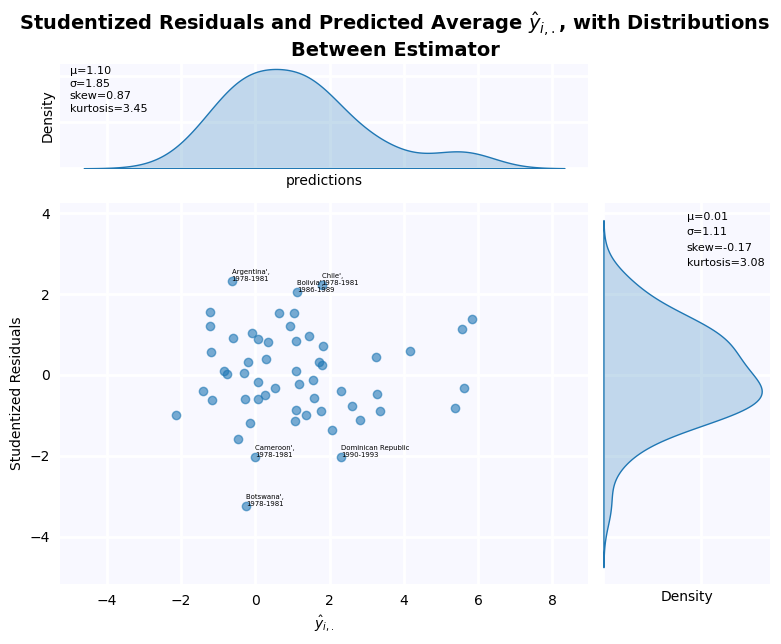

In [218]:
resid_plot(x = sm.add_constant(x), model=model, title='Between Estimator',
           transform='between', labels_y=True, outlier_y=(-2, 2))

Examination of the residuals is always useful. We want to see a normal distribution, and indeed the skewness is low, and the kurtosis is close to the standard value of 3.

## Within

Before we begin with the within fixed effects, we remove the time invariant variables from our explanatory variables. ICRGE, ETHNF and the geographical dummies SSA and EASIA are removed.

In [219]:
Exog_vars_within = set(Exog_vars) - set(['ICRGE', 'ETHNF', 
                                        'SSA', 'EASIA'])
Exog_vars_within = list(Exog_vars_within)

x = _df[Exog_vars_within]
within_fe = lm.PanelOLS(y, x, entity_effects=True, time_effects=False, drop_absorbed=True).fit(cov_type='clustered', clusters=_df['Clusters'])
fe_results = save_results(within_fe, 'Fixed Effects')
within_fe.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                   GDPG   R-squared:                        0.1602
Estimator:                   PanelOLS   R-squared (Between):             -149.88
No. Observations:                 275   R-squared (Within):               0.1602
Date:                Sun, Jan 07 2024   R-squared (Overall):             -72.574
Time:                        20:19:33   Log-likelihood                   -653.88
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.7737
Entities:                          56   P-value                           0.0000
Avg Obs:                       4.9107   Distribution:                   F(6,213)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             9.5741
                                        P-value                           0.0000
Time periods:                       6   Distribution:                   F(6,213)
Avg Obs:                       45.833                                           
Min Obs:                       41.000                                           
Max Obs:                       49.000                                           
                                                                                
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
ETHNF*ASSAS     1.0519     0.4864     2.1628     0.0317      0.0932      2.0107
Policy          0.9289     0.1678     5.5370     0.0000      0.5982      1.2596
ASSAS          -0.5371     0.3384    -1.5873     0.1139     -1.2040      0.1299
EDA            -0.1227     0.1838    -0.6674     0.5052     -0.4850      0.2397
lGDP           -4.0686     1.4016    -2.9029     0.0041     -6.8314     -1.3059
M2-1           -0.0417     0.0249    -1.6769     0.0950     -0.0907      0.0073
===============================================================================

F-test for Poolability: 1.7902
P-value: 0.0018
Distribution: F(55,213)

Included effects: Entity
"""

The $R^2$ for the within fixed effects is much lower at 0.16, meaning 16% of the variation in the dependent variable is explained by our explanatory variables. The p-values are more promising however. Policy remains statistically significant, the log of GDP, the lagged money supply and the interaction ETHNF*ASSASS are also statistically significant at at least the 90% confidence level. EDA remains statistically insignificant suggesting that, controlling for entity fixed effects, effective aid does not have a statistically significant impact on GDP growth. Considering also the sign of the parameters, EDA has a negative coefficient, assassinations and log of GDP also. 

## Two-way

In [220]:
within_fete = lm.PanelOLS(y, x, entity_effects=True, time_effects=True, drop_absorbed=True).fit(cov_type='clustered', clusters=_df['Clusters'])
fete_results = save_results(within_fete, 'Fixed/Time Effects')
within_fete.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                   GDPG   R-squared:                        0.1017
Estimator:                   PanelOLS   R-squared (Between):             -38.190
No. Observations:                 275   R-squared (Within):               0.1159
Date:                Sun, Jan 07 2024   R-squared (Overall):             -18.671
Time:                        20:19:34   Log-likelihood                   -633.25
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.9248
Entities:                          56   P-value                           0.0010
Avg Obs:                       4.9107   Distribution:                   F(6,208)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             4.1897
                                        P-value                           0.0005
Time periods:                       6   Distribution:                   F(6,208)
Avg Obs:                       45.833                                           
Min Obs:                       41.000                                           
Max Obs:                       49.000                                           
                                                                                
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
ETHNF*ASSAS     1.2619     0.4944     2.5522     0.0114      0.2871      2.2367
Policy          0.8400     0.2145     3.9168     0.0001      0.4172      1.2628
ASSAS          -0.6544     0.2653    -2.4667     0.0144     -1.1774     -0.1314
EDA             0.1416     0.2019     0.7013     0.4839     -0.2565      0.5397
lGDP           -2.1733     1.5302    -1.4203     0.1570     -5.1900      0.8433
M2-1            0.0015     0.0297     0.0490     0.9609     -0.0571      0.0600
===============================================================================

F-test for Poolability: 2.4232
P-value: 0.0000
Distribution: F(60,208)

Included effects: Entity, Time
"""

Considering now the two-way transformation controlling for both entity and time fixed effects, EDA remains statistically insignificant. Policy is still statistically significant, along with assassinations and the interaction term (probably driven by assassinations). The $R^2$ is even lower at 0.1 probably driven by the outliers we identified in question 6.

## Fixed-Effects Summary

In [221]:
pd.merge(fe_results, fete_results, left_index=True, right_index=True)

Fixed Effects Fixed/Time Effects
ETHNF*ASSAS       1.052**            1.262**
Policy           0.929***           0.840***
ASSAS              -0.537           -0.654**
EDA                -0.123              0.142
lGDP            -4.069***             -2.173
M2-1              -0.042*              0.001
r2               0.160235           0.101701

In summary, the policy parameter is always statistically significant at the 99% level. The sign on the coefficient for EDA changes for within and two-way, but both are statistically insignificant. The lagged money supply is significant and negative for within, but is insignificant and positive (just) for two-way. Assassinations is negative for both models, but only when controlling for entity and time fixed effects is the coefficient statistically significant. The $R^2$ is higher for within fixed effects.

## Within Residuals

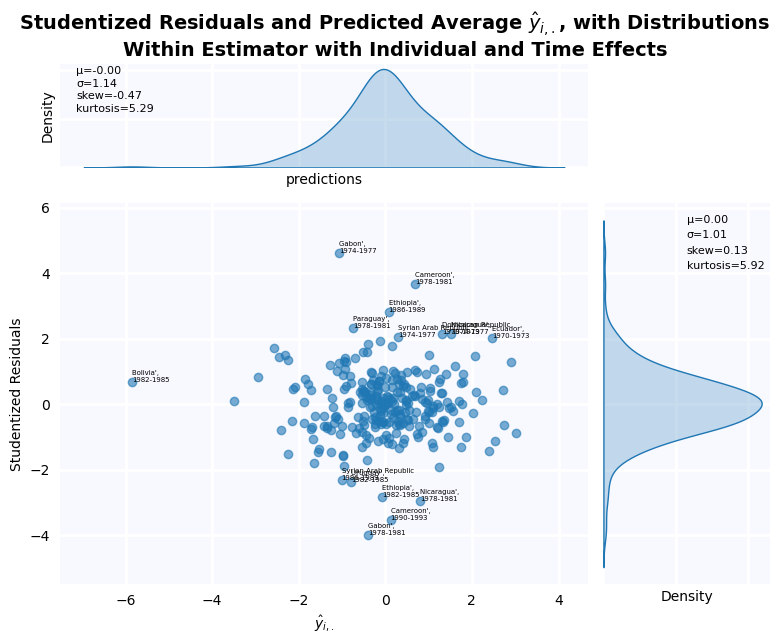

In [222]:
within_x = x.groupby('Country').transform(lambda x: x - x.mean())
resid_plot(within_x, 
           model=within_fe, title='Within Estimator with Individual and Time Effects',
           transform='within', labels_y=True, outlier_y=(-2,2),
          labels_x=True, outlier_x=(-5,5))

The within residuals are similar to the between; there is little skewness and kurtosis is nothing severe. There are a few 'outlier' residuals like Gabon, Cameroon and Bolivia which contribute to the skewness.

## Regional Analysis

Here the plot is coloured to show the location of the different regions, SSA, EASIA, EGYPT and CENTAM on the residual distribution.

In [224]:
def make_regions_var(dummy_frame):
    for col in dummy_frame.index:
        if dummy_frame[col] > 0:
            return col
    return 'Other'

region_dummies = _df[['EASIA', 'EGYPT', 'SSA', 'CENTAM']].copy()
region_dummies = region_dummies.apply(make_regions_var, axis=1)
region_dummies.name = 'Region'

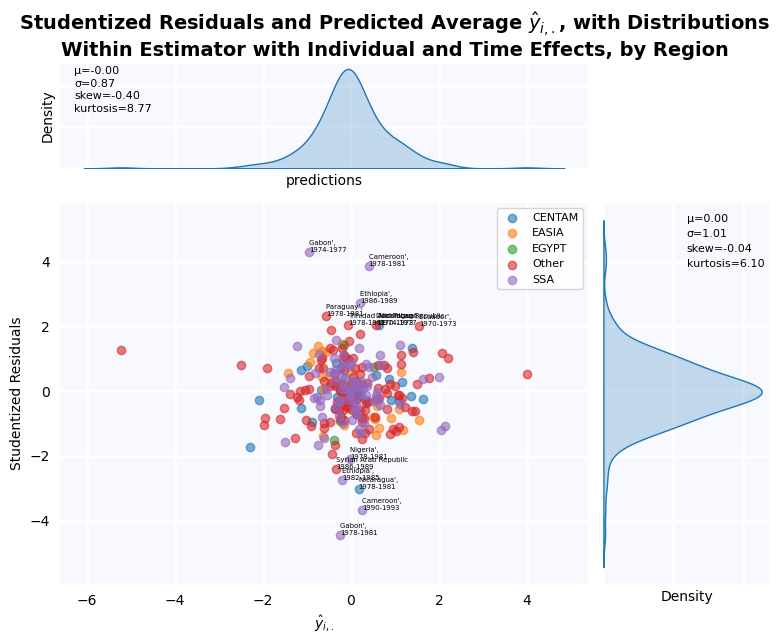

In [225]:
resid_plot(within_x, model=within_fete, transform='within', title='Within Estimator with Individual and Time Effects, by Region',
           labels_y=True, outlier_y=(-2,2), color_col = region_dummies)

The sub-saharan african countries contribute to the skewness a lot, with Gabon being at both the far north and far south of the residuals.

## Random Effects

Considering now the random effects model. The random effects model assumes that the unobserved individual effect is uncorrelated with the independent variables.  The Hausman test is ordinarily used to distinguish between the fixed effect and random effect model.

In [226]:
y = _df['GDPG'] 
time_effects = ['year_3', 'year_4', 'year_5', 'year_6', 'year_7']
x = sm.add_constant(_df[Exog_vars + time_effects])
ref = lm.panel.RandomEffects(y, x).fit(small_sample=True, cov_type='clustered', clusters=_df['Clusters'])
re_results = save_results(ref, 'Random Effects')
ref.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                        RandomEffects Estimation Summary                        
================================================================================
Dep. Variable:                   GDPG   R-squared:                        0.3598
Estimator:              RandomEffects   R-squared (Between):              0.5265
No. Observations:                 275   R-squared (Within):               0.2633
Date:                Sun, Jan 07 2024   R-squared (Overall):              0.3911
Time:                        20:19:40   Log-likelihood                   -664.20
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      9.7044
Entities:                          56   P-value                           0.0000
Avg Obs:                       4.9107   Distribution:                  F(15,259)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             19.475
                                        P-value                           0.0000
Time periods:                       6   Distribution:                  F(15,259)
Avg Obs:                       45.833                                           
Min Obs:                       41.000                                           
Max Obs:                       49.000                                           
                                                                                
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
const           3.3826     3.8986     0.8676     0.3864     -4.2944      11.060
lGDP           -0.6026     0.5280    -1.1412     0.2548     -1.6424      0.4372
ETHNF          -0.5015     0.8977    -0.5587     0.5769     -2.2691      1.2662
ASSAS          -0.4897     0.2018    -2.4263     0.0159     -0.8872     -0.0923
ETHNF*ASSAS     0.9161     0.3855     2.3766     0.0182      0.1570      1.6751
ICRGE           0.6625     0.1883     3.5189     0.0005      0.2918      1.0332
M2-1            0.0104     0.0122     0.8525     0.3947     -0.0136      0.0344
Policy          0.9827     0.1820     5.3996     0.0000      0.6243      1.3411
SSA            -1.7791     0.7472    -2.3810     0.0180     -3.2506     -0.3077
EASIA           0.9423     0.6433     1.4650     0.1441     -0.3243      2.2090
EDA             0.0895     0.1579     0.5668     0.5713     -0.2215      0.4005
year_3         -0.0135     0.4689    -0.0288     0.9771     -0.9368      0.9098
year_4         -1.4128     0.7258    -1.9466     0.0527     -2.8420      0.0164
year_5         -3.4163     0.5544    -6.1620     0.0000     -4.5080     -2.3245
year_6         -2.0392     0.5254    -3.8811     0.0001     -3.0739     -1.0046
year_7         -2.4040     0.6134    -3.9192     0.0001     -3.6119     -1.1961
===============================================================================
"""

The random effect model yield a higher $R^2$ of 0.36. Our key explanatory variable of interest, EDA, remains statistically insignificant however. Institutional quality is statistically significant and positive, and policy remains one of the strongest explanatory variables. It is more likely than not that there will be individual fixed effects, despite the $R^2$ of the within model being much lower.

## Mundlak Random Effects

### Hausman Test

In [227]:
x = _df[Exog_vars_within]
ref = lm.panel.RandomEffects(y, x).fit()
β_re = ref.params.values.squeeze()
β_fe = within_fete.params.values.squeeze()
H = (β_fe - β_re).T @ np.linalg.inv(within_fete.cov.values - ref.cov.values) @ (β_fe - β_re)
print('Hausman Test')
print('H0: No Endogeneity in RE model (E[c_i | X] = 0)')
print('='*30)
print(f'H = {H:0.4f}, df = {x.shape[1]}')
print(f'p = {stats.chi2.sf(H, x.shape[1]):0.05f}')

Hausman Test
H0: No Endogeneity in RE model (E[c_i | X] = 0)
H = 23.1787, df = 6
p = 0.00074


The Hausman test tests the null of there being no endogeneity (caused by a lack of fixed effects). With the p-value estimated at 0.00074, we can reject the null with 99% confidence and accept the alternative that the fixed effects model is the best model to use, not the random effects.

### Regression

In [228]:
Exog_vars_no_dummies = list(set(Exog_vars) - set(['SSA', 'EASIA']))

x = pd.merge(_df[Exog_vars + time_effects], between[Exog_vars_no_dummies], 
             how='inner', left_index=True, right_index=True, suffixes=('', '_mean'))
x = sm.add_constant(x)

x.drop(columns=['ICRGE', 'ETHNF'], inplace=True)
mundlak = lm.panel.RandomEffects(y, x).fit(small_sample=False, cov_type='clustered',clusters=_df['Clusters'])
mundlak_results = save_results(mundlak, 'Mundlak')
mundlak.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                        RandomEffects Estimation Summary                        
================================================================================
Dep. Variable:                   GDPG   R-squared:                        0.3767
Estimator:              RandomEffects   R-squared (Between):              0.5803
No. Observations:                 275   R-squared (Within):               0.2764
Date:                Sun, Jan 07 2024   R-squared (Overall):              0.4119
Time:                        20:19:43   Log-likelihood                   -658.73
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      7.2810
Entities:                          56   P-value                           0.0000
Avg Obs:                       4.9107   Distribution:                  F(21,253)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             17.577
                                        P-value                           0.0000
Time periods:                       6   Distribution:                  F(21,253)
Avg Obs:                       45.833                                           
Min Obs:                       41.000                                           
Max Obs:                       49.000                                           
                                                                                
                                Parameter Estimates                                 
====================================================================================
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
const                0.7657     3.9256     0.1951     0.8455     -6.9652      8.4967
lGDP                -2.3254     1.3888    -1.6744     0.0953     -5.0604      0.4096
ASSAS               -0.6590     0.2437    -2.7043     0.0073     -1.1389     -0.1791
ETHNF*ASSAS          1.2710     0.4474     2.8408     0.0049      0.3899      2.1522
M2-1                -0.0043     0.0262    -0.1641     0.8698     -0.0558      0.0473
Policy               0.8180     0.1909     4.2847     0.0000      0.4420      1.1940
SSA                 -0.9638     0.8158    -1.1815     0.2385     -2.5704      0.6427
EASIA                0.3387     0.7676     0.4413     0.6594     -1.1730      1.8505
EDA                  0.1129     0.1850     0.6107     0.5420     -0.2513      0.4772
year_3               0.2502     0.4776     0.5238     0.6009     -0.6905      1.1909
year_4              -0.9984     0.7411    -1.3473     0.1791     -2.4579      0.4610
year_5              -3.0542     0.5958    -5.1261     0.0000     -4.2276     -1.8808
year_6              -1.5861     0.5581    -2.8421     0.0048     -2.6852     -0.4870
year_7              -1.7872     0.6281    -2.8454     0.0048     -3.0242     -0.5502
ETHNF*ASSAS_mean    -1.0234     0.7019    -1.4579     0.1461     -2.4058      0.3590
ETHNF_mean          -0.2982     1.0325    -0.2889     0.7729     -2.3316      1.7351
ASSAS_mean           0.5428     0.3914     1.3869     0.1667     -0.2280      1.3136
Policy_mean          0.5750     0.4396     1.3081     0.1920     -0.2907      1.4407
EDA_mean            -0.1573     0.2017    -0.7799     0.4362     -0.5546      0.2400
lGDP_mean            1.9755     1.3768     1.4349     0.1526     -0.7359      4.6868
ICRGE_mean           0.4677     0.2069     2.2601     0.0247      0.0602      0.8753
M2-1_mean            0.0378     0.0420     0.8989     0.3695     -0.0450      0.1206
====================================================================================
"""

The Mundlak random effects model addresses the correlation between the individual fixed effects and the explanatory variables in the model by augmenting the model with the means of the time-varying explanatory variables (EDA, policy, lGDP, M2-1, ASSAS, ETHNF*ASSAS, ICRGE, ETHNF). Mundlak therefore composes a random effects model that addresses the often unreasonable assumption of the entity effects being uncorrelated with the other explanatory variables.

The Mundlak regression has a reasonable $R^2$ of 0.377, outcompeting most of the other models we estimated. The key explanatory variable EDA remains statistically insignificant and the coefficient sign is negative. The geographic dummy variables are statistically insignificant, but the negative coefficient on sub-saharan africa is consistent with the evidence in other literature.

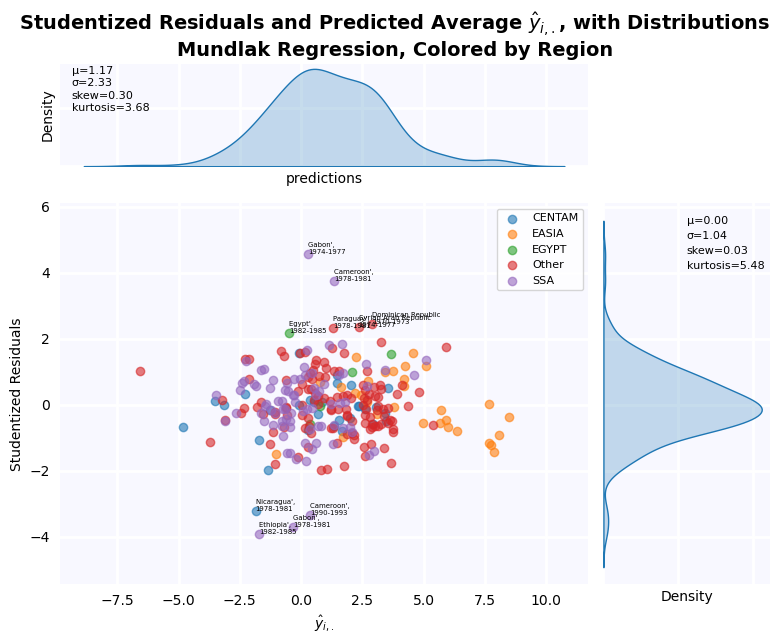

In [229]:
resid_plot(x=x, model=mundlak, title='Mundlak Regression, Colored by Region', 
           labels_y=True, transform='Random', outlier_y=(-2,2), 
           color_col=region_dummies
    )

Again, the residuals are promising with little skewness and the kurtosis is not too concerning. There is not a great deal of geographic clustering of the variables, but the SSA countries appear to be on the left hand side and have the outliers of Gabon and Cameroon.

## First-Differences

In [230]:
y = _df['GDPG']
x = _df[list(set(Exog_vars) - set(['ICRGE', 'ETHNF', 'SSA', 'EASIA']))]
diffOLS = lm.panel.FirstDifferenceOLS(y, x).fit(cov_type='clustered', clusters=_df['Clusters'])
diff_results = save_results(diffOLS, 'First Diff')
diffOLS.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                     FirstDifferenceOLS Estimation Summary                      
================================================================================
Dep. Variable:                   GDPG   R-squared:                        0.1313
Estimator:         FirstDifferenceOLS   R-squared (Between):             -424.67
No. Observations:                 217   R-squared (Within):               0.1268
Date:                Sun, Jan 07 2024   R-squared (Overall):             -205.95
Time:                        20:19:45   Log-likelihood                   -600.90
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.3156
Entities:                          56   P-value                           0.0000
Avg Obs:                       4.9107   Distribution:                   F(6,211)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             11.085
                                        P-value                           0.0000
Time periods:                       6   Distribution:                   F(6,211)
Avg Obs:                       45.833                                           
Min Obs:                       41.000                                           
Max Obs:                       49.000                                           
                                                                                
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
ETHNF*ASSAS     0.9176     0.6664     1.3770     0.1700     -0.3961      2.2313
Policy          0.8688     0.2342     3.7101     0.0003      0.4072      1.3305
ASSAS          -0.4268     0.4460    -0.9569     0.3397     -1.3060      0.4524
EDA            -0.1202     0.1756    -0.6847     0.4943     -0.4663      0.2259
lGDP           -7.0632     1.3908    -5.0787     0.0000     -9.8047     -4.3216
M2-1           -0.0201     0.0249    -0.8061     0.4211     -0.0693      0.0291
===============================================================================
"""

First differences is of course only possible with variables that vary over time so the geographic variables and ICRGE and ETHNF are excluded. The $R^2$ is one of the lowest at 0.12, and the coefficient for EDA is still statistically insignificant. Policy remains insignificant and the log of GDP is also significant as an explanatory variable for GDPG. This is consistent with the correlation matrices we saw above.

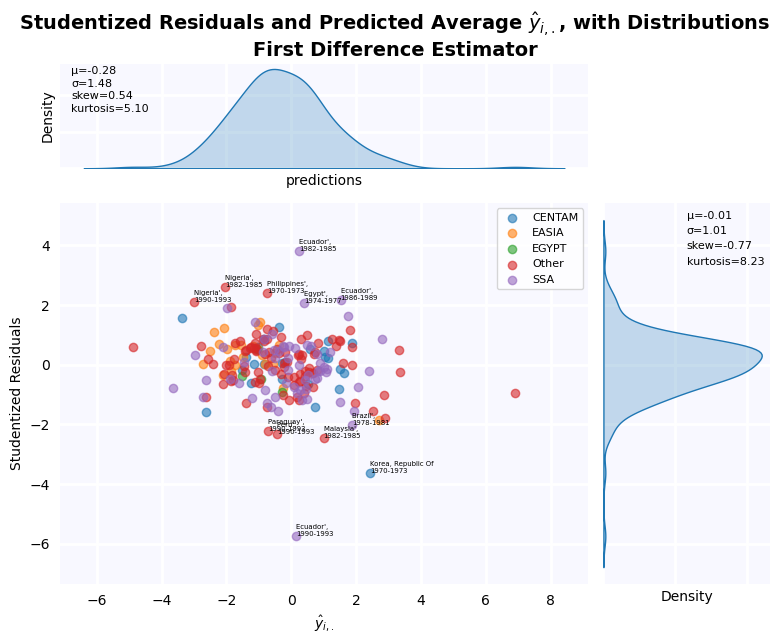

In [231]:
diff_x = x.unstack(0).diff(1).stack().dropna().swaplevel().sort_values(by='Country')
resid_plot(diff_x, 
           diffOLS, title='First Difference Estimator', transform='Diff',
          labels_y=True, outlier_y=(-2,2), 
          color_col=region_dummies[diff_x.index])

# 14. If one of your variable is time-invariant z(i) (Institutional quality ICRG for Burnside Dollar), run a baseline Hausman Taylor estimation including all X(i.) as instruments. Comment the results.

In [232]:
_df = _df.drop(columns='YEAR1')

In [234]:
between = _df.groupby('Country').transform(np.nanmean)
within = _df.groupby('Country').transform(lambda x: x - x.mean())

In [235]:
to_instrument = ['M2-1', 'Policy', 'EDA', 'ASSAS', 'ETHNF*ASSAS', 'lGDP']
instruments = ['ICRGE', 'ETHNF'] 
instruments += ['P'+str(x) for x in between[to_instrument].columns]
instruments += ['Q'+str(x) for x in within[to_instrument].columns]

Pz = pd.merge(between[to_instrument], within[to_instrument], how='outer', left_index=True, right_index=True)
Pz = pd.merge(_df[instruments[:2]], Pz, left_index=True, right_index=True)
Pz.columns = instruments
Pz.index = _df.index
Pz['const'] = 1
for i, var in enumerate(to_instrument):
    ols = sm.OLS(_df[var], Pz, has_constant=True).fit(cov_type='cluster', cov_kwds={'groups':_df['Clusters']})
    temp_frame = pd.DataFrame(ols.predict(Pz), columns=[var])
    if i == 0: hat_frame = temp_frame
    else: hat_frame = pd.merge(hat_frame, temp_frame, left_index=True, right_index=True)

The Fixed effects model controls for effects that are constant across time but vary across countries. The Random effects model allows for time invariant variables, but assumes that the variables are uncorrelated with the explanatory variables which is an assumption not always satisfied. The Hausman-Taylor uses a mixed structure to handle this and is between both fixed and random effects (Ao, 2009).

The standard panel regression model with time-invariate variables is 
$$
y_{it} = X_{it}'\beta + Z_i \gamma +\mu_i + \epsilon_{it}
$$
Where $Z_i$ are cross-sectional time-invariant variables. The Hausman-Taylor model splits the variables into two sets: $X = [X_1;X_2]$ and $Z=[Z_1;Z_2]$ where $X_1$ and $Z_1$ are exogenous and $X_2$ and $Z-2$ are endogenous, correlated with $\mu_i$ but not $\epsilon_{it}$.

Hence, we have
$$
y_{it} = X_{1it}'\beta_1 + X_{2it}'\beta_2 + Z_{1i}\gamma_1 + Z_{2i}\gamma_2 + \mu_i + \epsilon_{it}
$$

First thw within transformation is done to subtract the group mean (so Zs are removed). From this the within estimator of $\beta_1$ and $\beta_2$ is estimated and the within residual is calculated.

Now the within residual is regressed on $Z_1$ and $Z_2$ using $X_1$ and $X_2$ as instruments obtaining $\hat{\gamma_{1IV}}$ and $\hat{\gamma_{2IV}}$ which are consistent estimates of $\gamma_1$ and $\gamma_2$.

With the two IV estimates of the gammas, the variance of the residual the variance can be calculated and then $\hat{\theta_i}$ is defined as:
$$
\hat{\theta_i} = 1 - (\frac{\hat{\sigma_{\epsilon}}^2}{\sigma_{\epsilon}^2 + T_i \sigma_{\mu}^2})^{\frac{1}{2}}
$$

A random effect transformation can be done on each of the variables: $w_{it*} = w_{it} - \hat{\theta_i}\bar{w_i}$ where $\bar{w_i}$ is the within-panel mean. Now we have
$$
y_{it*} = X_{it*}\beta+Z_{it*}\gamma + \epsilon_{it*}
$$
(Ao, 2009)

Hence, the internal instruments are used to deal with the endogeneity problem, treating time-varying variables uncorrelated with the entity effects as exogenous and using them as instruments for the endogenous time-varying variables. The model has the advantage of being more efficient than the standard fixed effects model because the assumption of no correlation between the entity effects and the explanatory variables is not violated.

## Stage 1 IV

Given that there is no dedicated package for HT regression like in Stata (xthtaylor), Grabowski's (2019) 'open source' code is employed.

In [236]:
# Stage 1 IV Results
hat_frame['const'] = 1
iv = sm.OLS(_df['GDPG'], hat_frame, has_const=True).fit(cov_type='cluster', cov_kwds={'groups':_df['Clusters']})
iv_results = save_results(iv, 'IV')
iv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GDPG   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     13.76
Date:                Sun, 07 Jan 2024   Prob (F-statistic):           4.33e-09
Time:                        20:19:50   Log-Likelihood:                -706.13
No. Observations:                 275   AIC:                             1426.
Df Residuals:                     268   BIC:                             1452.
Df Model:                           6                                         
Covariance Type:              cluster                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
M2-1            0.0090      0.013      0.696      0.486      -0.016       0.034
Policy          1.2543      0.171      7.334      0.000       0.919       1.589
EDA            -0.2361      0.117     -2.017      0.044      -0.465      -0.007
ASSAS          -0.4955      0.296     -1.673      0.094      -1.076       0.085
ETHNF*ASSAS     0.6430      0.446      1.441      0.149      -0.231       1.517
lGDP          -1.9e-05      0.419  -4.54e-05      1.000      -0.820       0.820
const          -0.0673      3.199     -0.021      0.983      -6.337       6.203
==============================================================================
Omnibus:                       18.754   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.727
Skew:                          -0.102   Prob(JB):                     2.92e-13
Kurtosis:                       5.235   Cond. No.                         453.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [237]:
r = iv.resid
iT = 1 / r.groupby('Country').size()
r_b = r.groupby('Country').agg('mean')
r_b2 = r_b.pow(2)
iT = sm.add_constant(iT)
iT.columns = ['σ2_α', 'σ2_u']
var_est = sm.OLS(r_b2, iT, has_constant=True).fit(cov_type='HC0')
var_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     7.636
Date:                Sun, 07 Jan 2024   Prob (F-statistic):            0.00781
Time:                        20:19:50   Log-Likelihood:                -160.18
No. Observations:                  56   AIC:                             324.4
Df Residuals:                      54   BIC:                             328.4
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
σ2_α           0.2271      0.792      0.287      0.774      -1.326       1.780
σ2_u          10.2887      3.723      2.763      0.006       2.991      17.586
==============================================================================
Omnibus:                       48.070   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              196.684
Skew:                           2.391   Prob(JB):                     1.95e-43
Kurtosis:                      10.837   Cond. No.                         5.32
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [238]:
σ2_α, σ2_u = var_est.params
λ = 1 - np.sqrt(σ2_u / (σ2_u + iT.iloc[:,1] * σ2_α))
λ.name = 'lambda'

In [239]:
test = _df.groupby('Country').agg(np.mean)[to_instrument + instruments[:2]]
results = None
for col in test.columns:
    if results is None:
        results = test[col] * λ
    else:
        results = pd.concat([results, test[col] * λ], axis=1)
        
results.columns = test.columns
results = results.reindex(between.index, level=0)

lambda_weighted_y = _df['GDPG'].subtract(between['GDPG'] * λ, axis=0 )
lambda_weighted_demeaned = _df[to_instrument + instruments[:2]].subtract(results, axis=0)

for i, var in enumerate(to_instrument + instruments[:2]):
    ols = sm.OLS(lambda_weighted_demeaned[var], Pz, 
                 has_constant=True).fit(cov_type='cluster', cov_kwds={'groups':_df['Clusters']})
    temp_frame = pd.DataFrame(ols.predict(Pz), columns=[var])
    if i == 0: hat_frame = temp_frame
    else: hat_frame = pd.merge(hat_frame, temp_frame, left_index=True, right_index=True)

In [240]:
lambda_iv = sm.OLS(lambda_weighted_y, hat_frame, has_const=False).fit(cov_type='cluster', cov_kwds={'groups':_df['Clusters']}) 

ht_results = save_results(lambda_iv, 'HT')
lambda_iv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.328
Model:                            OLS   Adj. R-squared (uncentered):              0.308
Method:                 Least Squares   F-statistic:                              21.10
Date:                Sun, 07 Jan 2024   Prob (F-statistic):                    2.00e-13
Time:                        20:19:51   Log-Likelihood:                         -700.82
No. Observations:                 275   AIC:                                      1418.
Df Residuals:                     267   BIC:                                      1447.
Df Model:                           8                                                  
Covariance Type:              cluster                                                  
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
M2-1            0.0076      0.011      0.686      0.493      -0.014       0.029
Policy          1.1677      0.153      7.632      0.000       0.868       1.468
EDA            -0.1930      0.098     -1.964      0.050      -0.386      -0.000
ASSAS          -0.5907      0.293     -2.013      0.044      -1.166      -0.016
ETHNF*ASSAS     1.0955      0.458      2.390      0.017       0.197       1.994
lGDP           -0.2279      0.095     -2.401      0.016      -0.414      -0.042
ICRGE           0.4849      0.149      3.257      0.001       0.193       0.777
ETHNF          -1.1752      0.776     -1.515      0.130      -2.695       0.345
==============================================================================
Omnibus:                       20.171   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.798
Skew:                          -0.131   Prob(JB):                     8.50e-15
Kurtosis:                       5.364   Cond. No.                         141.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are robust to cluster correlation (cluster)
"""

The $R^2$ is 0.328 which is high comparing to the standard models estimated above. Policy remains statistically significant, and EDA is now significant at the 95% confidence level with a negative coefficient. This suggests that effective aid exerts downward pressure on GDP growth which would be surprising. Many of the other variables are statistically significant now. Country institutional quality has a positive, statistically significant coefficient, but ethnic fractionalisation remains insignificant.

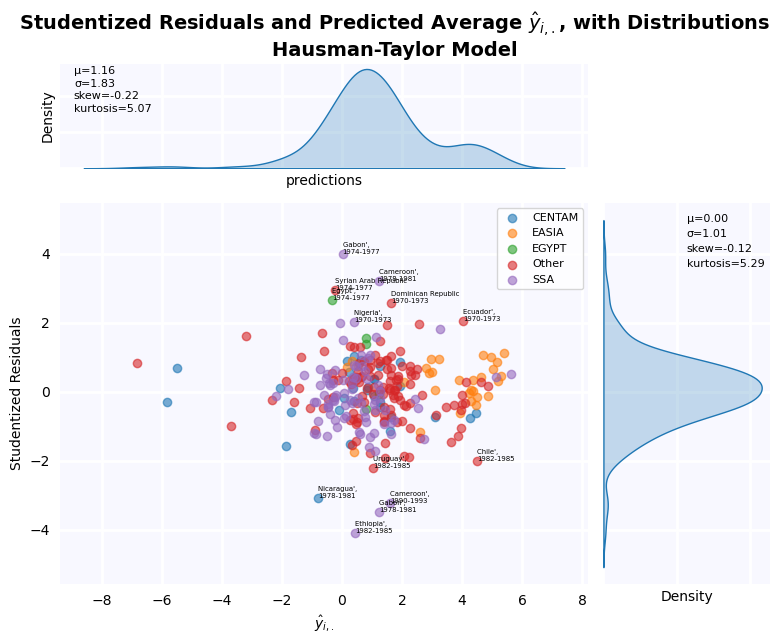

In [241]:
resid_plot(x=lambda_weighted_demeaned, model=lambda_iv, title='Hausman-Taylor Model', transform='HT',
           color_col=region_dummies, labels_y=True, outlier_y=(-2,2))


There positive skew in the residuals, fuelled by east asian countries. SSA countries remain concentrated in the centre but are responsible for the tails of the studentised residuals.

## Overall Model Comparison

In [242]:
from functools import reduce
mundlak_results = mundlak_results[[x.find('mean') == -1 for x in mundlak_results.index]]
to_merge = [between_results, fe_results, fete_results, re_results, mundlak_results, diff_results, iv_results, ht_results]
results = reduce(lambda left, right: pd.merge(left, right, how='outer', left_index=True, right_index=True), to_merge)
results.iloc[:12, :]

Between Fixed Effects Fixed/Time Effects Random Effects  \
ASSAS          -0.208        -0.537           -0.654**       -0.490**   
EASIA           0.241           NaN                NaN          0.942   
EDA             0.183        -0.123              0.142          0.090   
ETHNF          -0.155           NaN                NaN         -0.501   
ETHNF*ASSAS     0.379       1.052**            1.262**        0.916**   
ICRGE           0.294           NaN                NaN       0.663***   
M2-1            0.024       -0.042*              0.001          0.010   
Policy       1.630***      0.929***           0.840***       0.983***   
SSA            -1.292           NaN                NaN       -1.779**   
const          -3.323           NaN                NaN          3.383   
lGDP            0.095     -4.069***             -2.173         -0.603   
r2           0.600344      0.160235           0.101701       0.359807   

               Mundlak First Diff        IV        HT  
ASSAS        -0.659***     -0.427   -0.495*  -0.591**  
EASIA            0.339        NaN       NaN       NaN  
EDA              0.113     -0.120  -0.236**  -0.193**  
ETHNF              NaN        NaN       NaN    -1.175  
ETHNF*ASSAS   1.271***      0.918     0.643   1.096**  
ICRGE              NaN        NaN       NaN  0.485***  
M2-1            -0.004     -0.020     0.009     0.008  
Policy        0.818***   0.869***  1.254***  1.168***  
SSA             -0.964        NaN       NaN       NaN  
const            0.766        NaN    -0.067       NaN  
lGDP           -2.325*  -7.063***    -0.000  -0.228**  
r2            0.376696   0.131306  0.228953  0.328227

The variable of most interest is of course EDA. EDA was only statistically significant in the HT regression but estimated a negative coefficient. Assassinations also had its fair share of statistically significant coefficients, again all negative. It's highest coefficient was recorded when controlling for both entity and time fixed effects. Country institutional quality, ICRGE, has a positive coefficient and was statistically significant for the random effects and HT models. This is unsurprising and suggests that higher ICRGE (higher institutional quality) is associated with higher growth rates. Policy has been statistically significant throughout and has positive coefficients, indicating positive covariance with GDPG. The coefficient for policy doubles for between compared to the within and time+entity fixed effects model. The $R^2$ is highest for the between model but the Mundlak random effects performs well also. It is only in the random effects model where the coefficient for SSA is statistically significant, but for all other models for which SSA is included the coefficient is negative and indicates SSA is associated with lower GDP growth rates.

# 15. If one of your variable is time-invariant z(i) (Institutional quality ICRG for Burnside Dollar), run a between regression on z(i) explained by X(i.) and other time invariant variable (only with N observations). If the R2 is low, this may signal X(i.) are weak instruments poorly correlated with the variable z(i) to be instrumented. Comment.

In [243]:
ols = sm.OLS(_df['ICRGE'].groupby('Country').transform('mean'), 
             sm.add_constant(between[to_instrument]), hasconst=True)
results = ols.fit(cov_type='HC0')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ICRGE   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     32.63
Date:                Sun, 07 Jan 2024   Prob (F-statistic):           2.02e-29
Time:                        20:19:55   Log-Likelihood:                -392.69
No. Observations:                 275   AIC:                             799.4
Df Residuals:                     268   BIC:                             824.7
Df Model:                           6                                         
Covariance Type:                  HC0                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.3437      0.962     -1.396      0.163      -3.230       0.542
M2-1           -0.0024      0.006     -0.386      0.699      -0.015       0.010
Policy          0.4095      0.070      5.818      0.000       0.272       0.547
EDA             0.0642      0.049      1.307      0.191      -0.032       0.160
ASSAS          -0.4614      0.147     -3.143      0.002      -0.749      -0.174
ETHNF*ASSAS    -0.1503      0.287     -0.524      0.600      -0.712       0.412
lGDP            0.7475      0.117      6.394      0.000       0.518       0.977
==============================================================================
Omnibus:                        0.226   Durbin-Watson:                   0.454
Prob(Omnibus):                  0.893   Jarque-Bera (JB):                0.273
Skew:                          -0.068   Prob(JB):                        0.872
Kurtosis:                       2.927   Cond. No.                         500.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

For an instrumental variable, the general rule of thumb is that the F-statistic for the first stage regression should exceed 10. We are not regressing instruments on an explanatory variable but the other way around. However, the large F-statistic is a good sign of instrument strength. The $R^2$ is reasonable at 0.332, meaning 33.2% of the variation in institutional quality is explained by the explanatory variables. Policy, ASSAS and the log of GDP are all statistically significant. Overall, given the $R^2$, the F-test statistic of 32.6 and the incidence of statistically significant variables in the regression on the instrument, ICRGE appears to be an relevant instrument.

# 16. Time invariant variable used in interaction with a time varying variable. Generate a variable which is the product of ICRG (a governance-corruption indicator which is time-invariant) and foreign aid EDA/GDP. Include this product AND foreign aid into a one way fixed effects regression. Plot the estimated marginal effect (derivative) with respect to ICRG as a function of EDA/GDP (which is positive and goes as far as 20%).

In [244]:
df['ICRGE*EDA'] = df['ICRGE'] * df['EDA']

The interaction variable 'ICRGE*EDA' is composed as the product of ICRGE and EDA. This will allow us to understand how the effect of ICRGE on GDPG varies with effective aid.

The one way fixed effcts regression will be:
$$
GDPG_{it} = \beta_0 + \beta_1(ICRGE_i * EDA_{it}) + \beta_2EDA_{it} + \alpha_{i} + \epsilon_{it}
$$
$\beta_1$ captures the interaction effect, $\beta_2$ captures the direct effect of EDA on GDPG and $\alpha_i$ is the entity fixed effects.

In [245]:
_df = df.reset_index().set_index(['Country', 'Year']) 
new_exog = ['ICRGE*EDA', 'EDA']

#using the same technique as Jesse's exemplar code (Grabowski, 2019) by employing the ASCII values.
_df['Clusters'] = list(map(lambda x: np.sum([ord(xx) for xx in x]), _df.index.get_level_values(0)))

## Within

In [246]:
x = _df[new_exog]
y = _df['GDPG']
within_fe_product = lm.PanelOLS(y, x, entity_effects=True, time_effects=False, drop_absorbed=True).fit(cov_type='clustered', clusters=_df['Clusters'])
fe_product_results = save_results(within_fe, 'Fixed Effects Product')
within_fe_product.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                   GDPG   R-squared:                        0.0022
Estimator:                   PanelOLS   R-squared (Between):             -0.0736
No. Observations:                 275   R-squared (Within):               0.0022
Date:                Sun, Jan 07 2024   R-squared (Overall):             -0.0311
Time:                        20:19:58   Log-likelihood                   -677.58
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.2443
Entities:                          56   P-value                           0.7835
Avg Obs:                       4.9107   Distribution:                   F(2,217)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             0.6725
                                        P-value                           0.5115
Time periods:                       6   Distribution:                   F(2,217)
Avg Obs:                       45.833                                           
Min Obs:                       41.000                                           
Max Obs:                       49.000                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
ICRGE*EDA     -0.1011     0.0980    -1.0321     0.3032     -0.2942      0.0920
EDA            0.4185     0.4779     0.8756     0.3822     -0.5235      1.3604
==============================================================================

F-test for Poolability: 2.0096
P-value: 0.0002
Distribution: F(55,217)

Included effects: Entity
"""

Hence, the model is:
$$
GDPG_{it} = 1.2101^{***} + -0.1011(ICRGE_i * EDA_{it}) + 0.4185EDA_{it} + \alpha_{i} + \epsilon_{it}
$$

In [247]:
x = _df[new_exog]

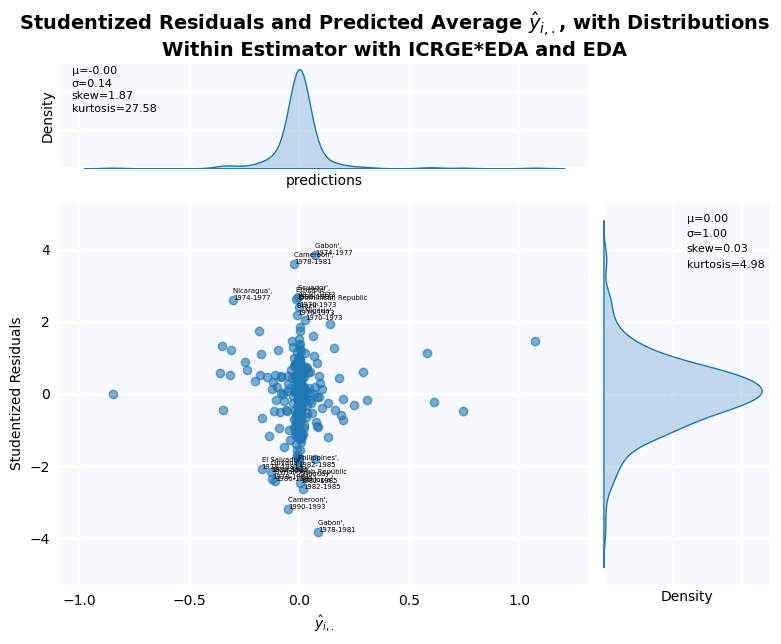

In [248]:
within_x = x.groupby('Country').transform(lambda x: x - x.mean())
resid_plot(within_x, 
           model=within_fe_product, title='Within Estimator with ICRGE*EDA and EDA',
           transform='within', labels_y=True, outlier_y=(-2,2),
          labels_x=True, outlier_x=(-5,5))

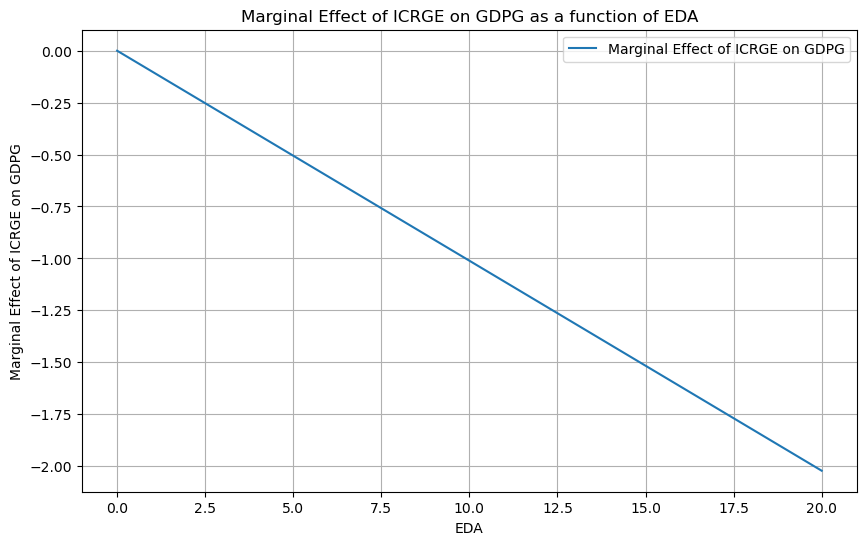

In [249]:
beta_1 = within_fe_product.params['ICRGE*EDA']  # Replace 'ICRGE*EDA' with the actual name of your interaction term in the results.
eda_values = np.linspace(0, 20, 200)  # 200 points for a smooth curve
marginal_effects_icrge = beta_1 * eda_values

plt.figure(figsize=(10, 6))
plt.plot(eda_values, marginal_effects_icrge, label='Marginal Effect of ICRGE on GDPG')
plt.xlabel('EDA')
plt.ylabel('Marginal Effect of ICRGE on GDPG')
plt.title('Marginal Effect of ICRGE on GDPG as a function of EDA')
plt.legend()
plt.grid(True)
plt.show()

With the model: $ GDPG_{it} = 1.2101^{***} + -0.1011(ICRGE_i * EDA_{it}) + 0.4185EDA_{it} + \alpha_{i} + \epsilon_{it} $ estimated, the marginal effect is the derivative of GDPG with respect to ICRG which is
$$
\frac{∂GDPG_{it}}{∂ICRGE_i} = -0.1011EDA_{it} + 0.4185
$$
which gives us the linear plot shown above. The downward slope suggests that as effective aid, the effect of institutional quality declines. When we reach 20% effective aid, the marginal effect of ICRGE on GDPG is negative suggesting that an increase in institutional quality has negative growth results.

### With more variables...

In [250]:
Exog = ['lGDP', 'ASSAS', 'ETHNF*ASSAS', 'ICRGE*EDA',
             'M2-1', 'Policy', 'EDA',]

In [251]:
x = _df[Exog]
y = _df['GDPG']
within_fe_morevar = lm.PanelOLS(y, x, entity_effects=True, time_effects=False, drop_absorbed=True).fit(cov_type='clustered', clusters=_df['Clusters'])
fe_morevar_results = save_results(within_fe_morevar, 'Fixed Effects Product with more variables')
within_fe_morevar.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                   GDPG   R-squared:                        0.1666
Estimator:                   PanelOLS   R-squared (Between):             -137.41
No. Observations:                 275   R-squared (Within):               0.1666
Date:                Sun, Jan 07 2024   R-squared (Overall):             -66.359
Time:                        20:20:01   Log-likelihood                   -652.83
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.0548
Entities:                          56   P-value                           0.0000
Avg Obs:                       4.9107   Distribution:                   F(7,212)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             7.7213
                                        P-value                           0.0000
Time periods:                       6   Distribution:                   F(7,212)
Avg Obs:                       45.833                                           
Min Obs:                       41.000                                           
Max Obs:                       49.000                                           
                                                                                
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
lGDP           -3.8363     1.4319    -2.6791     0.0080     -6.6589     -1.0136
ASSAS          -0.5691     0.3447    -1.6508     0.1003     -1.2487      0.1105
ETHNF*ASSAS     1.1068     0.4917     2.2510     0.0254      0.1376      2.0759
ICRGE*EDA      -0.1813     0.0902    -2.0102     0.0457     -0.3591     -0.0035
M2-1           -0.0513     0.0265    -1.9357     0.0542     -0.1035      0.0009
Policy          0.9377     0.1624     5.7755     0.0000      0.6176      1.2577
EDA             0.6235     0.4658     1.3387     0.1821     -0.2946      1.5417
===============================================================================

F-test for Poolability: 1.7985
P-value: 0.0017
Distribution: F(55,212)

Included effects: Entity
"""

In [252]:
within_x = x.groupby('Country').transform(lambda x: x - x.mean())
within_x.head()

lGDP     ASSAS  ETHNF*ASSAS  ICRGE*EDA      M2-1  \
Country   Year                                                         
Algeria   1    -0.105733  0.000000     0.000000   1.159668 -6.179900   
          2     0.105733  0.000000     0.000000  -1.159668  6.179900   
Argentina 1     0.013809  0.458333     0.142083   0.002568 -1.116079   
          2     0.103831  7.458333     2.312083  -0.002071  2.852200   
          3     0.050727 -1.291667    -0.400417   0.027207  4.293677   

                  Policy       EDA  
Country   Year                      
Algeria   1    -0.334220  0.265700  
          2     0.334220 -0.265700  
Argentina 1     0.856984  0.000600  
          2    -0.378837 -0.000484  
          3     0.064782  0.006355

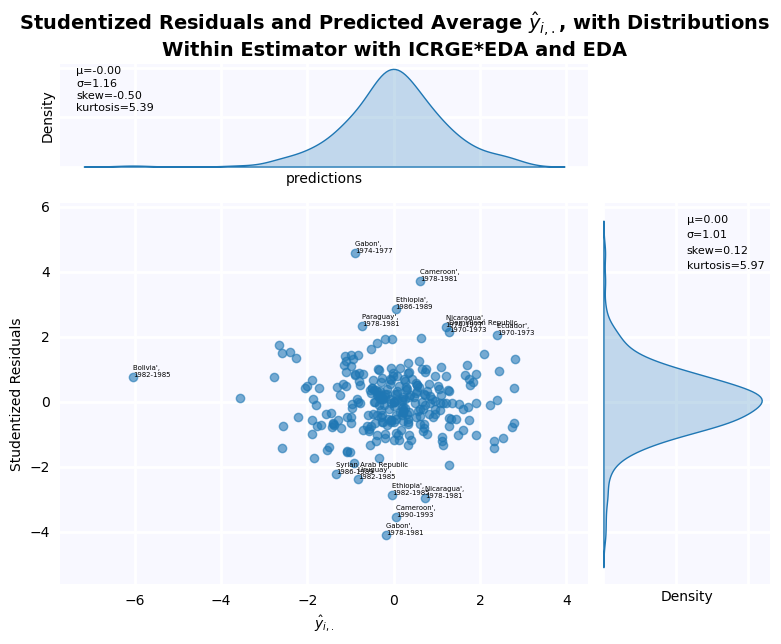

In [253]:
resid_plot(within_x, 
           model=within_fe_morevar, title='Within Estimator with ICRGE*EDA and EDA',
           transform='within', labels_y=True, outlier_y=(-2,2),
          labels_x=True, outlier_x=(-5,5))

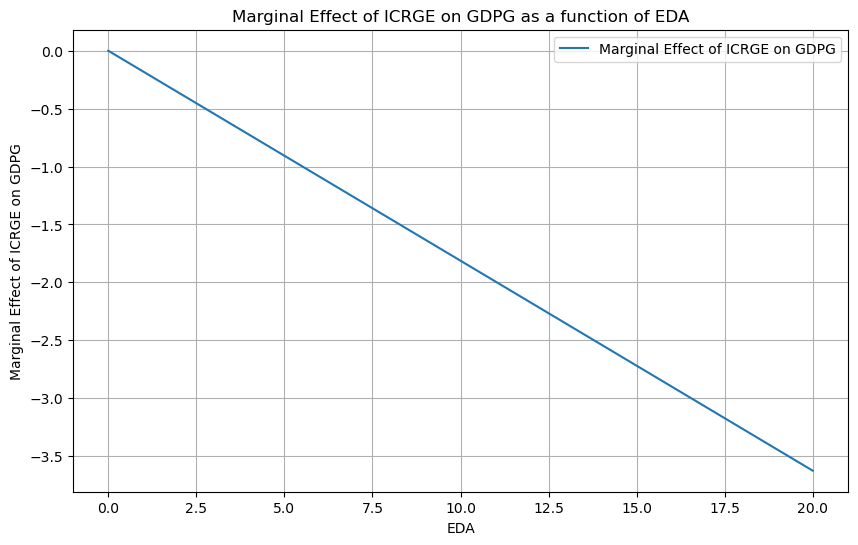

In [254]:
beta_1 = within_fe_morevar.params['ICRGE*EDA']  # Replace 'ICRGE*EDA' with the actual name of your interaction term in the results.
eda_values = np.linspace(0, 20, 200)
marginal_effects_icrge = beta_1 * eda_values

plt.figure(figsize=(10, 6))
plt.plot(eda_values, marginal_effects_icrge, label='Marginal Effect of ICRGE on GDPG')
plt.xlabel('EDA')
plt.ylabel('Marginal Effect of ICRGE on GDPG')
plt.title('Marginal Effect of ICRGE on GDPG as a function of EDA')
plt.legend()
plt.grid(True)
plt.show()

Including a few more variables in the regression gives the same result when taking the derivative with respect to ICRGE.

# 17. Anderson-Hsiao (1981) estimator for dynamic panel data adding a lag of the foreign aid/GDP (adding lags of other control variables is optional): 
# Δ GDPGi,t = βy Δ GDPGi,t-1 + β1 Δ (aid/GDP)i,t + β2 Δ (aid/GDP)i,t-1 + Δ Controlsi,t + Δ αi + Δ αt + Δ εi

In [255]:
first_diff.to_csv('/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Panel Data/Homework/first_diff.csv', index=False)

The Anderson-Hsaio estimator addresses the issue of endogeneity where the dependent variable in one period is explained by its own past values. In this case it is a concern that the lagged GDPG and EDA is correlated with the error term: endogeneity. The Anderson-Hsiao model instruments the first lag of the first-differenced GDPG and EDA and instruments them by the second lag of the GDPG and EDA. The first regressions estimate the first lags of the differenced GDPG and EDA by regressing them on the second lags of the variables in levels and the control variables.

## 17.1. For all these variables: ΔGDPGi,t Δ GDPGi,t-1 Δ (aid/GDP)i,t Δ(aid/GDP)i,t-1 GDPGi,t-2 (aid/GDP)i,t-2 report univariate statistics (mean median standard error, skewness, kurtosis, min max) and comment.

In [256]:
df['GDPG_diff'] = df['GDPG'].diff()
df['EDA_diff'] = df['EDA'].diff()
df['GDPG_diff_lag1'] = df['GDPG_diff'].shift()
df['EDA_diff_lag1'] = df['EDA_diff'].shift()

for control in ['lGDP', 'Policy', 'ETHNF*ASSAS', 'ASSAS', 'M2-1']:
    df[f'{control}_diff'] = df[control].diff()

df['GDPG_lag2'] = df['GDPG'].shift(2)
df['EDA_lag2'] = df['EDA'].shift(2)

df.head()

GDPG     GDP        BB      INFL  SACW       GOVC  \
Country   YEAR1                                                              
Algeria   1970-1973  2.386265  1826.0 -0.068337  0.046413   0.0  15.471668   
          1974-1977  3.236684  2256.0  0.036605  0.082093   0.0  12.345353   
Argentina 1970-1973  1.700300  5637.0 -0.021146  0.340886   0.0  10.194982   
          1974-1977  1.077615  6168.0 -0.069117  0.989960   0.0  11.044480   
          1978-1981 -1.115285  5849.0 -0.033950  0.844831   0.0  11.086979   

                     ETHNF  ASSAS     ICRGE       M2-1  SSA  EASIA       LPOP  \
Country   YEAR1                                                                 
Algeria   1970-1973   0.43   0.00  4.364583  49.102671    0      0  16.482732   
          1974-1977   0.43   0.00  4.364583  61.462472    0      0  16.605724   
Argentina 1970-1973   0.31   2.75  4.281250  24.824762    0      0  17.017208   
          1974-1977   0.31   9.75  4.281250  28.793040    0      0  17.082911   
          1978-1981   0.31   1.00  4.281250  30.234517    0      0  17.144003   

                     EGYPT  CENTAM  FRZ  ARMS-1  DN1900       EDA      BEDA  \
Country   YEAR1                                                               
Algeria   1970-1973    0.0     0.0  0.0   2.967       0  1.032286  0.842784   
          1974-1977    0.0     0.0  0.0   1.950       0  0.500887  0.433937   
Argentina 1970-1973    0.0     0.0  0.0   2.033       1  0.018239  0.016755   
          1974-1977    0.0     0.0  0.0   1.725       1  0.017155  0.016532   
          1978-1981    0.0     0.0  0.0   1.075       1  0.023994  0.019493   

                         MEDA     WBEDA      POPDEP  year_3  year_4  year_5  \
Country   YEAR1                                                               
Algeria   1970-1973  0.189503  0.000000  110.482000       0       0       0   
          1974-1977  0.066950  0.001251  107.439000       1       0       0   
Argentina 1970-1973  0.001484 -0.000961   57.374800       0       0       0   
          1974-1977  0.000623 -0.002459   58.844350       1       0       0   
          1978-1981  0.004501 -0.002057   61.571267       0       1       0   

                     year_6  year_7  ETHNF*ASSAS      lGDP  Constant  \
Country   YEAR1                                                        
Algeria   1970-1973       0       0       0.0000  7.509883         1   
          1974-1977       0       0       0.0000  7.721349         1   
Argentina 1970-1973       0       0       0.8525  8.637107         1   
          1974-1977       0       0       3.0225  8.727130         1   
          1978-1981       0       0       0.3100  8.674026         1   

                       Policy  Year  ICRGE*EDA  GDPG_diff  EDA_diff  \
Country   YEAR1                                                       
Algeria   1970-1973  0.745237     1   4.505499        NaN       NaN   
          1974-1977  1.413676     2   2.186163   0.850419 -0.531399   
Argentina 1970-1973  0.656556     1   0.078085  -1.536384 -0.482648   
          1974-1977 -0.579265     2   0.073447  -0.622685 -0.001083   
          1978-1981 -0.135645     3   0.102725  -2.192900  0.006839   

                     GDPG_diff_lag1  EDA_diff_lag1  lGDP_diff  Policy_diff  \
Country   YEAR1                                                              
Algeria   1970-1973             NaN            NaN        NaN          NaN   
          1974-1977             NaN            NaN   0.211466     0.668440   
Argentina 1970-1973        0.850419      -0.531399   0.915759    -0.757120   
          1974-1977       -1.536384      -0.482648   0.090023    -1.235821   
          1978-1981       -0.622685      -0.001083  -0.053104     0.443619   

                     ETHNF*ASSAS_diff  ASSAS_diff  M2-1_diff  GDPG_lag2  \
Country   YEAR1                                                           
Algeria   1970-1973               NaN         NaN        NaN        NaN   
          1974-1977        

In [257]:
vars = ['GDPG_diff', 'GDPG_diff_lag1', 'EDA_diff', 'EDA_diff_lag1', 'GDPG_lag2', 'EDA_lag2']

def descriptive_statistics(df, variables):
    descriptives = df[variables].describe()
    descriptives = descriptives.T

    descriptives['SE'] = descriptives['std'] / np.sqrt(descriptives['count'])

    descriptives['Skew'] = df[variables].skew()
    descriptives['Kurtosis'] = df[variables].kurt()

    descriptives['(MAX-Mean)/SE'] = (descriptives['max'] - descriptives['mean']) / descriptives['SE']
    descriptives['(MIN-Mean)/SE'] = (descriptives['mean'] - descriptives['min']) / descriptives['SE']

    descriptives['median = mean?'] = np.where(descriptives['50%'].eq(descriptives['mean']), 'Yes', 'No')

    columns_order = ['min', '25%', '50%', '75%', 'max', 'mean', 'median = mean?', 'SE', '(MAX-Mean)/SE', '(MIN-Mean)/SE', 'Skew', 'Kurtosis']
    return descriptives[columns_order]

descriptives = descriptive_statistics(df, vars)
descriptives.transpose()

GDPG_diff GDPG_diff_lag1    EDA_diff EDA_diff_lag1  GDPG_lag2  \
min            -21.805923     -21.805923  -11.429923    -11.429923 -12.203861   
25%              -2.55365      -2.552181   -0.131236     -0.134258  -1.037119   
50%              0.392163       0.436271     0.00527      0.004669    1.29729   
75%              2.423592       2.427118    0.334969      0.332171   3.491029   
max             14.935178      14.935178    9.465112      9.465112  12.270041   
mean            -0.016064      -0.006767    0.007031      0.003853   1.187377   
median = mean?         No             No          No            No         No   
SE               0.263917       0.264721    0.114321      0.114697   0.218287   
(MAX-Mean)/SE   56.651311       56.44411    82.73237     82.489451  50.771037   
(MIN-Mean)/SE   82.563321      82.347651  100.042097      99.68714  61.346901   
Skew            -0.567063      -0.572794   -1.267227     -1.261693  -0.158182   
Kurtosis          2.95956       2.957303   11.758613     11.719534   0.941215   

                 EDA_lag2  
min             -0.007973  
25%              0.253695  
50%              0.794389  
75%              2.266982  
max             12.723949  
mean             1.618671  
median = mean?         No  
SE               0.125583  
(MAX-Mean)/SE   88.430026  
(MIN-Mean)/SE   12.952774  
Skew              2.26837  
Kurtosis         6.440365

The second lag of EDA has a skew that is slightly concerning. The value is 6.44 and indicates it is highly positively skewed. For the first differenced variables, the means are close to 0 and the medians are equally small. There are some outliers however, with the maximum deviation from the mean being 82.7 standard errors for EDA (max) and 100 standard errors from the mean for the EDA (minimum). Differenced EDA clearly has some wide variation and outliers but also has a concentration towards the centre because the kurtosis is 11.8 which is fairly high. 

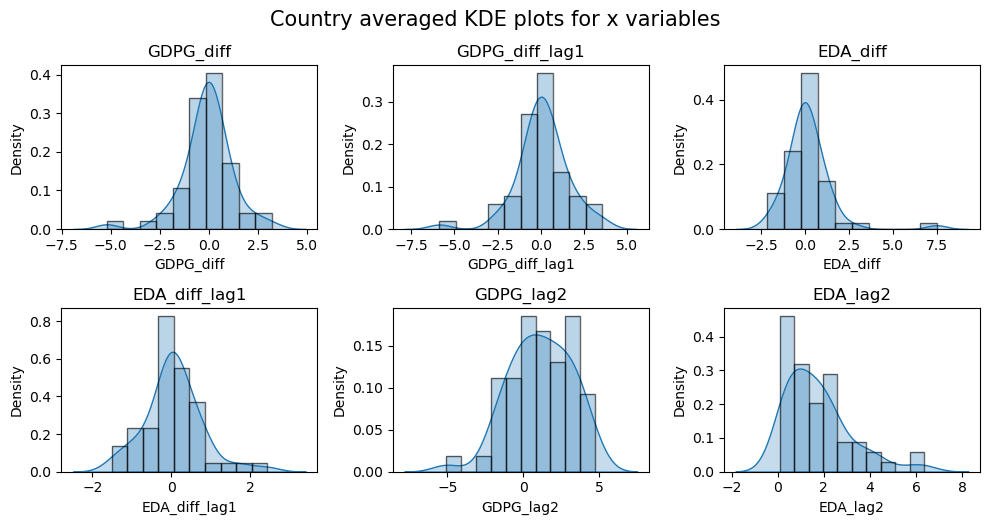

In [258]:
fig, ax = plt.subplots(2,3, figsize=(10,5), dpi=100)
for var, axis in zip(vars, fig.axes):
    g = sns.kdeplot(df[var].groupby('Country').agg(np.nanmean), ax=axis, legend=False, shade=True)
    axis.hist(df[var].groupby('Country').agg(np.nanmean), density=True, facecolor='Tab:Blue', edgecolor=None, 
             alpha=0.3)
    axis.hist(df[var].groupby('Country').agg(np.nanmean), density=True, facecolor='None', edgecolor='black',
             alpha=0.6)
    axis.set_title(var)
fig.tight_layout()
fig.suptitle('Country averaged KDE plots for x variables', size=15, y=1.04)
plt.show()

This plot allows us to visualise the distribution of the variables. As mentioned above, the differenced EDA has some observations more than 80 standard errors from the mean and it is visible in this diagram. The second lag of EDA also has some positive skewness with some positive outliers to the right of the mean. First-differenced GDPG has some negative skew (-0.567) but it is not large enough to be concerning.

## 17.2. Report the bivariate simple correlation coefficients matrix. The correlation between Δ GDPGi,t-1 Δ (aid/GDP)i,t Δ (aid/GDP)i,t-1 and the instruments in levels: GDPGi,t-2 (aid/GDP)i,t-2 is a preliminary check for the strength of these instruments.

In [259]:
from scipy.stats import pearsonr
vars = ['GDPG_diff', 'GDPG_diff_lag1', 'EDA_diff', 'EDA_diff_lag1', 'GDPG_lag2', 'EDA_lag2']
clean_df = df.dropna(subset=vars)

n = len(vars)
p_values = np.zeros((n, n))
output = np.zeros((n, n))

for i, var1 in enumerate(vars):
    for j, var2 in enumerate(vars):
        output[i, j], p_values[i, j] = pearsonr(clean_df[var1], clean_df[var2])

output = pd.DataFrame(output, columns=vars, index=vars)
p_values = pd.DataFrame(p_values, columns=vars, index=vars)
new_out = pd.DataFrame()

for col in output.columns:
    temp = add_stars(output[col], p_values[col])
    temp.name = col
    new_out = pd.concat([new_out, temp], axis=1)

new_out.index = [x.replace(' ', '')[:6] for x in output.index]
new_out.columns = [x.replace(' ', '')[:6] for x in new_out.columns]

print('Simple Correlation Matrix for Anderson-Hsiao variables')
print('=' * 110)
print(new_out)
print('\n')
print('*** - p < 0.01, ** - p < 0.05, * - p < 0.1')
print("Note: Pearson's correlation coefficient assumes normally distributed variables")


Simple Correlation Matrix for Anderson-Hsiao variables
           GDPG_d     GDPG_d     EDA_di     EDA_di     GDPG_l     EDA_la
GDPG_d   1.000***  -0.401***     -0.049      0.054   -0.119**      0.051
GDPG_d  -0.401***   1.000***     -0.052     -0.048  -0.606***     0.101*
EDA_di     -0.049     -0.052   1.000***  -0.199***     -0.012  -0.275***
EDA_di      0.054     -0.048  -0.199***   1.000***     -0.075  -0.457***
GDPG_l   -0.119**  -0.606***     -0.012     -0.075   1.000***  -0.172***
EDA_la      0.051     0.101*  -0.275***  -0.457***  -0.172***   1.000***


*** - p < 0.01, ** - p < 0.05, * - p < 0.1
Note: Pearson's correlation coefficient assumes normally distributed variables


The rows/columns are in this order: 'GDPG_diff', 'GDPG_diff_lag1', 'EDA_diff', 'EDA_diff_lag1', 'GDPG_lag2', 'EDA_lag2'

What we are looking for is relevance and exogeneity for an instrument. Hence, we want the second lag of GDPG and EDA to be weakly correlated with GDPG, but strongly correlated with the first lag of the first differenced GDPG and EDA respectively. The second lag of GDPG is significantly correlated with the second lag of the first differenced GDPG with a large coefficient of -0.606 (relevant). The correlation with the differenced GDPG is statistically significant but is low at -0.119 (exogenous). For EDA, the second lag of EDA is not statistically significantly correlated with differenced GDPG, our dependent variable, suggesting exogeneity, but it is statistically significantly correlated with the first lag of the differenced EDA with a coefficient of -0.457 (relevant). Both instruments appear relevant and exogenous.

## 17.3. Do a panel data unit root test of your choice on the variables ΔGDPGi,t and Δ(aid/GDP)i,t and comment.

### Phillips-Perron (PP) test

In [260]:
from arch.unitroot import PhillipsPerron

def run_pp_test(series, variable_name):
    print(f"Phillips-Perron test for {variable_name}:")
    
    pp_test = PhillipsPerron(series)
    print(pp_test.summary())
run_pp_test(df['GDPG_diff'].dropna(), 'GDPG_diff')
print('=' * 75)
run_pp_test(df['EDA_diff'].dropna(), 'EDA_diff')

Phillips-Perron test for GDPG_diff:
     Phillips-Perron Test (Z-tau)    
Test Statistic                -53.104
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
Phillips-Perron test for EDA_diff:
     Phillips-Perron Test (Z-tau)    
Test Statistic                -30.846
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


The PP test tests against the null hypothesis that the panel data contains a unit root. For both GDPG (first-differenced) and EDA (first-differenced). In both cases, the null hypothesis can be rejected with >99% confidence suggesting stationarity of the first differenced variables.

### ADF test

statsmodels does not have a dedicated package for ADF tests in panel data, so we define the function below.

In [261]:
from statsmodels.tsa.stattools import adfuller
def run_adf_test(series, variable_name):
    print(f"\nADF test results for {variable_name}:\n")
    
    for model in ['n', 'c', 'ct', 'ctt']:
        result = adfuller(series, regression=model)
        print(f"Model: {model}")
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        print(f"Num Lags: {result[2]}")
        print(f"Num Observations: {result[3]}")
        print(f"Critical Values:")
        for key, value in result[4].items():
            print(f"\t{key}: {value:.4f}")
        
        if result[0] < result[4]["5%"]:
            print("Conclusion: The series is likely stationary.\n")
        else:
            print("Conclusion: The series is likely non-stationary.\n")

run_adf_test(df['GDPG_diff'].dropna(), 'GDPG_diff')
print('=' *100)
run_adf_test(df['EDA_diff'].dropna(), 'EDA_diff')


ADF test results for GDPG_diff:

Model: n
ADF Statistic: -7.6948
p-value: 0.0000
Num Lags: 13
Num Observations: 260
Critical Values:
	1%: -2.5744
	5%: -1.9421
	10%: -1.6158
Conclusion: The series is likely stationary.

Model: c
ADF Statistic: -7.6883
p-value: 0.0000
Num Lags: 13
Num Observations: 260
Critical Values:
	1%: -3.4558
	5%: -2.8727
	10%: -2.5727
Conclusion: The series is likely stationary.

Model: ct
ADF Statistic: -7.6896
p-value: 0.0000
Num Lags: 13
Num Observations: 260
Critical Values:
	1%: -3.9940
	5%: -3.4275
	10%: -3.1371
Conclusion: The series is likely stationary.

Model: ctt
ADF Statistic: -7.6918
p-value: 0.0000
Num Lags: 13
Num Observations: 260
Critical Values:
	1%: -4.4162
	5%: -3.8553
	10%: -3.5674
Conclusion: The series is likely stationary.


ADF test results for EDA_diff:

Model: n
ADF Statistic: -9.1975
p-value: 0.0000
Num Lags: 7
Num Observations: 266
Critical Values:
	1%: -2.5742
	5%: -1.9421
	10%: -1.6159
Conclusion: The series is likely stationary.

M

The ADF test for panel data is also estimated with the very familiar null hypotheses. In all cases the null hypothesis of there being a unit root in the time series is rejected and the series are concluded to be stationary.

## 17.4. Report the OLS including the lag of the first difference of GDPG and of other explanatory variables. Report the number of observations and the number of countries remaining in the estimation, which requires at least three consecutive observations for each country.

OLS using with control variables and time fixed effects (as specified in the question).

In [262]:
_df = df.reset_index().set_index(['Country', 'Year']) 

In [263]:
_df_reset = _df.reset_index()
counts = _df_reset.groupby('Country')['Year'].nunique()
countries_to_drop = counts[counts < 3].index.tolist()
print("Countries with less than three observations:", countries_to_drop)

if 'Country' not in _df_reset.columns:
    _df_reset['Country'] = _df_reset.index.get_level_values('Country')
_df_filtered = _df_reset[~_df_reset['Country'].isin(countries_to_drop)]
_df_filtered = _df_filtered.set_index(['Country', 'Year'])

Countries with less than three observations: ['Algeria', "Cote D'Ivoire", 'Ethiopia', 'Mali', 'Niger', 'Somalia', 'Tanzania', 'Turkey']


In [264]:
num_observations_filtered = len(_df_filtered)
num_countries_filtered = _df_filtered.index.get_level_values('Country').nunique()

print(f"number of observations remaining is {num_observations_filtered}\nand number of countries remaining is {num_countries_filtered}")

number of observations remaining is 262
and number of countries remaining is 48


### Standard OLS

In [265]:
X = _df_filtered[['GDPG_diff_lag1', 'EDA_diff', 'EDA_diff_lag1', 'lGDP_diff', 
         'Policy_diff', 'ETHNF*ASSAS_diff', 'M2-1_diff']]
X = sm.add_constant(X)
y = _df_filtered['GDPG_diff']
panel_ols = lm.PanelOLS(y, X, entity_effects=False, time_effects=True).fit(cov_type='clustered', cluster_entity=True)
print(panel_ols.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              GDPG_diff   R-squared:                        0.2508
Estimator:                   PanelOLS   R-squared (Between):             -0.1531
No. Observations:                 262   R-squared (Within):               0.1997
Date:                Sun, Jan 07 2024   R-squared (Overall):              0.1832
Time:                        20:20:13   Log-likelihood                   -695.67
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      11.909
Entities:                          48   P-value                           0.0000
Avg Obs:                       5.4583   Distribution:                   F(7,249)
Min Obs:                       3.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             12.621
                            

For the standard OLS, the $R^2$ is low but reasonable at 0.25. The first lag of differenced GDPG is statistically significant, and so is the first differenced control variable 'policy' which has proved to be a good explanatory variable throughout this project. The coefficient for the lagged differenced GDPG is negative, again suggesting an 'error correcting' effect and an equilibrium growth rate. 

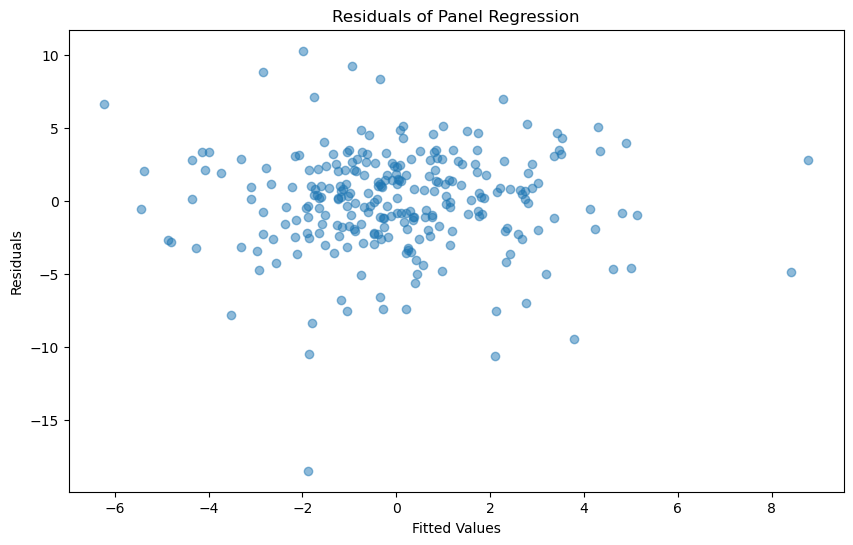

In [266]:
residuals = panel_ols.resids
fitted_values = panel_ols.fitted_values

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.title('Residuals of Panel Regression')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

## 17.5. Report the IV estimator (IVREG) when you use the instruments in levels GDPGi,t-2 and (aid/GDP)i,t-2 . Comment how much each parameter changes when using OLS versus IV.

### Anderson-Hsiao Regression

In [267]:
_df_filtered.head()

YEAR1      GDPG     GDP        BB      INFL  SACW  \
Country   Year                                                          
Argentina 1     1970-1973  1.700300  5637.0 -0.021146  0.340886   0.0   
          2     1974-1977  1.077615  6168.0 -0.069117  0.989960   0.0   
          3     1978-1981 -1.115285  5849.0 -0.033950  0.844831   0.0   
          4     1982-1985 -2.551385  5487.0 -0.052203  1.622836   0.0   
          5     1986-1989 -1.099306  5624.0 -0.017726  1.607182   0.0   

                     GOVC  ETHNF  ASSAS    ICRGE       M2-1  SSA  EASIA  \
Country   Year                                                            
Argentina 1     10.194982   0.31   2.75  4.28125  24.824762    0      0   
          2     11.044480   0.31   9.75  4.28125  28.793040    0      0   
          3     11.086979   0.31   1.00  4.28125  30.234517    0      0   
          4           NaN   0.31   0.00  4.28125  29.739766    0      0   
          5           NaN   0.31   0.25  4.28125  20.330552    0      0   

                     LPOP  EGYPT  CENTAM  FRZ  ARMS-1  DN1900       EDA  \
Country   Year                                                            
Argentina 1     17.017208    0.0     0.0  0.0   2.033       1  0.018239   
          2     17.082911    0.0     0.0  0.0   1.725       1  0.017155   
          3     17.144003    0.0     0.0  0.0   1.075       1  0.023994   
          4     17.201318    0.0     0.0  0.0   6.125       1  0.029963   
          5     17.257792    0.0     0.0  0.0  10.800       1  0.015728   

                    BEDA      MEDA     WBEDA     POPDEP  year_3  year_4  \
Country   Year                                                            
Argentina 1     0.016755  0.001484 -0.000961  57.374800       0       0   
          2     0.016532  0.000623 -0.002459  58.844350       1       0   
          3     0.019493  0.004501 -0.002057  61.571267       0       1   
          4     0.015635  0.014328 -0.002369  64.263600       0       0   
          5     0.034239 -0.018512 -0.020754        NaN       0       0   

                year_5  year_6  year_7  ETHNF*ASSAS      lGDP  Constant  \
Country   Year                                                            
Argentina 1          0       0       0       0.8525  8.637107         1   
          2          0       0       0       3.0225  8.727130         1   
          3          0       0       0       0.3100  8.674026         1   
          4          1       0       0       0.0000  8.610137         1   
          5          0       1       0       0.0775  8.634798         1   

                  Policy  ICRGE*EDA  GDPG_diff  EDA_diff  GDPG_diff_lag1  \
Country   Year                                                             
Argentina 1     0.656556   0.078085  -1.536384 -0.482648        0.850419   
          2    -0.579265   0.073447  -0.622685 -0.001083       -1.536384   
          3    -0.135645   0.102725  -2.192900  0.006839       -0.622685   
          4    -1.348296   0.128279  -1.436100  0.005969       -2.192900   
          5    -1.090419   0.067333   1.452078 -0.014236       -1.436100   

                EDA_diff_lag1  lGDP_diff  Policy_diff  ETHNF*ASSAS_diff  \
Country   Year                                                            
Argentina 1         -0.531399   0.915759    -0.757120            0.8525   
          2         -0.482648   0.090023    -1.235821            2.1700   
          3         -0.001083  -0.053104     0.443619           -2.7125   
          4          0.006839  -0.063889    -1.212651           -0.3100   
          5          0.005969   0.024661     0.257877            0.0775   

                ASSAS_diff  M2-1_diff  GDPG_lag2  EDA_lag2  
Country   Year                                              
Argentina 1           2.75 -36.637710   2.386265  1.032286  
          2           7.00   3.968278   3.236684  0.500887  
          3          -8.75   1.441477   1.700300  0.018239  
          4          -1.00  -0.494751   

In [268]:
from linearmodels.iv import IV2SLS
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

dependent = _df_filtered['GDPG_diff']
endog = _df_filtered[['GDPG_diff_lag1', 'EDA_diff_lag1']]
exog = _df_filtered[['lGDP_diff', 'Policy_diff', 'ETHNF*ASSAS_diff', 'M2-1_diff']]
exog = sm.add_constant(exog)

instruments = _df_filtered[['GDPG_lag2', 'EDA_lag2']]

first_stage_results = {}
for var in endog.columns:
    predictors = exog.join(instruments)
    model = OLS(endog[var], predictors)
    results = model.fit()
    first_stage_results[var] = results
    print(f"First stage regression for {var}:")
    print(results.summary())
    _df_filtered[var + '_fitted'] = results.predict()

exog_second_stage = exog.join(_df_filtered[[var + '_fitted' for var in endog.columns]])


First stage regression for GDPG_diff_lag1:
                            OLS Regression Results                            
Dep. Variable:         GDPG_diff_lag1   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     28.95
Date:                Sun, 07 Jan 2024   Prob (F-statistic):           2.39e-26
Time:                        20:20:15   Log-Likelihood:                -684.29
No. Observations:                 262   AIC:                             1383.
Df Residuals:                     255   BIC:                             1408.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

For GDPG, the $R^2$ in the first-stage regression is 0.405 which is very high, and the f-statistic is 28.95, far exceeding the rule of thumb statistic of 10. This suggests that the instruments are of high relevance to $\Delta GDPG_{i,t-1}$. For EDA, the $R^2$ is lower but still good at 0.3, and the f-statistic is equally impressive at 18.26. Our suspicions of the second lags of GDPG and EDA being good instruments for the first lags of the first differenced GDPG and EDA respectively are confirmed.

In [269]:
y = dependent
X = _df_filtered[['GDPG_diff_lag1_fitted', 'EDA_diff', 'EDA_diff_lag1_fitted', 'lGDP_diff', 
         'Policy_diff', 'ETHNF*ASSAS_diff', 'M2-1_diff']]
iv_2 = lm.PanelOLS(y, X, entity_effects=False, time_effects=True).fit(cov_type='clustered', cluster_entity=True)
print(iv_2.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              GDPG_diff   R-squared:                        0.0819
Estimator:                   PanelOLS   R-squared (Between):              0.4022
No. Observations:                 262   R-squared (Within):               0.0492
Date:                Sun, Jan 07 2024   R-squared (Overall):              0.0635
Time:                        20:20:16   Log-likelihood                   -722.30
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.1747
Entities:                          48   P-value                           0.0031
Avg Obs:                       5.4583   Distribution:                   F(7,249)
Min Obs:                       3.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             1.8121
                            

Including time fixed effects in the second stage, the fitted values of the first lags of the first differenced GDPG and EDA are used as explanatory variables, alongside the control variables. The $R^2$ is low at 0.7 and the f-statistic measuring joint significance of the explanatory variables is not too inspirational. Indeed, only one of the p-values is significant: the trusty policy index. All coefficients are positive excluding the log of GDPG, indicating positive covariance but not suggesting the equilibrium reverting effect seen in other models.

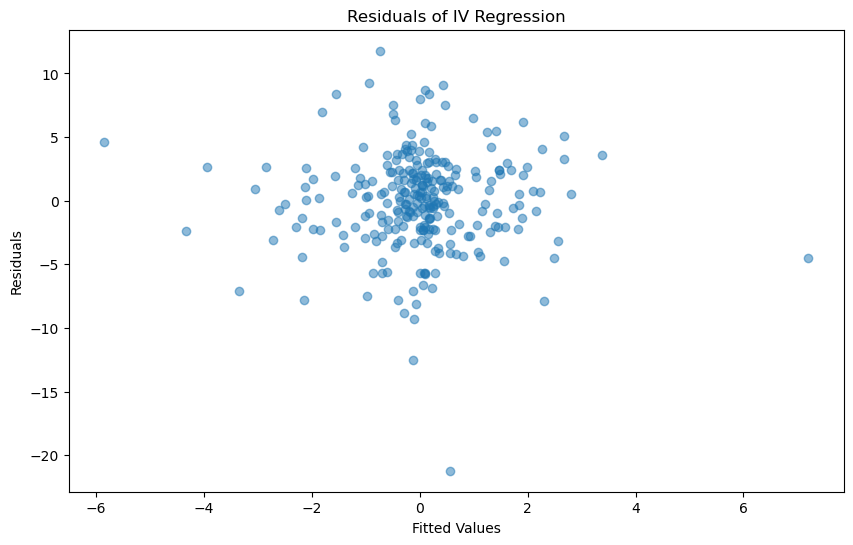

In [270]:
residuals = iv_2.resids
fitted_values = iv_2.fitted_values

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.title('Residuals of IV Regression')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

In [271]:
panel_ols_params = panel_ols.params

iv_2_params = iv_2.params
iv_2_params['EDA_diff_lag1'] = iv_2_params['EDA_diff_lag1_fitted']
iv_2_params['GDPG_diff_lag1'] = iv_2_params['GDPG_diff_lag1_fitted']

comparison_df = pd.DataFrame({
    'Panel_OLS': panel_ols_params,
    'IV_Model': iv_2_params
})

rows_to_print = ['GDPG_diff_lag1', 'EDA_diff_lag1', 'EDA_diff', 'lGDP_diff', 
                 'Policy_diff', 'ETHNF*ASSAS_diff', 'M2-1_diff']

comparison_df.loc[rows_to_print]

Panel_OLS  IV_Model
GDPG_diff_lag1    -0.408648  0.091338
EDA_diff_lag1      0.148945  0.040534
EDA_diff           0.057755  0.003176
lGDP_diff          0.208647 -0.627986
Policy_diff        0.987071  0.988569
ETHNF*ASSAS_diff   0.110968  0.136653
M2-1_diff          0.024943  0.022613

Here is the comparison between the OLS model and the IV model. Recall that the statistically significant variables for the OLS model are GDPG_diff_lag1 and policy_diff. For IV, only policy_diff. The coefficient switches signs for the IV model compared to the OLS model. Given that the OLS model's coefficient for this variable is statistically significant, the equilibrium-reversion of GDPG can be assumed. The coefficient for policy is surprisingly consistent across the models taking almost exactly the same value and being statistically significant for both models. The only other sign change observed is the log of GDP first-differenced, which is positive with OLS and negative with the Anderson-Hsiao model.

## 17.6. Report the first stage regressions. Comment the R2 of each of the first stage regressions, if below 10%, it is a signal of weak instrument. You may comment statistics available in your software for weak instruments and for testing endogeneity of instruments.

OLS R-squared: 0.2504, IV R-Squared is 0.0820, first-stage F-statistic for GDP_diff_lag1 is 28.95, and for EDA_diff_lag1 is 18.26

A rule of thumb is that the F-statistic for the instruments in the first stage should be above 10 to indicate that the instruments are strong.

As mentioned above, both first-stage IV regressions see high(ish) $R^2$s of 0.405 for GDPGH and 0.3 for EDA, signalling strong instruments. The f-statistics also exceed the rule of thumb and are 28.95 for GDPG and 18.26 for EDA. The instruments therefore appear to be strong.

## 17.7. Compute and plot the impulse response functions for the next four periods for 1 unit increase of aid/GDP on GDPG:

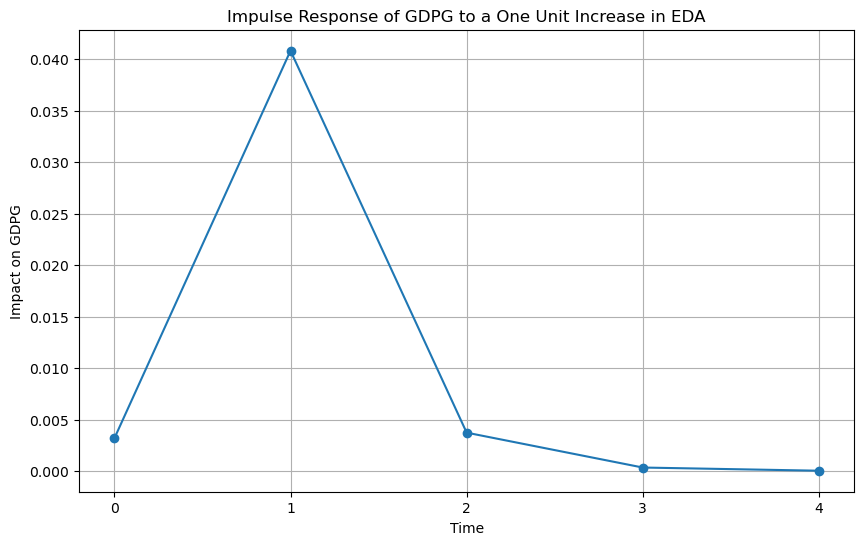

In [272]:
beta_1 = iv_2.params['EDA_diff']
beta_y = iv_2.params['GDPG_diff_lag1_fitted']
beta_2 = iv_2.params['EDA_diff_lag1_fitted']
impulse_responses = {
    0: beta_1,
    1: beta_y * beta_1 + beta_2,
    2: beta_y**2 * beta_1 + beta_y * beta_2,
    3: beta_y**3 * beta_1 + beta_y**2 * beta_2,
    4: beta_y**4 * beta_1 + beta_y**3 * beta_2
}

time_periods = list(impulse_responses.keys())
gdp_impact = list(impulse_responses.values())

plt.figure(figsize=(10, 6))
plt.plot(time_periods, gdp_impact, marker='o')
plt.title('Impulse Response of GDPG to a One Unit Increase in EDA')
plt.xlabel('Time')
plt.ylabel('Impact on GDPG')
plt.xticks(time_periods)
plt.grid(True)
plt.show()

The impulse response function is plotted above. The mean-reversion effect that I have mentioned throughout the project appears to hold true for GDPG. With a one unit shock in effective aid, growth is stimulated and the growth rate increases to 0.040. However, the negative coefficient on the first-lag-of-the-first-difference of GDPG then decreases GDPG for the second period and the effect gradually dissipates as the impact on GDPG of a shock to EDA fizzles out.

## 17.8. Compute the long run coefficient of aid/GDP on GDPG and comment:

In [273]:
beta_LR = (beta_1 + beta_2) / (1 - beta_y)
print(f'the long run coefficient of EDA on GDPG is {beta_LR}')

the long run coefficient of EDA on GDPG is 0.04810347017912615


The long-run coefficient refers to the total effect on GDPG of a change in EDA. The coefficient is positive, suggesting effective aid does have a positive effect on GDP growth in the long-run but it is less than one so while EDA has a positive and lasting impact on GDPG, the impact decreases over time, stabilises, and there is an absence of explosive behaviour.

# 18. Propose an interesting estimation using the database.

Let's remind ourselves of the variables in the BD database.

The variables are GDP Growth (GDPG), GDP (GDP), Budget surplus (BB), Inflation (INFL), Sachs-Warner openness (SACW), Government consumption  (GOVC), ethnic fractionalisation (ETHNF), Assasinations (ASSAS), international country risk guide (ICRGE), money supply lagged (M2-1), Sub-Saharan Africa indicator (SSA), East-Asia indicator (EASIA), log population (LPOP), indicator dummy for Egypt (EGYPT), central America indicator (CENTAM), franc zone indicator (FRZ), lagged arms imports (ARMS-1), indicator for countries not dominated by Europeans by 1900 (DN1900), Economic Development assistance (EDA), bilateral economic development assistance (BEDA), multilateral economic development assistance (MEDA), World Bank economic development assistance (WBEDA), population dependency (POPDEP). 

An interest of mine, particularly recently with the war in Sudan, and something I enjoyed researching during my time in development economics classes is the effect of economic development on the incidence of civil wars or political violence. One of the parameters that is not utilised in the Burnside and Dollar estimations is the ARMS-1. This variable is the lag of arms imports. There are a couple of 'violent' variables in this database: ARMS-1 and ASSAS which is assassinations. It would be interesting to examine the effect of Ethnic fractionalisation (ETHNF), Arms imports, International country risk (if not too highly correlated with the other variables) and GDP growth on Assassinations. The hypothesis is that lower GDP growth is associated with more assassinations, as it is indicative of economic struggle (so we would expect a negative coefficient). We would naturally expect a positive coefficient for ARMS-1 because lagged arms imports could perhaps be indicative of a government preparing to fight a coup d'etat or rebel forces. The ICRGE should be negatively associated, but the issue with this variable is that it is likely a proxy or amalgamation of the other variables. It is not a variable that is observed but rather a metric of the other variables. The dummy variables will be important here. I will focus on SSA, initially with a Franc zone dummy and indicator for countries not dominated by Europeans by 1900. I will use SACW as controls because open countries with trading partners are less likely to be thwart by political turmoil (that involves excessive violence). Economic controls will include M2-1, EDA and INFL. I will also include time fixed effects only.

In [275]:
df_SSA = _df[_df['SSA'] == 1]
df_SSA.head()

YEAR1       GDPG     GDP        BB      INFL  SACW  \
Country  Year                                                           
Botswana 3     1978-1981   8.787622  1620.0 -0.000412  0.119363  0.75   
         4     1982-1985   6.410942  1980.0  0.107224  0.091341  1.00   
         5     1986-1989   7.249001  2662.0  0.178574  0.094643  1.00   
Cameroon 2     1974-1977   4.224090   902.0 -0.015903  0.129477  0.00   
         3     1978-1981  11.107441   972.0  0.001032  0.093579  0.00   

                    GOVC  ETHNF  ASSAS    ICRGE       M2-1  SSA  EASIA  \
Country  Year                                                            
Botswana 3     20.758605   0.51    0.0  7.00000  29.818357    1      0   
         4     25.863955   0.51    0.0  7.00000  30.254924    1      0   
         5     24.369807   0.51    0.0  7.00000  27.931612    1      0   
Cameroon 2     10.626417   0.89    0.0  5.65625  16.424114    1      0   
         3      9.107067   0.89    0.0  5.65625  20.423173    1      0   

                    LPOP  EGYPT  CENTAM  FRZ  ARMS-1  DN1900       EDA  \
Country  Year                                                            
Botswana 3     13.699656    0.0     0.0  0.0   0.900       0  6.361377   
         4     13.838566    0.0     0.0  0.0   1.275       0  4.561441   
         5     13.975186    0.0     0.0  0.0   0.425       0  4.441170   
Cameroon 2     15.848834    0.0     0.0  1.0   0.000       0  2.510611   
         3     15.960251    0.0     0.0  1.0   0.900       0  2.035233   

                   BEDA      MEDA     WBEDA      POPDEP  year_3  year_4  \
Country  Year                                                             
Botswana 3     5.185147  1.176230  0.011632  102.878500       0       1   
         4     3.548772  1.012670 -0.060291   98.148275       0       0   
         5     3.444303  0.996867 -0.021705   93.089400       0       0   
Cameroon 2     1.861177  0.649434  0.213449   88.653875       1       0   
         3     1.412936  0.622296  0.192449   91.661825       0       1   

               year_5  year_6  year_7  ETHNF*ASSAS      lGDP  Constant  \
Country  Year                                                            
Botswana 3          0       0       0          0.0  7.390181         1   
         4          1       0       0          0.0  7.590852         1   
         5          0       1       0          0.0  7.886833         1   
Cameroon 2          0       0       0          0.0  6.804615         1   
         3          0       0       0          0.0  6.879356         1   

                 Policy  ICRGE*EDA  GDPG_diff  EDA_diff  GDPG_diff_lag1  \
Country  Year                                                             
Botswana 3     2.725642  44.529639   6.838149  3.019400        2.596499   
         4     4.040735  31.930090  -2.376680 -1.799936        6.838149   
         5     4.524512  31.088188   0.838059 -0.120272       -2.376680   
Cameroon 2     0.988016  14.200645   6.272719  2.487900       -3.725221   
         3     1.154126  11.511784   6.883351 -0.475379        6.272719   

               EDA_diff_lag1  lGDP_diff  Policy_diff  ETHNF*ASSAS_diff  \
Country  Year                                                            
Botswana 3          0.234428  -0.023186    -0.411343            -0.170   
         4          3.019400   0.200671     1.315093             0.000   
         5         -1.799936   0.295981     0.483777             0.000   
Cameroon 2          0.014172  -1.499880     2.033729            -0.105   
         3          2.487900   0.074741     0.166110             0.000   

               ASSAS_diff  M2-1_diff  GDPG_lag2  EDA_lag2  
Country  Year                                              
Botswana 3          -0.25  14.912624  -0.647025  3.107549  
         4           0.00   0.436567   1.949474  3.341977  
         5           0.00  -2.323312   8.787622  6.361377  
Cameroon 2          -1.50 -17.304498   1.676592  0.008539  
         3         

In [276]:
X = df_SSA[['Constant', 'ETHNF', 'ARMS-1', 'GDPG', 'FRZ', 'DN1900', 'SACW', 'M2-1', 'EDA', 'INFL']]
y = df_SSA['ASSAS']
panel_ols = lm.PanelOLS(y, X, entity_effects=False, time_effects=True, drop_absorbed=False).fit(cov_type='clustered', cluster_entity=True)
print(panel_ols.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  ASSAS   R-squared:                        0.0801
Estimator:                   PanelOLS   R-squared (Between):              0.3592
No. Observations:                  84   R-squared (Within):              -0.0228
Date:                Sun, Jan 07 2024   R-squared (Overall):              0.0753
Time:                        20:20:23   Log-likelihood                    76.340
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.6678
Entities:                          21   P-value                           0.7350
Avg Obs:                       4.0000   Distribution:                    F(9,69)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             3.8208
                            

The $R^2$ is fairly low at 0.08, indicating only 8% of the variation in Assassinations is explained by our explanatory variables. The f-statistic indicates the joint significance of the explanatory variables and this is also low at 0.67.

The lag of arms imports is statistically significant at the 90% level and has a negative coefficient (but small) which is unexpected. It suggests that an increase in imports of arms is associated with a fall in the number of assassinations. Another statistically significant variable, this time at 99% confidence, is the indicator for franc zone. This coefficient is also negative, suggesting that being in a franc zone is associated with lower assassinations. The final statistically significant variable is inflation, which is also associated negative with assassinations and is significant only at the 90% level. 

Overall, the results are not too robust. It is an interesting proposal to examine the causes of assassinations and any macroeconomic motivations, but perhaps the dataset is not rich enough and the control variables are not suitable enough to perform the estimation robustly.

# 19. Download GDP growth and foreign aid ODA/GDP from World Bank and/or IMF and/or FRED databases with the largest coverage of years and countries. Compute first differences in panel for both variables. Report the simple correlation coefficient with its number of observations. Is it similar to the one found in question 16.2?

In [277]:
gdp_growth_df = pd.read_excel('/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Panel Data/Homework/Q19/GDPG.xlsx')
oda_df = pd.read_excel('/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Panel Data/Homework/Q19/ODA.xlsx')
#both from the World Bank

In [278]:
gdp_growth_long = gdp_growth_df.melt(id_vars=["Country Name"], var_name="Year", value_name="GDPG")
oda_long = oda_df.melt(id_vars=["Country Name"], var_name="Year", value_name="ODA")
merged_df = pd.merge(gdp_growth_long, oda_long, on=["Country Name", "Year"], how="outer")
panel_data = merged_df.pivot_table(index=["Country Name", "Year"])

panel_data

GDPG       ODA
Country Name Year                    
Afghanistan  1960       NaN  3.129960
             1961       NaN  6.191071
             1962       NaN  3.035259
             1963       NaN  4.783043
             1964       NaN  5.661171
...                     ...       ...
Zimbabwe     2018  5.009867  2.375871
             2019 -6.332446  3.936021
             2020 -7.816951  4.671035
             2021  8.468017  3.514250
             2022  6.522375       NaN

[13166 rows x 2 columns]

In [279]:
panel_data['GDPG_diff'] = panel_data.groupby(level=0)['GDPG'].diff()
panel_data['ODA_diff'] = panel_data.groupby(level=0)['ODA'].diff()

# Drop rows with missing observations in either GDPG or ODA
panel_data_diff = panel_data.dropna(subset=['GDPG', 'ODA'])
#let's get rid of the 'categories' not countries
countries_to_drop = [
    "Africa Eastern and Southern", "Africa Western and Central", "Arab World", 
    "Caribbean small states", "Central Europe and the Baltics", "Early-demographic dividend", 
    "East Asia & Pacific", "East Asia & Pacific (IDA & IBRD countries)", 
    "East Asia & Pacific (excluding high income)", "Euro area", "Europe & Central Asia", 
    "Europe & Central Asia (IDA & IBRD countries)", "Europe & Central Asia (excluding high income)", 
    "European Union", "Fragile and conflict affected situations", "Heavily indebted poor countries (HIPC)", 
    "High income", "IBRD only", "IDA & IBRD total", "IDA blend", "IDA only", "IDA total", 
    "Late-demographic dividend", "Latin America & Caribbean", "Latin America & Caribbean (excluding high income)", 
    "Latin America & the Caribbean (IDA & IBRD countries)", "Least developed countries: UN classification", 
    "Low & middle income", "Low income", "Lower middle income", "Middle East & North Africa", 
    "Middle East & North Africa (IDA & IBRD countries)", "Middle East & North Africa (excluding high income)", 
    "Middle income", "OECD members", "Other small states", "Post-demographic dividend", 
    "Pre-demographic dividend", "Small states", "Sub-Saharan Africa", 
    "Sub-Saharan Africa (IDA & IBRD countries)", "Sub-Saharan Africa (excluding high income)", 
    "Upper middle income"
]

panel_data_diff = panel_data_diff.drop(index=countries_to_drop, level=0, errors='ignore')
panel_data_diff.head()

GDPG        ODA  GDPG_diff   ODA_diff
Country Name Year                                            
Afghanistan  2008   3.924984  47.601828  -9.901336        NaN
             2009  21.390528  49.385618  17.465545   1.783790
             2010  14.362441  39.250964  -7.028087 -10.134654
             2011   0.426355  37.936821 -13.936087  -1.314143
             2012  12.752287  33.398540  12.325932  -4.538281

In [280]:
num_countries = panel_data_diff.index.get_level_values(0).nunique()

total_observations = len(panel_data_diff)
observations_per_country = panel_data_diff.groupby(level=0).size()

print(f'number of countries = {num_countries}\n')
print("=" * 30)
print(f'number of observations in total = {total_observations}\n')
print("=" * 30)
print(observations_per_country)

number of countries = 165

number of observations in total = 6860

Country Name
Afghanistan                       14
Albania                           34
Algeria                           61
Angola                            37
Antigua and Barbuda               44
Argentina                         39
Armenia                           31
Aruba                             13
Azerbaijan                        29
Bahamas, The                      33
Bahrain                           24
Bangladesh                        49
Barbados                          25
Belarus                           17
Belize                            61
Benin                             61
Bhutan                            41
Bolivia                           46
Bosnia and Herzegovina            27
Botswana                          61
Brazil                            33
Brunei Darussalam                  7
Burkina Faso                      61
Burundi                           61
Cabo Verde                      

### 17.2 correlation matrix

In [281]:
vars = ['GDPG_diff', 'GDPG_diff_lag1', 'EDA_diff', 'EDA_diff_lag1', 'GDPG_lag2', 'EDA_lag2']
clean_df = df.dropna(subset=vars)

n = len(vars)
p_values = np.zeros((n, n))
output = np.zeros((n, n))

for i, var1 in enumerate(vars):
    for j, var2 in enumerate(vars):
        output[i, j], p_values[i, j] = pearsonr(clean_df[var1], clean_df[var2])

output = pd.DataFrame(output, columns=vars, index=vars)
p_values = pd.DataFrame(p_values, columns=vars, index=vars)
new_out = pd.DataFrame()

for col in output.columns:
    temp = add_stars(output[col], p_values[col])
    temp.name = col
    new_out = pd.concat([new_out, temp], axis=1)

new_out.index = [x.replace(' ', '')[:6] for x in output.index]
new_out.columns = [x.replace(' ', '')[:6] for x in new_out.columns]

print('Simple Correlation Matrix for Anderson-Hsiao variables')
print('=' * 110)
print(new_out)
print('\n')
print('*** - p < 0.01, ** - p < 0.05, * - p < 0.1')
print("Note: Pearson's correlation coefficient assumes normally distributed variables")

Simple Correlation Matrix for Anderson-Hsiao variables
           GDPG_d     GDPG_d     EDA_di     EDA_di     GDPG_l     EDA_la
GDPG_d   1.000***  -0.401***     -0.049      0.054   -0.119**      0.051
GDPG_d  -0.401***   1.000***     -0.052     -0.048  -0.606***     0.101*
EDA_di     -0.049     -0.052   1.000***  -0.199***     -0.012  -0.275***
EDA_di      0.054     -0.048  -0.199***   1.000***     -0.075  -0.457***
GDPG_l   -0.119**  -0.606***     -0.012     -0.075   1.000***  -0.172***
EDA_la      0.051     0.101*  -0.275***  -0.457***  -0.172***   1.000***


*** - p < 0.01, ** - p < 0.05, * - p < 0.1
Note: Pearson's correlation coefficient assumes normally distributed variables


### World Bank Correlation

In [282]:
correlation, p_value = pearsonr(panel_data_diff['GDPG'], panel_data_diff['ODA'])
print(f'the Pearsons correlation coefficient is {correlation} with a p-value of {p_value}')

the Pearsons correlation coefficient is -0.06492771002035207 with a p-value of 7.352179059493659e-08


The correlation coefficient for the 17.2 first-differenced GDPG and first-differenced EDA is -0.049 and it is not statistically significant. For the World Bank 'EDA' and GDP growth, the correlation coefficient is also negative and similar in value: -0.0649. It is also statistically significant. We have far more observations, almost 7000 in total so the estimation of such a similar coefficient is very promising for the external validity of the models above.

# 20. Optional: mention or propose improvements to the Python, STATA, SAS or R code (copy it here). Optional: propose improvements, additional insights, and you do not know how to code them.

Python is an excellent language for a beginner. It has a very readable syntax which makes it easy to figure out what the code does and also makes it more difficult to forget how to code the language. One thing I do not like about python is the error messages can be very unenlightening. Sometimes a simple mistake in the code can create error messages that are very unintuitive and can be difficult to figure out. There are libraries you can install to assist with the error messages but overall I find C's error messages easier to understand and rectify. While it is easier to code without declaring a variable, I find explicitly declaring a type in C useful (you would say int, float, double) to declare a variable type. It also reduces the incidence of run-time errors. Much of the debugging I encountered throughout this assignment involved some of the variables being classified as objects which prevented any numerical manipulation. The error messages are not always intuitive or useful when this happens during the running of a big block of code, so C's method of being able to explicitly set the type of a variable can be quite nice.

As I explored in question 18, the variables in the database that are little utilised are those 'violence' variables. What I would be interested to do, but do not know how to code, would be a geographical based implementation of what I did in question 18. It would be interesting to have parameters that encompass whether countries are neighbours to account for spillovers of political violence. It would be good to produce a map that allows me to visualise how the cross-border violence is distributed. For example, have 'hot zones' that show where the violence is regardless of the border, like a kind of heatmap.

# References

Ao, X., 2009. An Introduction to Hausman-Taylor Model.

Burnside, C. and Dollar, D., 2000. Aid, policies, and growth. American economic review, 90(4), pp.847-868.

Grabowski, J., 2019. Panel Data Homework for M2 Financial Economics

Jia, S. and Williamson, C.R., 2019. Aid, policies, and growth: why so much confusion?. Contemporary Economic Policy, 37(4), pp.577-599.